In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import copy

device = torch.device('cude' if torch.cuda.is_available() else 'cpu')

# hyperparameters
input_size = 784
batch_size = 64
hidden_size = 100
num_classes = 10
learning_rate = 0.001
num_epochs = 10



In [2]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data',
                                          train=False,
                                          transform=transforms.ToTensor())


# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [13]:
def distillation(y, labels, teacher_scores, T, alpha, original_weight, reconstructed_weight):
    print(F.cross_entropy(y, labels), torch.nn.MSELoss()(original_weight, reconstructed_weight), nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha))
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha)\
+ F.cross_entropy(y, labels) * (1. - alpha)+ torch.nn.MSELoss()(original_weight, reconstructed_weight) *100

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [15]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(100, 10),
        )
          

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 100),
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
# class AEAndReconstructed(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#         self.reconstructed_model = copy.deepcopy(model)
#         self.ae = AE()
  
#     def forward(self, x):
#         reconstructed = self.ae(self.model.fc1.weight.data.transpose(1, 0))
#         new_weight = torch.transpose(reconstructed.reshape(784, 100), 1, 0)
#         self.reconstructed_model.fc1.weight.data = new_weight
#         return self.reconstructed_model(x)

In [17]:
def get_reconstructed(images, model, ae):
    reconstructed = ae(model.fc1.weight.data.transpose(1, 0))
    new_weight = torch.transpose(reconstructed.reshape(784, 100), 1, 0)
    reconstructed_model = copy.deepcopy(model)
    reconstructed_model.fc1.weight.data = new_weight
    labels = reconstructed_model(images)
    return labels, new_weight.flatten(), model.fc1.weight.data.flatten()
    

In [18]:
model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
model.load_state_dict(torch.load(f'../model/model_1.ckpt'))
ae = AE()
epochs = 30
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(ae.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)
losses = []
for epoch in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        student_output, student_weight, original_weight = get_reconstructed(images, model, ae)
        teacher_output = model(images)
        teacher_output = teacher_output.detach()
        loss = distillation(student_output, labels, teacher_output, T=10, alpha=0.5, original_weight=original_weight, reconstructed_weight=student_weight)
#         loss.requres_grad = True
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))


<ipython-input-13-ed49333d23b6>:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.cross_entropy(y, labels), torch.nn.MSELoss()(original_weight, reconstructed_weight), nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha))
<ipython-input-13-ed49333d23b6>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.cross_entropy(y, labels), torch.nn.MSELoss()(original_weight, reconstructed_weight), nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha))
/Users/nakmarx/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:2747: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same a

tensor(77.9397, grad_fn=<NllLossBackward0>) tensor(0.0559, grad_fn=<MseLossBackward0>) tensor(54.4112, grad_fn=<MulBackward0>)
Train Epoch: 0 [0/60000 (0%)]	Loss: 98.969002
tensor(51.8963, grad_fn=<NllLossBackward0>) tensor(0.0567, grad_fn=<MseLossBackward0>) tensor(32.7610, grad_fn=<MulBackward0>)
tensor(33.8819, grad_fn=<NllLossBackward0>) tensor(0.0398, grad_fn=<MseLossBackward0>) tensor(20.2827, grad_fn=<MulBackward0>)
tensor(32.2832, grad_fn=<NllLossBackward0>) tensor(0.0295, grad_fn=<MseLossBackward0>) tensor(16.7953, grad_fn=<MulBackward0>)
tensor(25.3774, grad_fn=<NllLossBackward0>) tensor(0.0281, grad_fn=<MseLossBackward0>) tensor(13.8558, grad_fn=<MulBackward0>)
tensor(21.9011, grad_fn=<NllLossBackward0>) tensor(0.0253, grad_fn=<MseLossBackward0>) tensor(11.4332, grad_fn=<MulBackward0>)
tensor(14.9825, grad_fn=<NllLossBackward0>) tensor(0.0225, grad_fn=<MseLossBackward0>) tensor(7.5929, grad_fn=<MulBackward0>)
tensor(10.1450, grad_fn=<NllLossBackward0>) tensor(0.0207, grad_fn

tensor(0.6757, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.0818, grad_fn=<MulBackward0>)
tensor(1.1698, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9597, grad_fn=<MulBackward0>)
tensor(1.1603, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0873, grad_fn=<MulBackward0>)
tensor(0.5381, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7802, grad_fn=<MulBackward0>)
tensor(0.7654, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9735, grad_fn=<MulBackward0>)
tensor(1.9622, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0727, grad_fn=<MulBackward0>)
tensor(1.0853, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0830, grad_fn=<MulBackward0>)
tensor(0.6068, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8041, grad_fn=<MulBackward0>)


tensor(0.4708, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9602, grad_fn=<MulBackward0>)
tensor(1.3584, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0544, grad_fn=<MulBackward0>)
tensor(0.7543, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9670, grad_fn=<MulBackward0>)
tensor(0.8557, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8776, grad_fn=<MulBackward0>)
tensor(0.5471, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0393, grad_fn=<MulBackward0>)
tensor(1.6819, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2655, grad_fn=<MulBackward0>)
tensor(1.7002, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2033, grad_fn=<MulBackward0>)
tensor(1.0675, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8788, grad_fn=<MulBackward0>)


tensor(0.7773, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9915, grad_fn=<MulBackward0>)
tensor(0.9529, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0407, grad_fn=<MulBackward0>)
tensor(0.5260, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8157, grad_fn=<MulBackward0>)
tensor(1.2418, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9605, grad_fn=<MulBackward0>)
tensor(0.6136, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8767, grad_fn=<MulBackward0>)
tensor(1.4660, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9010, grad_fn=<MulBackward0>)
tensor(1.0154, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0530, grad_fn=<MulBackward0>)
tensor(1.2162, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0084, grad_fn=<MulBackward0>)


tensor(1.1859, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9915, grad_fn=<MulBackward0>)
tensor(1.3201, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8722, grad_fn=<MulBackward0>)
tensor(1.3399, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9809, grad_fn=<MulBackward0>)
tensor(1.6371, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0545, grad_fn=<MulBackward0>)
tensor(1.3966, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0421, grad_fn=<MulBackward0>)
tensor(1.3743, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0527, grad_fn=<MulBackward0>)
tensor(1.6566, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1064, grad_fn=<MulBackward0>)
tensor(0.9518, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8271, grad_fn=<MulBackward0>)


tensor(1.5202, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0972, grad_fn=<MulBackward0>)
tensor(0.7572, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8709, grad_fn=<MulBackward0>)
tensor(0.9603, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9513, grad_fn=<MulBackward0>)
tensor(1.2567, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9729, grad_fn=<MulBackward0>)
tensor(0.8483, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7978, grad_fn=<MulBackward0>)
tensor(1.0250, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9297, grad_fn=<MulBackward0>)
tensor(1.6626, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0713, grad_fn=<MulBackward0>)
tensor(0.7119, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8860, grad_fn=<MulBackward0>)


tensor(1.1368, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9392, grad_fn=<MulBackward0>)
tensor(1.1470, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1122, grad_fn=<MulBackward0>)
tensor(1.2666, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9398, grad_fn=<MulBackward0>)
tensor(1.3785, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0120, grad_fn=<MulBackward0>)
tensor(1.4949, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(0.9877, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9363, grad_fn=<MulBackward0>)
tensor(1.1679, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9439, grad_fn=<MulBackward0>)
tensor(0.7976, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8809, grad_fn=<MulBackward0>)


tensor(1.5594, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1032, grad_fn=<MulBackward0>)
tensor(0.7951, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0673, grad_fn=<MulBackward0>)
tensor(1.1909, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8364, grad_fn=<MulBackward0>)
tensor(0.8409, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0343, grad_fn=<MulBackward0>)
tensor(1.2466, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0024, grad_fn=<MulBackward0>)
tensor(1.3153, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9827, grad_fn=<MulBackward0>)
tensor(1.4851, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0338, grad_fn=<MulBackward0>)
tensor(0.8414, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8259, grad_fn=<MulBackward0>)


tensor(1.0210, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0495, grad_fn=<MulBackward0>)
tensor(0.9973, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8665, grad_fn=<MulBackward0>)
tensor(0.9270, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9416, grad_fn=<MulBackward0>)
tensor(0.6545, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8314, grad_fn=<MulBackward0>)
tensor(0.6558, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9096, grad_fn=<MulBackward0>)
tensor(0.8428, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9851, grad_fn=<MulBackward0>)
tensor(1.2537, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1993, grad_fn=<MulBackward0>)
tensor(0.8031, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9554, grad_fn=<MulBackward0>)


tensor(1.4225, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1224, grad_fn=<MulBackward0>)
tensor(0.9931, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0637, grad_fn=<MulBackward0>)
tensor(1.4177, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0899, grad_fn=<MulBackward0>)
tensor(0.5266, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8430, grad_fn=<MulBackward0>)
tensor(1.1133, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0053, grad_fn=<MulBackward0>)
tensor(0.9572, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9495, grad_fn=<MulBackward0>)
tensor(1.3245, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0287, grad_fn=<MulBackward0>)
tensor(0.8560, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9429, grad_fn=<MulBackward0>)


tensor(0.9965, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9006, grad_fn=<MulBackward0>)
tensor(1.0904, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8578, grad_fn=<MulBackward0>)
tensor(1.2225, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9433, grad_fn=<MulBackward0>)
tensor(0.8619, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8998, grad_fn=<MulBackward0>)
tensor(0.7941, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8809, grad_fn=<MulBackward0>)
tensor(0.7422, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9114, grad_fn=<MulBackward0>)
tensor(1.4496, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0726, grad_fn=<MulBackward0>)
tensor(1.0258, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0752, grad_fn=<MulBackward0>)


tensor(1.6356, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1728, grad_fn=<MulBackward0>)
tensor(1.2142, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9060, grad_fn=<MulBackward0>)
tensor(0.9534, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.3229, grad_fn=<MulBackward0>)
tensor(0.5152, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7960, grad_fn=<MulBackward0>)
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.029225
tensor(1.2286, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0984, grad_fn=<MulBackward0>)
tensor(1.5528, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1401, grad_fn=<MulBackward0>)
tensor(0.6670, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8236, grad_fn=<MulBackward0>)
tensor(1.2123, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(1.0196, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8709, grad_fn=<MulBackward0>)
tensor(1.4092, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0381, grad_fn=<MulBackward0>)
tensor(1.2373, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9573, grad_fn=<MulBackward0>)
tensor(1.0050, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9673, grad_fn=<MulBackward0>)
tensor(0.9131, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9139, grad_fn=<MulBackward0>)
tensor(1.3486, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9553, grad_fn=<MulBackward0>)
tensor(0.9903, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9708, grad_fn=<MulBackward0>)
tensor(0.5700, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9250, grad_fn=<MulBackward0>)


tensor(1.3093, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9573, grad_fn=<MulBackward0>)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.581464
tensor(1.6036, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1009, grad_fn=<MulBackward0>)
tensor(1.1389, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0452, grad_fn=<MulBackward0>)
tensor(1.5461, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1885, grad_fn=<MulBackward0>)
tensor(0.4157, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9758, grad_fn=<MulBackward0>)
tensor(2.1879, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.4706, grad_fn=<MulBackward0>)
tensor(0.6834, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0071, grad_fn=<MulBackward0>)
tensor(1.2148, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackwa

tensor(1.0088, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9919, grad_fn=<MulBackward0>)
tensor(1.1943, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0745, grad_fn=<MulBackward0>)
tensor(1.2488, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9266, grad_fn=<MulBackward0>)
tensor(0.7637, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9093, grad_fn=<MulBackward0>)
tensor(0.4989, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8497, grad_fn=<MulBackward0>)
tensor(1.6168, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9149, grad_fn=<MulBackward0>)
tensor(1.0072, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9640, grad_fn=<MulBackward0>)
tensor(1.2635, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0247, grad_fn=<MulBackward0>)


tensor(1.1421, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0980, grad_fn=<MulBackward0>)
tensor(0.9337, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0322, grad_fn=<MulBackward0>)
tensor(0.7721, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8353, grad_fn=<MulBackward0>)
tensor(1.1562, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0124, grad_fn=<MulBackward0>)
tensor(0.9541, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1095, grad_fn=<MulBackward0>)
tensor(1.4601, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1896, grad_fn=<MulBackward0>)
tensor(1.0355, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9812, grad_fn=<MulBackward0>)
tensor(0.6581, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9047, grad_fn=<MulBackward0>)


tensor(1.0577, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9617, grad_fn=<MulBackward0>)
tensor(1.2716, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1044, grad_fn=<MulBackward0>)
tensor(1.3537, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0525, grad_fn=<MulBackward0>)
tensor(1.3864, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8931, grad_fn=<MulBackward0>)
tensor(0.6890, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0317, grad_fn=<MulBackward0>)
tensor(1.0287, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0654, grad_fn=<MulBackward0>)
tensor(0.8612, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9739, grad_fn=<MulBackward0>)
tensor(1.3841, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0077, grad_fn=<MulBackward0>)


tensor(1.2722, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0036, grad_fn=<MulBackward0>)
tensor(1.2981, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0863, grad_fn=<MulBackward0>)
tensor(0.9270, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9813, grad_fn=<MulBackward0>)
tensor(1.1468, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9119, grad_fn=<MulBackward0>)
tensor(0.9519, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9526, grad_fn=<MulBackward0>)
tensor(1.0623, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0201, grad_fn=<MulBackward0>)
tensor(0.7599, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0189, grad_fn=<MulBackward0>)
tensor(1.1835, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0643, grad_fn=<MulBackward0>)


tensor(0.7814, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0311, grad_fn=<MulBackward0>)
tensor(1.0270, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9457, grad_fn=<MulBackward0>)
tensor(1.1668, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0270, grad_fn=<MulBackward0>)
tensor(1.4381, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0586, grad_fn=<MulBackward0>)
tensor(0.9533, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9694, grad_fn=<MulBackward0>)
tensor(1.1854, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8624, grad_fn=<MulBackward0>)
tensor(1.3015, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9202, grad_fn=<MulBackward0>)
tensor(1.5393, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1070, grad_fn=<MulBackward0>)


tensor(0.5965, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7744, grad_fn=<MulBackward0>)
tensor(1.2989, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.1929, grad_fn=<MulBackward0>)
tensor(1.5714, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.1580, grad_fn=<MulBackward0>)
tensor(1.5054, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.3828, grad_fn=<MulBackward0>)
tensor(4.0597, grad_fn=<NllLossBackward0>) tensor(0.0121, grad_fn=<MseLossBackward0>) tensor(2.6889, grad_fn=<MulBackward0>)
tensor(8.5803, grad_fn=<NllLossBackward0>) tensor(0.0201, grad_fn=<MseLossBackward0>) tensor(8.7551, grad_fn=<MulBackward0>)
tensor(24.1353, grad_fn=<NllLossBackward0>) tensor(0.0336, grad_fn=<MseLossBackward0>) tensor(11.9089, grad_fn=<MulBackward0>)
tensor(57.8524, grad_fn=<NllLossBackward0>) tensor(0.2299, grad_fn=<MseLossBackward0>) tensor(69.1086, grad_fn=<MulBackward

tensor(8.2228, grad_fn=<NllLossBackward0>) tensor(0.0144, grad_fn=<MseLossBackward0>) tensor(5.0976, grad_fn=<MulBackward0>)
tensor(7.3941, grad_fn=<NllLossBackward0>) tensor(0.0157, grad_fn=<MseLossBackward0>) tensor(5.4034, grad_fn=<MulBackward0>)
tensor(5.3216, grad_fn=<NllLossBackward0>) tensor(0.0155, grad_fn=<MseLossBackward0>) tensor(3.1789, grad_fn=<MulBackward0>)
tensor(5.9185, grad_fn=<NllLossBackward0>) tensor(0.0144, grad_fn=<MseLossBackward0>) tensor(2.7705, grad_fn=<MulBackward0>)
tensor(7.3055, grad_fn=<NllLossBackward0>) tensor(0.0137, grad_fn=<MseLossBackward0>) tensor(4.3716, grad_fn=<MulBackward0>)
tensor(11.9527, grad_fn=<NllLossBackward0>) tensor(0.0135, grad_fn=<MseLossBackward0>) tensor(6.9827, grad_fn=<MulBackward0>)
tensor(9.9028, grad_fn=<NllLossBackward0>) tensor(0.0131, grad_fn=<MseLossBackward0>) tensor(6.0220, grad_fn=<MulBackward0>)
tensor(5.5854, grad_fn=<NllLossBackward0>) tensor(0.0128, grad_fn=<MseLossBackward0>) tensor(3.3647, grad_fn=<MulBackward0>)

tensor(2.2123, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.4462, grad_fn=<MulBackward0>)
tensor(2.2610, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.5868, grad_fn=<MulBackward0>)
tensor(1.1104, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.2323, grad_fn=<MulBackward0>)
tensor(1.5888, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.3714, grad_fn=<MulBackward0>)
tensor(2.2187, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.4399, grad_fn=<MulBackward0>)
tensor(1.5806, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.4216, grad_fn=<MulBackward0>)
tensor(1.5213, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.3811, grad_fn=<MulBackward0>)
tensor(1.4257, grad_fn=<NllLossBackward0>) tensor(0.0112, grad_fn=<MseLossBackward0>) tensor(1.2088, grad_fn=<MulBackward0>)


tensor(1.4209, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.1417, grad_fn=<MulBackward0>)
tensor(1.6609, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.2474, grad_fn=<MulBackward0>)
tensor(2.1153, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.4066, grad_fn=<MulBackward0>)
tensor(2.0088, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.2230, grad_fn=<MulBackward0>)
tensor(1.9094, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.3487, grad_fn=<MulBackward0>)
tensor(1.6033, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.4794, grad_fn=<MulBackward0>)
tensor(1.7065, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.2643, grad_fn=<MulBackward0>)
Train Epoch: 1 [41600/60000 (69%)]	Loss: 3.220569
tensor(1.3480, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossB

tensor(1.4872, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.2237, grad_fn=<MulBackward0>)
tensor(2.1167, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.3357, grad_fn=<MulBackward0>)
tensor(1.2949, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.1659, grad_fn=<MulBackward0>)
tensor(1.4570, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.1164, grad_fn=<MulBackward0>)
tensor(1.8224, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.3585, grad_fn=<MulBackward0>)
tensor(1.7024, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.1816, grad_fn=<MulBackward0>)
tensor(1.7628, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.2666, grad_fn=<MulBackward0>)
tensor(1.8213, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(1.1170, grad_fn=<MulBackward0>)


tensor(1.4891, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1139, grad_fn=<MulBackward0>)
tensor(1.2238, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1224, grad_fn=<MulBackward0>)
tensor(0.9844, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.0212, grad_fn=<MulBackward0>)
tensor(1.1812, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1847, grad_fn=<MulBackward0>)
tensor(1.4090, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1275, grad_fn=<MulBackward0>)
tensor(1.0536, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.0713, grad_fn=<MulBackward0>)
tensor(1.7532, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.2112, grad_fn=<MulBackward0>)
tensor(1.7198, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.2390, grad_fn=<MulBackward0>)


tensor(0.9616, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(0.9657, grad_fn=<MulBackward0>)
tensor(0.7563, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1845, grad_fn=<MulBackward0>)
tensor(1.6300, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.2584, grad_fn=<MulBackward0>)
tensor(1.1766, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1249, grad_fn=<MulBackward0>)
tensor(1.5126, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.2032, grad_fn=<MulBackward0>)
tensor(1.4888, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1894, grad_fn=<MulBackward0>)
tensor(1.1662, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.2984, grad_fn=<MulBackward0>)
tensor(1.2710, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.1410, grad_fn=<MulBackward0>)


tensor(1.2145, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1413, grad_fn=<MulBackward0>)
tensor(1.6037, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1441, grad_fn=<MulBackward0>)
tensor(1.7298, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.3272, grad_fn=<MulBackward0>)
tensor(1.5134, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1660, grad_fn=<MulBackward0>)
tensor(1.1758, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1225, grad_fn=<MulBackward0>)
tensor(0.9137, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1389, grad_fn=<MulBackward0>)
tensor(0.8167, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(0.8811, grad_fn=<MulBackward0>)
tensor(0.8538, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1375, grad_fn=<MulBackward0>)


tensor(0.9147, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.0292, grad_fn=<MulBackward0>)
tensor(1.2255, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.0675, grad_fn=<MulBackward0>)
tensor(1.4011, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1592, grad_fn=<MulBackward0>)
tensor(1.1751, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1402, grad_fn=<MulBackward0>)
tensor(0.9568, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.0078, grad_fn=<MulBackward0>)
tensor(1.2046, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.0691, grad_fn=<MulBackward0>)
tensor(1.0393, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(1.1255, grad_fn=<MulBackward0>)
tensor(0.9905, grad_fn=<NllLossBackward0>) tensor(0.0108, grad_fn=<MseLossBackward0>) tensor(0.8885, grad_fn=<MulBackward0>)


tensor(1.1081, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9385, grad_fn=<MulBackward0>)
tensor(1.1483, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.1355, grad_fn=<MulBackward0>)
Train Epoch: 2 [9600/60000 (16%)]	Loss: 2.783310
tensor(1.1661, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0611, grad_fn=<MulBackward0>)
tensor(0.7466, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9737, grad_fn=<MulBackward0>)
tensor(1.1443, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9702, grad_fn=<MulBackward0>)
tensor(1.1930, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9862, grad_fn=<MulBackward0>)
tensor(1.1043, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0369, grad_fn=<MulBackward0>)
tensor(0.8502, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBa

tensor(0.8428, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.1039, grad_fn=<MulBackward0>)
tensor(0.9404, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0337, grad_fn=<MulBackward0>)
tensor(0.8315, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0450, grad_fn=<MulBackward0>)
tensor(0.8469, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9721, grad_fn=<MulBackward0>)
tensor(1.2070, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.1252, grad_fn=<MulBackward0>)
tensor(0.8819, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0289, grad_fn=<MulBackward0>)
tensor(1.2685, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.1197, grad_fn=<MulBackward0>)
tensor(1.3435, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.1498, grad_fn=<MulBackward0>)


tensor(0.9048, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9591, grad_fn=<MulBackward0>)
tensor(1.2897, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9919, grad_fn=<MulBackward0>)
tensor(0.9764, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0046, grad_fn=<MulBackward0>)
tensor(1.0058, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0506, grad_fn=<MulBackward0>)
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.620637
tensor(1.2816, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.1065, grad_fn=<MulBackward0>)
tensor(0.9541, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9322, grad_fn=<MulBackward0>)
tensor(0.7557, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0388, grad_fn=<MulBackward0>)
tensor(0.8594, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossB

tensor(0.8306, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9776, grad_fn=<MulBackward0>)
tensor(0.8482, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9205, grad_fn=<MulBackward0>)
tensor(1.4639, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9431, grad_fn=<MulBackward0>)
tensor(0.9376, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9155, grad_fn=<MulBackward0>)
tensor(1.0655, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9665, grad_fn=<MulBackward0>)
tensor(1.2564, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0536, grad_fn=<MulBackward0>)
tensor(0.7021, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0273, grad_fn=<MulBackward0>)
tensor(1.0920, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.1173, grad_fn=<MulBackward0>)


tensor(1.0086, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0802, grad_fn=<MulBackward0>)
tensor(1.1147, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9969, grad_fn=<MulBackward0>)
tensor(0.8040, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0014, grad_fn=<MulBackward0>)
tensor(0.9491, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0968, grad_fn=<MulBackward0>)
tensor(0.8097, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0004, grad_fn=<MulBackward0>)
tensor(0.6002, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9063, grad_fn=<MulBackward0>)
tensor(0.9933, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9349, grad_fn=<MulBackward0>)
Train Epoch: 2 [28800/60000 (48%)]	Loss: 2.492450
tensor(0.6673, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossB

tensor(0.7658, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.8843, grad_fn=<MulBackward0>)
tensor(0.6411, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9358, grad_fn=<MulBackward0>)
tensor(0.7517, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0019, grad_fn=<MulBackward0>)
tensor(1.1486, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9565, grad_fn=<MulBackward0>)
tensor(1.0612, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9608, grad_fn=<MulBackward0>)
tensor(0.8773, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9562, grad_fn=<MulBackward0>)
tensor(0.8810, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(1.0913, grad_fn=<MulBackward0>)
tensor(0.6432, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(0.9856, grad_fn=<MulBackward0>)


tensor(1.2799, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0102, grad_fn=<MulBackward0>)
tensor(1.0436, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.1061, grad_fn=<MulBackward0>)
tensor(1.2040, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0574, grad_fn=<MulBackward0>)
tensor(0.7199, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9509, grad_fn=<MulBackward0>)
tensor(1.0888, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9797, grad_fn=<MulBackward0>)
tensor(0.8574, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9173, grad_fn=<MulBackward0>)
tensor(1.0801, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0828, grad_fn=<MulBackward0>)
tensor(0.8854, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9233, grad_fn=<MulBackward0>)


tensor(1.5024, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.1497, grad_fn=<MulBackward0>)
tensor(0.4734, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9108, grad_fn=<MulBackward0>)
tensor(0.5321, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.8344, grad_fn=<MulBackward0>)
tensor(0.5811, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9172, grad_fn=<MulBackward0>)
tensor(0.8479, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9871, grad_fn=<MulBackward0>)
tensor(1.2487, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0141, grad_fn=<MulBackward0>)
tensor(0.6658, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0585, grad_fn=<MulBackward0>)
tensor(1.2366, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9316, grad_fn=<MulBackward0>)


tensor(0.7884, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9267, grad_fn=<MulBackward0>)
tensor(1.1079, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0204, grad_fn=<MulBackward0>)
tensor(0.8073, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.8195, grad_fn=<MulBackward0>)
tensor(0.7995, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.1283, grad_fn=<MulBackward0>)
tensor(0.7848, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0019, grad_fn=<MulBackward0>)
tensor(0.9289, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.8772, grad_fn=<MulBackward0>)
tensor(0.9985, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9594, grad_fn=<MulBackward0>)
Train Epoch: 2 [48000/60000 (80%)]	Loss: 2.506391
tensor(1.0243, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossB

tensor(0.9251, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0003, grad_fn=<MulBackward0>)
tensor(1.0356, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0584, grad_fn=<MulBackward0>)
tensor(0.8229, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9556, grad_fn=<MulBackward0>)
tensor(1.4969, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0110, grad_fn=<MulBackward0>)
tensor(1.0350, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0978, grad_fn=<MulBackward0>)
tensor(0.9630, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9563, grad_fn=<MulBackward0>)
tensor(0.9938, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0070, grad_fn=<MulBackward0>)
tensor(0.6880, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.8257, grad_fn=<MulBackward0>)


tensor(0.7302, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9393, grad_fn=<MulBackward0>)
tensor(0.9200, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9417, grad_fn=<MulBackward0>)
tensor(0.9946, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0116, grad_fn=<MulBackward0>)
tensor(0.9361, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.8908, grad_fn=<MulBackward0>)
tensor(1.1244, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0332, grad_fn=<MulBackward0>)
tensor(1.0241, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0297, grad_fn=<MulBackward0>)
tensor(0.7167, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0324, grad_fn=<MulBackward0>)
tensor(0.9594, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9061, grad_fn=<MulBackward0>)


tensor(0.9634, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.0027, grad_fn=<MulBackward0>)
tensor(1.1154, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9421, grad_fn=<MulBackward0>)
tensor(0.9473, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9411, grad_fn=<MulBackward0>)
tensor(1.2338, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(1.1098, grad_fn=<MulBackward0>)
tensor(0.9360, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9685, grad_fn=<MulBackward0>)
tensor(0.6097, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9539, grad_fn=<MulBackward0>)
tensor(0.6816, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.9487, grad_fn=<MulBackward0>)
tensor(0.7426, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(0.8370, grad_fn=<MulBackward0>)


tensor(1.1045, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0430, grad_fn=<MulBackward0>)
tensor(1.3706, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9483, grad_fn=<MulBackward0>)
tensor(0.6159, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9340, grad_fn=<MulBackward0>)
tensor(0.8116, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0313, grad_fn=<MulBackward0>)
tensor(1.0500, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8766, grad_fn=<MulBackward0>)
tensor(0.6889, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8856, grad_fn=<MulBackward0>)
tensor(0.8545, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8852, grad_fn=<MulBackward0>)
tensor(1.1237, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.1199, grad_fn=<MulBackward0>)


tensor(0.6998, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9619, grad_fn=<MulBackward0>)
tensor(1.0505, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9526, grad_fn=<MulBackward0>)
tensor(0.8390, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8547, grad_fn=<MulBackward0>)
tensor(0.4649, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8550, grad_fn=<MulBackward0>)
tensor(0.3052, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8885, grad_fn=<MulBackward0>)
tensor(0.8129, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.7845, grad_fn=<MulBackward0>)
tensor(0.8189, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8803, grad_fn=<MulBackward0>)
tensor(1.4703, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0103, grad_fn=<MulBackward0>)


tensor(1.1113, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9154, grad_fn=<MulBackward0>)
tensor(0.9901, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0483, grad_fn=<MulBackward0>)
tensor(1.2282, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9698, grad_fn=<MulBackward0>)
tensor(1.0700, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0267, grad_fn=<MulBackward0>)
tensor(0.9071, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9844, grad_fn=<MulBackward0>)
tensor(0.5755, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9949, grad_fn=<MulBackward0>)
tensor(0.6262, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9412, grad_fn=<MulBackward0>)
tensor(0.7063, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.8563, grad_fn=<MulBackward0>)


tensor(0.6167, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9239, grad_fn=<MulBackward0>)
tensor(1.4429, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9558, grad_fn=<MulBackward0>)
tensor(0.6351, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8100, grad_fn=<MulBackward0>)
tensor(1.1397, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9062, grad_fn=<MulBackward0>)
tensor(0.9860, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.7979, grad_fn=<MulBackward0>)
tensor(0.9763, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9386, grad_fn=<MulBackward0>)
tensor(0.8644, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0916, grad_fn=<MulBackward0>)
tensor(0.6109, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9521, grad_fn=<MulBackward0>)


tensor(1.0438, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8916, grad_fn=<MulBackward0>)
tensor(0.7380, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8924, grad_fn=<MulBackward0>)
tensor(0.8413, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8197, grad_fn=<MulBackward0>)
tensor(0.8156, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8833, grad_fn=<MulBackward0>)
tensor(0.7657, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0095, grad_fn=<MulBackward0>)
tensor(0.7525, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8270, grad_fn=<MulBackward0>)
tensor(0.9389, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9794, grad_fn=<MulBackward0>)
tensor(0.7547, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9384, grad_fn=<MulBackward0>)


tensor(1.1526, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.1039, grad_fn=<MulBackward0>)
tensor(0.8369, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8262, grad_fn=<MulBackward0>)
tensor(0.7584, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.8183, grad_fn=<MulBackward0>)
tensor(1.2554, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9326, grad_fn=<MulBackward0>)
tensor(0.7971, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0520, grad_fn=<MulBackward0>)
Train Epoch: 3 [28800/60000 (48%)]	Loss: 2.466181
tensor(0.9575, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9299, grad_fn=<MulBackward0>)
tensor(0.9543, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0268, grad_fn=<MulBackward0>)
tensor(0.6520, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossB

tensor(0.7945, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8503, grad_fn=<MulBackward0>)
tensor(0.7702, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9288, grad_fn=<MulBackward0>)
tensor(0.7866, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9807, grad_fn=<MulBackward0>)
tensor(0.8398, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8302, grad_fn=<MulBackward0>)
tensor(0.9858, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.0590, grad_fn=<MulBackward0>)
tensor(0.9453, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8322, grad_fn=<MulBackward0>)
tensor(0.6601, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9760, grad_fn=<MulBackward0>)
tensor(0.9546, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.0168, grad_fn=<MulBackward0>)


tensor(0.8879, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8994, grad_fn=<MulBackward0>)
tensor(0.5473, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8049, grad_fn=<MulBackward0>)
tensor(0.8326, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8094, grad_fn=<MulBackward0>)
tensor(1.3599, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9175, grad_fn=<MulBackward0>)
tensor(0.8645, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8728, grad_fn=<MulBackward0>)
tensor(0.8017, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8679, grad_fn=<MulBackward0>)
tensor(1.1789, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.0160, grad_fn=<MulBackward0>)
tensor(0.5454, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9070, grad_fn=<MulBackward0>)


tensor(1.0927, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9922, grad_fn=<MulBackward0>)
tensor(0.5183, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.7617, grad_fn=<MulBackward0>)
tensor(0.8668, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9180, grad_fn=<MulBackward0>)
tensor(0.8575, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9447, grad_fn=<MulBackward0>)
tensor(0.8407, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8419, grad_fn=<MulBackward0>)
tensor(0.4730, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9432, grad_fn=<MulBackward0>)
tensor(0.9864, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9644, grad_fn=<MulBackward0>)
tensor(0.8920, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7679, grad_fn=<MulBackward0>)


tensor(0.6443, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0016, grad_fn=<MulBackward0>)
tensor(1.1173, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9669, grad_fn=<MulBackward0>)
tensor(0.8111, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8641, grad_fn=<MulBackward0>)
tensor(0.6650, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8449, grad_fn=<MulBackward0>)
tensor(0.5004, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8536, grad_fn=<MulBackward0>)
tensor(0.7991, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9511, grad_fn=<MulBackward0>)
tensor(0.5649, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8166, grad_fn=<MulBackward0>)
tensor(0.7129, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0216, grad_fn=<MulBackward0>)


tensor(1.0715, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0251, grad_fn=<MulBackward0>)
tensor(0.7044, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8641, grad_fn=<MulBackward0>)
tensor(0.7576, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9289, grad_fn=<MulBackward0>)
tensor(1.0575, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8686, grad_fn=<MulBackward0>)
tensor(0.6897, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8163, grad_fn=<MulBackward0>)
tensor(0.5860, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7747, grad_fn=<MulBackward0>)
tensor(0.6954, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9211, grad_fn=<MulBackward0>)
tensor(0.7176, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8906, grad_fn=<MulBackward0>)


tensor(0.8679, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7654, grad_fn=<MulBackward0>)
tensor(0.9330, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9219, grad_fn=<MulBackward0>)
tensor(1.1200, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9521, grad_fn=<MulBackward0>)
tensor(0.9175, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7897, grad_fn=<MulBackward0>)
tensor(1.0494, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9925, grad_fn=<MulBackward0>)
tensor(1.0846, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8945, grad_fn=<MulBackward0>)
tensor(1.1865, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9285, grad_fn=<MulBackward0>)
tensor(0.6374, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9532, grad_fn=<MulBackward0>)


tensor(1.0442, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9755, grad_fn=<MulBackward0>)
tensor(0.8013, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9533, grad_fn=<MulBackward0>)
tensor(1.2688, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9540, grad_fn=<MulBackward0>)
tensor(0.4790, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.7904, grad_fn=<MulBackward0>)
tensor(0.8970, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9032, grad_fn=<MulBackward0>)
tensor(0.5874, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9277, grad_fn=<MulBackward0>)
tensor(0.7198, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8726, grad_fn=<MulBackward0>)
tensor(0.5046, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.7980, grad_fn=<MulBackward0>)


tensor(1.0340, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9679, grad_fn=<MulBackward0>)
tensor(0.7147, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9792, grad_fn=<MulBackward0>)
tensor(1.0226, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0275, grad_fn=<MulBackward0>)
tensor(0.7822, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8429, grad_fn=<MulBackward0>)
tensor(1.4609, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0164, grad_fn=<MulBackward0>)
tensor(0.8959, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8366, grad_fn=<MulBackward0>)
tensor(0.6322, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9405, grad_fn=<MulBackward0>)
tensor(0.3711, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9989, grad_fn=<MulBackward0>)


tensor(0.8024, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8229, grad_fn=<MulBackward0>)
tensor(0.7194, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8566, grad_fn=<MulBackward0>)
tensor(0.7572, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9464, grad_fn=<MulBackward0>)
tensor(0.6494, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8118, grad_fn=<MulBackward0>)
tensor(0.7176, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8065, grad_fn=<MulBackward0>)
tensor(0.5278, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8700, grad_fn=<MulBackward0>)
tensor(1.2754, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8591, grad_fn=<MulBackward0>)
tensor(0.7185, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.7921, grad_fn=<MulBackward0>)


tensor(0.9097, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9650, grad_fn=<MulBackward0>)
tensor(1.0588, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9487, grad_fn=<MulBackward0>)
tensor(0.6266, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.7615, grad_fn=<MulBackward0>)
tensor(0.4117, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9670, grad_fn=<MulBackward0>)
tensor(0.9460, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9184, grad_fn=<MulBackward0>)
tensor(0.7651, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8468, grad_fn=<MulBackward0>)
tensor(0.4179, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.7335, grad_fn=<MulBackward0>)
tensor(0.6902, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8927, grad_fn=<MulBackward0>)


tensor(0.3838, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9779, grad_fn=<MulBackward0>)
tensor(0.4801, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9671, grad_fn=<MulBackward0>)
tensor(0.6285, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8994, grad_fn=<MulBackward0>)
tensor(1.2624, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0133, grad_fn=<MulBackward0>)
tensor(1.0762, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8679, grad_fn=<MulBackward0>)
tensor(0.7499, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8648, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8691, grad_fn=<MulBackward0>)
tensor(0.4619, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.7875, grad_fn=<MulBackward0>)


tensor(0.8397, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9663, grad_fn=<MulBackward0>)
tensor(0.6970, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9955, grad_fn=<MulBackward0>)
tensor(0.8732, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8703, grad_fn=<MulBackward0>)
tensor(0.8446, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8719, grad_fn=<MulBackward0>)
tensor(1.4054, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0031, grad_fn=<MulBackward0>)
tensor(1.0120, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8021, grad_fn=<MulBackward0>)
tensor(0.8528, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9505, grad_fn=<MulBackward0>)
tensor(0.6119, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9452, grad_fn=<MulBackward0>)


tensor(0.8502, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8861, grad_fn=<MulBackward0>)
tensor(1.2295, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7726, grad_fn=<MulBackward0>)
tensor(0.5157, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8779, grad_fn=<MulBackward0>)
tensor(0.7911, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8830, grad_fn=<MulBackward0>)
tensor(0.8592, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0573, grad_fn=<MulBackward0>)
tensor(0.5491, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9036, grad_fn=<MulBackward0>)
tensor(0.5874, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8383, grad_fn=<MulBackward0>)
tensor(0.7252, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9656, grad_fn=<MulBackward0>)


tensor(0.5658, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8862, grad_fn=<MulBackward0>)
tensor(0.8776, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9197, grad_fn=<MulBackward0>)
tensor(0.6623, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9349, grad_fn=<MulBackward0>)
tensor(0.8972, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9269, grad_fn=<MulBackward0>)
tensor(0.9507, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9889, grad_fn=<MulBackward0>)
tensor(0.6250, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8419, grad_fn=<MulBackward0>)
tensor(0.8833, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0496, grad_fn=<MulBackward0>)
tensor(0.4569, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7951, grad_fn=<MulBackward0>)


tensor(0.9498, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8676, grad_fn=<MulBackward0>)
tensor(0.3634, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7989, grad_fn=<MulBackward0>)
tensor(0.8004, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8480, grad_fn=<MulBackward0>)
tensor(0.3426, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8167, grad_fn=<MulBackward0>)
tensor(0.3714, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8337, grad_fn=<MulBackward0>)
tensor(0.9674, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8892, grad_fn=<MulBackward0>)
tensor(0.5855, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8695, grad_fn=<MulBackward0>)
tensor(0.6715, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8709, grad_fn=<MulBackward0>)


tensor(0.6538, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7841, grad_fn=<MulBackward0>)
tensor(0.8899, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(1.1884, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8506, grad_fn=<MulBackward0>)
tensor(1.2124, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9654, grad_fn=<MulBackward0>)
tensor(0.8875, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8734, grad_fn=<MulBackward0>)
tensor(0.8853, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9014, grad_fn=<MulBackward0>)
tensor(0.8418, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8608, grad_fn=<MulBackward0>)
tensor(0.8402, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0041, grad_fn=<MulBackward0>)


tensor(0.6287, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9470, grad_fn=<MulBackward0>)
tensor(1.2397, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9275, grad_fn=<MulBackward0>)
tensor(1.1260, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9776, grad_fn=<MulBackward0>)
tensor(0.8789, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8558, grad_fn=<MulBackward0>)
tensor(1.1248, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9069, grad_fn=<MulBackward0>)
tensor(0.8614, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8978, grad_fn=<MulBackward0>)
tensor(0.6732, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9109, grad_fn=<MulBackward0>)
tensor(0.3514, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8305, grad_fn=<MulBackward0>)


tensor(1.4281, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9167, grad_fn=<MulBackward0>)
tensor(0.9889, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8907, grad_fn=<MulBackward0>)
tensor(0.5856, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8985, grad_fn=<MulBackward0>)
tensor(1.1988, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9056, grad_fn=<MulBackward0>)
tensor(0.4953, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9938, grad_fn=<MulBackward0>)
tensor(0.8919, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8936, grad_fn=<MulBackward0>)
tensor(0.6582, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8623, grad_fn=<MulBackward0>)
tensor(0.7919, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9443, grad_fn=<MulBackward0>)


tensor(1.1801, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9453, grad_fn=<MulBackward0>)
tensor(0.7654, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0144, grad_fn=<MulBackward0>)
tensor(0.9626, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9600, grad_fn=<MulBackward0>)
tensor(0.5457, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8186, grad_fn=<MulBackward0>)
tensor(0.7103, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8437, grad_fn=<MulBackward0>)
tensor(0.5792, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7923, grad_fn=<MulBackward0>)
tensor(1.2260, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0552, grad_fn=<MulBackward0>)
tensor(0.7837, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7653, grad_fn=<MulBackward0>)


tensor(1.0633, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9146, grad_fn=<MulBackward0>)
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.421842
tensor(0.7059, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8768, grad_fn=<MulBackward0>)
tensor(0.8375, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8925, grad_fn=<MulBackward0>)
tensor(1.2309, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0325, grad_fn=<MulBackward0>)
tensor(0.2982, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8295, grad_fn=<MulBackward0>)
tensor(0.9101, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7899, grad_fn=<MulBackward0>)
tensor(0.9059, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0663, grad_fn=<MulBackward0>)
tensor(0.8724, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackwa

tensor(0.9320, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8694, grad_fn=<MulBackward0>)
tensor(0.6070, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9395, grad_fn=<MulBackward0>)
tensor(1.3343, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9115, grad_fn=<MulBackward0>)
tensor(0.7642, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8344, grad_fn=<MulBackward0>)
tensor(0.9478, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9102, grad_fn=<MulBackward0>)
tensor(0.6798, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8316, grad_fn=<MulBackward0>)
tensor(0.7984, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8926, grad_fn=<MulBackward0>)
tensor(0.5562, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8334, grad_fn=<MulBackward0>)


tensor(0.3780, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7420, grad_fn=<MulBackward0>)
tensor(0.6281, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.6820, grad_fn=<MulBackward0>)
tensor(0.8895, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7721, grad_fn=<MulBackward0>)
tensor(0.7744, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8635, grad_fn=<MulBackward0>)
Train Epoch: 5 [9600/60000 (16%)]	Loss: 2.225223
tensor(0.7417, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9648, grad_fn=<MulBackward0>)
tensor(1.1152, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9920, grad_fn=<MulBackward0>)
tensor(1.1471, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9554, grad_fn=<MulBackward0>)
tensor(1.2882, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBa

tensor(0.7548, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8274, grad_fn=<MulBackward0>)
tensor(0.4820, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8725, grad_fn=<MulBackward0>)
tensor(1.1789, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9857, grad_fn=<MulBackward0>)
tensor(1.1641, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0384, grad_fn=<MulBackward0>)
tensor(0.8952, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9295, grad_fn=<MulBackward0>)
tensor(1.3963, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8966, grad_fn=<MulBackward0>)
tensor(0.7915, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8487, grad_fn=<MulBackward0>)
tensor(0.8412, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8598, grad_fn=<MulBackward0>)


tensor(0.6803, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9804, grad_fn=<MulBackward0>)
tensor(0.7623, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9297, grad_fn=<MulBackward0>)
tensor(0.9229, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9349, grad_fn=<MulBackward0>)
tensor(0.9442, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9685, grad_fn=<MulBackward0>)
tensor(0.7664, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9260, grad_fn=<MulBackward0>)
tensor(0.5468, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8133, grad_fn=<MulBackward0>)
tensor(0.6317, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8582, grad_fn=<MulBackward0>)
tensor(0.9708, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9080, grad_fn=<MulBackward0>)


tensor(1.2302, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9850, grad_fn=<MulBackward0>)
tensor(2.2952, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.4474, grad_fn=<MulBackward0>)
tensor(1.3854, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9665, grad_fn=<MulBackward0>)
tensor(1.2418, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.1853, grad_fn=<MulBackward0>)
tensor(0.5115, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8789, grad_fn=<MulBackward0>)
tensor(1.4110, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8200, grad_fn=<MulBackward0>)
tensor(0.9279, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9475, grad_fn=<MulBackward0>)
tensor(1.4641, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0308, grad_fn=<MulBackward0>)


tensor(0.7342, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9184, grad_fn=<MulBackward0>)
tensor(0.9661, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0014, grad_fn=<MulBackward0>)
tensor(1.0292, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9565, grad_fn=<MulBackward0>)
tensor(0.6818, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9353, grad_fn=<MulBackward0>)
tensor(1.2550, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9304, grad_fn=<MulBackward0>)
tensor(0.6689, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8891, grad_fn=<MulBackward0>)
tensor(1.3856, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0634, grad_fn=<MulBackward0>)
tensor(1.0312, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8709, grad_fn=<MulBackward0>)


tensor(1.2734, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8504, grad_fn=<MulBackward0>)
tensor(0.5503, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8449, grad_fn=<MulBackward0>)
tensor(0.8754, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8591, grad_fn=<MulBackward0>)
tensor(0.6760, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9186, grad_fn=<MulBackward0>)
tensor(0.5891, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(0.8394, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9205, grad_fn=<MulBackward0>)
tensor(0.6166, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9379, grad_fn=<MulBackward0>)
tensor(0.7455, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9819, grad_fn=<MulBackward0>)


tensor(1.2763, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9069, grad_fn=<MulBackward0>)
tensor(0.5839, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9294, grad_fn=<MulBackward0>)
tensor(0.6815, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8357, grad_fn=<MulBackward0>)
tensor(0.7026, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9167, grad_fn=<MulBackward0>)
tensor(1.2207, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8730, grad_fn=<MulBackward0>)
tensor(0.9993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9235, grad_fn=<MulBackward0>)
tensor(1.0439, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8758, grad_fn=<MulBackward0>)
tensor(0.7027, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8959, grad_fn=<MulBackward0>)


tensor(0.6080, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8187, grad_fn=<MulBackward0>)
Train Epoch: 5 [41600/60000 (69%)]	Loss: 2.095298
tensor(0.9188, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9302, grad_fn=<MulBackward0>)
tensor(1.0636, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9848, grad_fn=<MulBackward0>)
tensor(0.9084, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9847, grad_fn=<MulBackward0>)
tensor(0.9167, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8146, grad_fn=<MulBackward0>)
tensor(0.7486, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7721, grad_fn=<MulBackward0>)
tensor(0.6515, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8243, grad_fn=<MulBackward0>)
tensor(0.8105, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(1.6528, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.2199, grad_fn=<MulBackward0>)
tensor(0.6722, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8687, grad_fn=<MulBackward0>)
tensor(0.7347, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8725, grad_fn=<MulBackward0>)
tensor(0.6702, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0895, grad_fn=<MulBackward0>)
tensor(0.7653, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8984, grad_fn=<MulBackward0>)
tensor(1.2865, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0046, grad_fn=<MulBackward0>)
tensor(0.8808, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0329, grad_fn=<MulBackward0>)
tensor(1.1391, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0574, grad_fn=<MulBackward0>)


tensor(1.0712, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9957, grad_fn=<MulBackward0>)
tensor(0.7474, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1019, grad_fn=<MulBackward0>)
tensor(0.8802, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0186, grad_fn=<MulBackward0>)
tensor(1.2175, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0868, grad_fn=<MulBackward0>)
tensor(0.7664, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9442, grad_fn=<MulBackward0>)
tensor(1.1661, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1791, grad_fn=<MulBackward0>)
tensor(1.6528, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2348, grad_fn=<MulBackward0>)
tensor(1.5163, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.5116, grad_fn=<MulBackward0>)


tensor(0.8249, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7740, grad_fn=<MulBackward0>)
tensor(0.6015, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8755, grad_fn=<MulBackward0>)
tensor(0.7599, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7559, grad_fn=<MulBackward0>)
tensor(1.2301, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9925, grad_fn=<MulBackward0>)
tensor(0.7366, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8295, grad_fn=<MulBackward0>)
tensor(0.8930, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8734, grad_fn=<MulBackward0>)
tensor(1.5285, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1405, grad_fn=<MulBackward0>)
tensor(0.8471, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8490, grad_fn=<MulBackward0>)


tensor(0.5588, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8377, grad_fn=<MulBackward0>)
tensor(0.6002, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9259, grad_fn=<MulBackward0>)
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.197956
tensor(1.2510, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9343, grad_fn=<MulBackward0>)
tensor(1.4211, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9130, grad_fn=<MulBackward0>)
tensor(0.7062, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7892, grad_fn=<MulBackward0>)
tensor(1.0623, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9174, grad_fn=<MulBackward0>)
tensor(0.5624, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8156, grad_fn=<MulBackward0>)
tensor(0.6326, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackwa

tensor(0.8768, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9292, grad_fn=<MulBackward0>)
tensor(1.1320, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8789, grad_fn=<MulBackward0>)
tensor(0.5898, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7941, grad_fn=<MulBackward0>)
tensor(0.4269, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8002, grad_fn=<MulBackward0>)
tensor(1.1006, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9864, grad_fn=<MulBackward0>)
tensor(0.8852, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9230, grad_fn=<MulBackward0>)
tensor(0.5879, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8530, grad_fn=<MulBackward0>)
tensor(0.8912, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0696, grad_fn=<MulBackward0>)


tensor(0.9477, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9885, grad_fn=<MulBackward0>)
tensor(0.5921, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8921, grad_fn=<MulBackward0>)
tensor(1.2089, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1493, grad_fn=<MulBackward0>)
tensor(1.2133, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9145, grad_fn=<MulBackward0>)
tensor(0.7622, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9383, grad_fn=<MulBackward0>)
tensor(0.4430, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8629, grad_fn=<MulBackward0>)
tensor(1.1278, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0069, grad_fn=<MulBackward0>)
tensor(0.8192, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0379, grad_fn=<MulBackward0>)


tensor(0.6699, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7949, grad_fn=<MulBackward0>)
tensor(0.5899, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0307, grad_fn=<MulBackward0>)
tensor(1.0242, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8382, grad_fn=<MulBackward0>)
tensor(0.7152, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8604, grad_fn=<MulBackward0>)
tensor(0.9307, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9668, grad_fn=<MulBackward0>)
tensor(0.7783, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9862, grad_fn=<MulBackward0>)
tensor(1.0089, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9096, grad_fn=<MulBackward0>)
tensor(0.6584, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8555, grad_fn=<MulBackward0>)


tensor(0.8236, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9990, grad_fn=<MulBackward0>)
tensor(0.6650, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9986, grad_fn=<MulBackward0>)
tensor(0.8718, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7937, grad_fn=<MulBackward0>)
tensor(0.8242, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0225, grad_fn=<MulBackward0>)
tensor(0.8397, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9205, grad_fn=<MulBackward0>)
tensor(0.7401, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9620, grad_fn=<MulBackward0>)
tensor(0.8842, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9326, grad_fn=<MulBackward0>)
tensor(0.6948, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9685, grad_fn=<MulBackward0>)


tensor(1.0725, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9576, grad_fn=<MulBackward0>)
tensor(0.7760, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9290, grad_fn=<MulBackward0>)
tensor(0.5140, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8118, grad_fn=<MulBackward0>)
tensor(0.8526, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8671, grad_fn=<MulBackward0>)
tensor(1.2475, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8279, grad_fn=<MulBackward0>)
tensor(0.8520, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.6685, grad_fn=<MulBackward0>)
tensor(0.6731, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8110, grad_fn=<MulBackward0>)
tensor(0.9399, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9299, grad_fn=<MulBackward0>)


tensor(0.8611, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9939, grad_fn=<MulBackward0>)
tensor(0.5192, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8698, grad_fn=<MulBackward0>)
tensor(1.1133, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9113, grad_fn=<MulBackward0>)
tensor(0.4320, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8886, grad_fn=<MulBackward0>)
tensor(0.7400, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8704, grad_fn=<MulBackward0>)
tensor(1.0929, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0508, grad_fn=<MulBackward0>)
tensor(0.5517, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8147, grad_fn=<MulBackward0>)
tensor(0.7245, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8432, grad_fn=<MulBackward0>)


tensor(0.7173, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7929, grad_fn=<MulBackward0>)
tensor(0.6038, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9228, grad_fn=<MulBackward0>)
tensor(0.8903, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9174, grad_fn=<MulBackward0>)
Train Epoch: 6 [32000/60000 (53%)]	Loss: 2.333789
tensor(0.9086, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8739, grad_fn=<MulBackward0>)
tensor(1.4924, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0069, grad_fn=<MulBackward0>)
tensor(1.1168, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9044, grad_fn=<MulBackward0>)
tensor(0.8950, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9010, grad_fn=<MulBackward0>)
tensor(0.8701, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(1.4736, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1487, grad_fn=<MulBackward0>)
tensor(2.6282, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(2.1139, grad_fn=<MulBackward0>)
tensor(2.5156, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.9678, grad_fn=<MulBackward0>)
tensor(1.1528, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0268, grad_fn=<MulBackward0>)
tensor(2.1547, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.7118, grad_fn=<MulBackward0>)
tensor(2.6418, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.6687, grad_fn=<MulBackward0>)
tensor(0.6024, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8522, grad_fn=<MulBackward0>)
tensor(0.8695, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.3020, grad_fn=<MulBackward0>)


tensor(0.5791, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0195, grad_fn=<MulBackward0>)
tensor(0.7749, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9236, grad_fn=<MulBackward0>)
tensor(0.5912, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8971, grad_fn=<MulBackward0>)
tensor(0.5186, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7075, grad_fn=<MulBackward0>)
tensor(0.9457, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8252, grad_fn=<MulBackward0>)
tensor(0.8395, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9054, grad_fn=<MulBackward0>)
tensor(0.9399, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9296, grad_fn=<MulBackward0>)
tensor(1.0898, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7876, grad_fn=<MulBackward0>)


tensor(1.2877, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8672, grad_fn=<MulBackward0>)
tensor(0.8405, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8134, grad_fn=<MulBackward0>)
tensor(1.4854, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9696, grad_fn=<MulBackward0>)
tensor(0.9177, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8654, grad_fn=<MulBackward0>)
tensor(0.8188, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9535, grad_fn=<MulBackward0>)
tensor(0.7602, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8299, grad_fn=<MulBackward0>)
tensor(1.5288, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7952, grad_fn=<MulBackward0>)
tensor(1.0567, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9737, grad_fn=<MulBackward0>)


tensor(1.2012, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9780, grad_fn=<MulBackward0>)
tensor(0.9634, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8325, grad_fn=<MulBackward0>)
tensor(1.1863, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9882, grad_fn=<MulBackward0>)
tensor(1.0045, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8487, grad_fn=<MulBackward0>)
tensor(1.0031, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8716, grad_fn=<MulBackward0>)
tensor(1.1464, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9415, grad_fn=<MulBackward0>)
tensor(0.8335, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9933, grad_fn=<MulBackward0>)
tensor(1.0519, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9394, grad_fn=<MulBackward0>)


tensor(0.5193, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8133, grad_fn=<MulBackward0>)
tensor(0.9826, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9987, grad_fn=<MulBackward0>)
tensor(0.8046, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8721, grad_fn=<MulBackward0>)
tensor(0.6149, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7647, grad_fn=<MulBackward0>)
tensor(0.7396, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9424, grad_fn=<MulBackward0>)
tensor(0.7397, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8654, grad_fn=<MulBackward0>)
tensor(0.9474, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9929, grad_fn=<MulBackward0>)
tensor(1.1612, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9600, grad_fn=<MulBackward0>)


tensor(23.3149, grad_fn=<NllLossBackward0>) tensor(0.0160, grad_fn=<MseLossBackward0>) tensor(16.3390, grad_fn=<MulBackward0>)
tensor(23.4954, grad_fn=<NllLossBackward0>) tensor(0.0139, grad_fn=<MseLossBackward0>) tensor(16.4481, grad_fn=<MulBackward0>)
tensor(8.5651, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(5.0937, grad_fn=<MulBackward0>)
tensor(2.8408, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.6079, grad_fn=<MulBackward0>)
tensor(13.2736, grad_fn=<NllLossBackward0>) tensor(0.0115, grad_fn=<MseLossBackward0>) tensor(8.8446, grad_fn=<MulBackward0>)
tensor(15.7471, grad_fn=<NllLossBackward0>) tensor(0.0123, grad_fn=<MseLossBackward0>) tensor(10.8691, grad_fn=<MulBackward0>)
tensor(10.1459, grad_fn=<NllLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>) tensor(6.4090, grad_fn=<MulBackward0>)
tensor(0.8565, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0541, grad_fn=<MulBack

tensor(0.5602, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8746, grad_fn=<MulBackward0>)
tensor(0.8837, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8598, grad_fn=<MulBackward0>)
tensor(0.7402, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7990, grad_fn=<MulBackward0>)
tensor(0.8156, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8214, grad_fn=<MulBackward0>)
tensor(0.6336, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8088, grad_fn=<MulBackward0>)
tensor(1.4602, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8500, grad_fn=<MulBackward0>)
tensor(1.0411, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9182, grad_fn=<MulBackward0>)
tensor(0.6765, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8038, grad_fn=<MulBackward0>)


tensor(0.8464, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9520, grad_fn=<MulBackward0>)
tensor(1.2354, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1023, grad_fn=<MulBackward0>)
tensor(1.0049, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9936, grad_fn=<MulBackward0>)
tensor(1.0413, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0470, grad_fn=<MulBackward0>)
tensor(0.6030, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8075, grad_fn=<MulBackward0>)
tensor(0.8456, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8919, grad_fn=<MulBackward0>)
tensor(1.4882, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0434, grad_fn=<MulBackward0>)
tensor(1.1352, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9094, grad_fn=<MulBackward0>)


tensor(0.7078, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0433, grad_fn=<MulBackward0>)
tensor(0.9244, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9928, grad_fn=<MulBackward0>)
tensor(1.0523, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9503, grad_fn=<MulBackward0>)
tensor(0.6301, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8069, grad_fn=<MulBackward0>)
tensor(0.5910, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8279, grad_fn=<MulBackward0>)
tensor(1.0935, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9880, grad_fn=<MulBackward0>)
tensor(0.7237, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8939, grad_fn=<MulBackward0>)
tensor(0.5200, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8037, grad_fn=<MulBackward0>)


tensor(0.6150, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8579, grad_fn=<MulBackward0>)
tensor(1.0754, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9849, grad_fn=<MulBackward0>)
tensor(1.5356, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9535, grad_fn=<MulBackward0>)
tensor(0.7455, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8526, grad_fn=<MulBackward0>)
tensor(0.4764, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8349, grad_fn=<MulBackward0>)
tensor(1.0829, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9979, grad_fn=<MulBackward0>)
tensor(0.9603, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8728, grad_fn=<MulBackward0>)
tensor(0.9149, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9718, grad_fn=<MulBackward0>)


tensor(1.1291, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0510, grad_fn=<MulBackward0>)
tensor(0.5268, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7746, grad_fn=<MulBackward0>)
tensor(1.2257, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8915, grad_fn=<MulBackward0>)
tensor(0.8597, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8522, grad_fn=<MulBackward0>)
tensor(0.6224, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8105, grad_fn=<MulBackward0>)
tensor(0.8820, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9565, grad_fn=<MulBackward0>)
tensor(0.5654, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.6813, grad_fn=<MulBackward0>)
tensor(0.9947, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8496, grad_fn=<MulBackward0>)


tensor(0.9529, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7966, grad_fn=<MulBackward0>)
tensor(0.5874, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9040, grad_fn=<MulBackward0>)
Train Epoch: 7 [28800/60000 (48%)]	Loss: 2.168332
tensor(0.8832, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9325, grad_fn=<MulBackward0>)
tensor(0.8632, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9207, grad_fn=<MulBackward0>)
tensor(0.6482, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7372, grad_fn=<MulBackward0>)
tensor(0.6804, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8364, grad_fn=<MulBackward0>)
tensor(1.2313, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8697, grad_fn=<MulBackward0>)
tensor(1.1259, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(0.8813, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8438, grad_fn=<MulBackward0>)
tensor(0.7151, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8807, grad_fn=<MulBackward0>)
tensor(0.6276, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8337, grad_fn=<MulBackward0>)
tensor(0.4268, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8053, grad_fn=<MulBackward0>)
tensor(0.8501, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9387, grad_fn=<MulBackward0>)
tensor(0.8419, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8391, grad_fn=<MulBackward0>)
tensor(0.6156, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9022, grad_fn=<MulBackward0>)
tensor(0.8524, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7075, grad_fn=<MulBackward0>)


tensor(3.7550, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(2.9822, grad_fn=<MulBackward0>)
tensor(2.3030, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.4306, grad_fn=<MulBackward0>)
tensor(1.6634, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.4165, grad_fn=<MulBackward0>)
tensor(3.2164, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(2.6975, grad_fn=<MulBackward0>)
tensor(1.4396, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2275, grad_fn=<MulBackward0>)
tensor(0.7905, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1188, grad_fn=<MulBackward0>)
tensor(1.5020, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(2.0179, grad_fn=<MulBackward0>)
tensor(1.2633, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.3782, grad_fn=<MulBackward0>)


tensor(0.7234, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8939, grad_fn=<MulBackward0>)
tensor(0.6099, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9185, grad_fn=<MulBackward0>)
tensor(0.6075, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9166, grad_fn=<MulBackward0>)
tensor(0.8058, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8269, grad_fn=<MulBackward0>)
tensor(1.2918, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9671, grad_fn=<MulBackward0>)
tensor(1.0535, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0347, grad_fn=<MulBackward0>)
tensor(0.6385, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9181, grad_fn=<MulBackward0>)
tensor(0.5618, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8963, grad_fn=<MulBackward0>)


tensor(1.0249, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7764, grad_fn=<MulBackward0>)
tensor(0.9004, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9431, grad_fn=<MulBackward0>)
tensor(0.7403, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0599, grad_fn=<MulBackward0>)
Train Epoch: 7 [48000/60000 (80%)]	Loss: 2.400473
tensor(0.5256, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7193, grad_fn=<MulBackward0>)
tensor(1.0647, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9450, grad_fn=<MulBackward0>)
tensor(0.9135, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0512, grad_fn=<MulBackward0>)
tensor(1.1320, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9162, grad_fn=<MulBackward0>)
tensor(0.4526, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(1.2310, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8912, grad_fn=<MulBackward0>)
tensor(1.1285, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9981, grad_fn=<MulBackward0>)
tensor(0.7535, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8395, grad_fn=<MulBackward0>)
tensor(0.6417, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7603, grad_fn=<MulBackward0>)
tensor(1.1082, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1100, grad_fn=<MulBackward0>)
tensor(0.7413, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8697, grad_fn=<MulBackward0>)
tensor(0.7191, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8331, grad_fn=<MulBackward0>)
tensor(0.5552, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8182, grad_fn=<MulBackward0>)


tensor(0.5863, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9209, grad_fn=<MulBackward0>)
tensor(0.7464, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8884, grad_fn=<MulBackward0>)
tensor(1.1471, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0217, grad_fn=<MulBackward0>)
tensor(1.0249, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8515, grad_fn=<MulBackward0>)
tensor(0.6678, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9288, grad_fn=<MulBackward0>)
Train Epoch: 7 [57600/60000 (96%)]	Loss: 2.233031
tensor(1.0896, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9051, grad_fn=<MulBackward0>)
tensor(0.4941, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9210, grad_fn=<MulBackward0>)
tensor(1.0359, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(0.7515, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8932, grad_fn=<MulBackward0>)
tensor(1.1809, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8546, grad_fn=<MulBackward0>)
tensor(1.2251, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9623, grad_fn=<MulBackward0>)
tensor(0.6381, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9352, grad_fn=<MulBackward0>)
tensor(0.6495, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8708, grad_fn=<MulBackward0>)
tensor(0.9729, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7786, grad_fn=<MulBackward0>)
tensor(0.8653, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8871, grad_fn=<MulBackward0>)
tensor(0.7902, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8684, grad_fn=<MulBackward0>)


tensor(0.5915, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0557, grad_fn=<MulBackward0>)
tensor(1.4883, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0458, grad_fn=<MulBackward0>)
tensor(1.2611, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9423, grad_fn=<MulBackward0>)
tensor(0.6564, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7578, grad_fn=<MulBackward0>)
tensor(0.9140, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9260, grad_fn=<MulBackward0>)
tensor(0.7183, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8525, grad_fn=<MulBackward0>)
tensor(0.8222, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8805, grad_fn=<MulBackward0>)
tensor(0.5161, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8402, grad_fn=<MulBackward0>)


tensor(0.9359, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1018, grad_fn=<MulBackward0>)
tensor(1.5299, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1630, grad_fn=<MulBackward0>)
tensor(1.0872, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8506, grad_fn=<MulBackward0>)
tensor(1.2429, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9624, grad_fn=<MulBackward0>)
tensor(1.4829, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1247, grad_fn=<MulBackward0>)
tensor(0.6102, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9881, grad_fn=<MulBackward0>)
tensor(1.2208, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0952, grad_fn=<MulBackward0>)
tensor(0.5127, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9082, grad_fn=<MulBackward0>)


tensor(0.7512, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8119, grad_fn=<MulBackward0>)
tensor(0.4182, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7283, grad_fn=<MulBackward0>)
tensor(0.6918, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8720, grad_fn=<MulBackward0>)
tensor(1.1084, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8730, grad_fn=<MulBackward0>)
Train Epoch: 8 [16000/60000 (27%)]	Loss: 2.397215
tensor(0.6439, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9148, grad_fn=<MulBackward0>)
tensor(1.2127, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9748, grad_fn=<MulBackward0>)
tensor(0.7400, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9837, grad_fn=<MulBackward0>)
tensor(1.1234, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(0.4785, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8434, grad_fn=<MulBackward0>)
tensor(0.9384, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9580, grad_fn=<MulBackward0>)
tensor(0.6839, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7673, grad_fn=<MulBackward0>)
tensor(0.6029, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8498, grad_fn=<MulBackward0>)
tensor(0.8093, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9946, grad_fn=<MulBackward0>)
tensor(0.5035, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8907, grad_fn=<MulBackward0>)
tensor(1.2633, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9960, grad_fn=<MulBackward0>)
tensor(0.5404, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7757, grad_fn=<MulBackward0>)


tensor(1.1746, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9960, grad_fn=<MulBackward0>)
tensor(0.7913, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9646, grad_fn=<MulBackward0>)
tensor(0.7605, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9760, grad_fn=<MulBackward0>)
tensor(0.5533, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0463, grad_fn=<MulBackward0>)
tensor(0.8521, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0098, grad_fn=<MulBackward0>)
tensor(0.7800, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7559, grad_fn=<MulBackward0>)
tensor(0.8885, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9168, grad_fn=<MulBackward0>)
tensor(0.6274, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0310, grad_fn=<MulBackward0>)


tensor(1.1534, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9873, grad_fn=<MulBackward0>)
tensor(0.8585, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8182, grad_fn=<MulBackward0>)
tensor(1.4001, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9521, grad_fn=<MulBackward0>)
tensor(1.1857, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0361, grad_fn=<MulBackward0>)
tensor(0.8401, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7899, grad_fn=<MulBackward0>)
tensor(1.2707, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0808, grad_fn=<MulBackward0>)
tensor(1.0086, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8829, grad_fn=<MulBackward0>)
tensor(0.5755, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9381, grad_fn=<MulBackward0>)


tensor(0.5949, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0199, grad_fn=<MulBackward0>)
tensor(1.4100, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0704, grad_fn=<MulBackward0>)
tensor(0.8925, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9495, grad_fn=<MulBackward0>)
tensor(0.5913, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0223, grad_fn=<MulBackward0>)
tensor(2.2109, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1206, grad_fn=<MulBackward0>)
tensor(1.3947, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9318, grad_fn=<MulBackward0>)
tensor(0.5676, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8981, grad_fn=<MulBackward0>)
tensor(0.7664, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8848, grad_fn=<MulBackward0>)


tensor(0.5979, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8176, grad_fn=<MulBackward0>)
tensor(0.7582, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8747, grad_fn=<MulBackward0>)
tensor(1.1379, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8394, grad_fn=<MulBackward0>)
tensor(0.5648, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9087, grad_fn=<MulBackward0>)
tensor(0.6311, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7662, grad_fn=<MulBackward0>)
tensor(0.7748, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8301, grad_fn=<MulBackward0>)
tensor(0.9722, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9093, grad_fn=<MulBackward0>)
tensor(0.5533, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9527, grad_fn=<MulBackward0>)


tensor(0.5672, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9415, grad_fn=<MulBackward0>)
tensor(0.3796, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9418, grad_fn=<MulBackward0>)
tensor(1.4434, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0346, grad_fn=<MulBackward0>)
tensor(0.8343, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9555, grad_fn=<MulBackward0>)
tensor(0.9105, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8335, grad_fn=<MulBackward0>)
tensor(0.9018, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8850, grad_fn=<MulBackward0>)
tensor(1.0718, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8956, grad_fn=<MulBackward0>)
tensor(1.0027, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0577, grad_fn=<MulBackward0>)


tensor(0.7824, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9580, grad_fn=<MulBackward0>)
tensor(0.9802, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1252, grad_fn=<MulBackward0>)
tensor(1.0230, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1207, grad_fn=<MulBackward0>)
tensor(0.5557, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7555, grad_fn=<MulBackward0>)
tensor(0.8871, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0583, grad_fn=<MulBackward0>)
tensor(0.8600, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0082, grad_fn=<MulBackward0>)
tensor(0.5911, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9730, grad_fn=<MulBackward0>)
tensor(0.6459, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8552, grad_fn=<MulBackward0>)


tensor(0.9936, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0378, grad_fn=<MulBackward0>)
tensor(0.8432, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9137, grad_fn=<MulBackward0>)
tensor(0.6415, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8488, grad_fn=<MulBackward0>)
tensor(0.4795, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9147, grad_fn=<MulBackward0>)
tensor(1.0128, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0724, grad_fn=<MulBackward0>)
tensor(0.7762, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0291, grad_fn=<MulBackward0>)
tensor(0.7064, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9019, grad_fn=<MulBackward0>)
tensor(0.5544, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8439, grad_fn=<MulBackward0>)


tensor(1.8554, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1267, grad_fn=<MulBackward0>)
tensor(1.6326, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2812, grad_fn=<MulBackward0>)
tensor(1.1250, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0136, grad_fn=<MulBackward0>)
tensor(1.0374, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.4236, grad_fn=<MulBackward0>)
tensor(1.5937, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.5325, grad_fn=<MulBackward0>)
tensor(2.1820, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(2.0454, grad_fn=<MulBackward0>)
tensor(2.7831, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.8163, grad_fn=<MulBackward0>)
tensor(2.2258, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(2.1889, grad_fn=<MulBackward0>)


tensor(1.5099, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1325, grad_fn=<MulBackward0>)
tensor(0.8602, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9423, grad_fn=<MulBackward0>)
tensor(1.1731, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9493, grad_fn=<MulBackward0>)
tensor(0.6181, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8815, grad_fn=<MulBackward0>)
tensor(0.9317, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0111, grad_fn=<MulBackward0>)
tensor(0.7811, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9411, grad_fn=<MulBackward0>)
tensor(1.2770, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1314, grad_fn=<MulBackward0>)
tensor(0.7651, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9298, grad_fn=<MulBackward0>)


tensor(0.7070, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9796, grad_fn=<MulBackward0>)
tensor(1.0843, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0075, grad_fn=<MulBackward0>)
tensor(1.2710, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0629, grad_fn=<MulBackward0>)
tensor(1.0714, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0571, grad_fn=<MulBackward0>)
tensor(1.0470, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9872, grad_fn=<MulBackward0>)
tensor(0.6832, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9305, grad_fn=<MulBackward0>)
tensor(1.2126, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0765, grad_fn=<MulBackward0>)
tensor(0.7210, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8603, grad_fn=<MulBackward0>)


tensor(0.8982, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9438, grad_fn=<MulBackward0>)
tensor(1.1632, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9148, grad_fn=<MulBackward0>)
tensor(1.2178, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1259, grad_fn=<MulBackward0>)
tensor(0.9751, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9972, grad_fn=<MulBackward0>)
tensor(0.7994, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8985, grad_fn=<MulBackward0>)
tensor(0.7138, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8979, grad_fn=<MulBackward0>)
tensor(1.3522, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1441, grad_fn=<MulBackward0>)
tensor(0.6413, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8833, grad_fn=<MulBackward0>)


tensor(0.7601, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0296, grad_fn=<MulBackward0>)
tensor(1.4105, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0936, grad_fn=<MulBackward0>)
tensor(1.4786, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1333, grad_fn=<MulBackward0>)
tensor(1.1718, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1903, grad_fn=<MulBackward0>)
tensor(0.6275, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0863, grad_fn=<MulBackward0>)
tensor(1.1657, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.3889, grad_fn=<MulBackward0>)
tensor(2.4984, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.4514, grad_fn=<MulBackward0>)
tensor(2.0777, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.9492, grad_fn=<MulBackward0>)


tensor(1.4025, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9220, grad_fn=<MulBackward0>)
tensor(0.7882, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8943, grad_fn=<MulBackward0>)
tensor(1.0543, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9575, grad_fn=<MulBackward0>)
tensor(1.1473, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9331, grad_fn=<MulBackward0>)
tensor(1.4251, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0490, grad_fn=<MulBackward0>)
tensor(0.7562, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0037, grad_fn=<MulBackward0>)
tensor(1.2914, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9529, grad_fn=<MulBackward0>)
tensor(0.9478, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9406, grad_fn=<MulBackward0>)


tensor(0.8058, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0313, grad_fn=<MulBackward0>)
tensor(1.1622, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0219, grad_fn=<MulBackward0>)
tensor(0.8926, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9664, grad_fn=<MulBackward0>)
tensor(1.5607, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1174, grad_fn=<MulBackward0>)
tensor(0.6128, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0589, grad_fn=<MulBackward0>)
tensor(0.8454, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8671, grad_fn=<MulBackward0>)
tensor(0.8975, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0145, grad_fn=<MulBackward0>)
tensor(1.1233, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9818, grad_fn=<MulBackward0>)


tensor(1.1421, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0969, grad_fn=<MulBackward0>)
tensor(1.7644, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1475, grad_fn=<MulBackward0>)
tensor(0.9522, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1178, grad_fn=<MulBackward0>)
tensor(1.6065, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1943, grad_fn=<MulBackward0>)
tensor(1.0302, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1026, grad_fn=<MulBackward0>)
tensor(0.7575, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0316, grad_fn=<MulBackward0>)
tensor(0.7241, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0049, grad_fn=<MulBackward0>)
tensor(0.9092, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1161, grad_fn=<MulBackward0>)


tensor(0.7469, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8972, grad_fn=<MulBackward0>)
tensor(0.8711, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0358, grad_fn=<MulBackward0>)
tensor(0.7528, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9099, grad_fn=<MulBackward0>)
tensor(1.0419, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9923, grad_fn=<MulBackward0>)
tensor(1.1536, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0409, grad_fn=<MulBackward0>)
tensor(0.9741, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0120, grad_fn=<MulBackward0>)
tensor(1.2626, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9710, grad_fn=<MulBackward0>)
tensor(0.9432, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0280, grad_fn=<MulBackward0>)


tensor(1.2368, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9792, grad_fn=<MulBackward0>)
tensor(0.9081, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9154, grad_fn=<MulBackward0>)
tensor(0.7209, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0178, grad_fn=<MulBackward0>)
tensor(1.3111, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9911, grad_fn=<MulBackward0>)
tensor(0.6184, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8910, grad_fn=<MulBackward0>)
tensor(1.2853, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0004, grad_fn=<MulBackward0>)
tensor(1.0606, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9874, grad_fn=<MulBackward0>)
tensor(0.8750, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0276, grad_fn=<MulBackward0>)


tensor(1.7280, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0771, grad_fn=<MulBackward0>)
tensor(0.8101, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9994, grad_fn=<MulBackward0>)
tensor(1.1296, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9649, grad_fn=<MulBackward0>)
tensor(0.9530, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9991, grad_fn=<MulBackward0>)
tensor(1.2021, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8835, grad_fn=<MulBackward0>)
tensor(1.5612, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2040, grad_fn=<MulBackward0>)
tensor(1.0603, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9701, grad_fn=<MulBackward0>)
tensor(1.0898, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9837, grad_fn=<MulBackward0>)


tensor(1.1408, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1151, grad_fn=<MulBackward0>)
tensor(1.0903, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1413, grad_fn=<MulBackward0>)
tensor(1.3280, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2072, grad_fn=<MulBackward0>)
tensor(0.9137, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9889, grad_fn=<MulBackward0>)
tensor(1.2889, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0478, grad_fn=<MulBackward0>)
tensor(1.7035, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3354, grad_fn=<MulBackward0>)
tensor(1.0911, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1188, grad_fn=<MulBackward0>)
tensor(0.9296, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0819, grad_fn=<MulBackward0>)


tensor(1.3370, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9886, grad_fn=<MulBackward0>)
tensor(1.3136, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1650, grad_fn=<MulBackward0>)
tensor(0.8112, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8962, grad_fn=<MulBackward0>)
tensor(0.7010, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9085, grad_fn=<MulBackward0>)
tensor(1.4163, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0351, grad_fn=<MulBackward0>)
tensor(1.1567, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9235, grad_fn=<MulBackward0>)
tensor(0.8257, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9109, grad_fn=<MulBackward0>)
tensor(1.2703, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9611, grad_fn=<MulBackward0>)


tensor(0.9605, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9969, grad_fn=<MulBackward0>)
tensor(1.1661, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9633, grad_fn=<MulBackward0>)
tensor(1.5938, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.5135, grad_fn=<MulBackward0>)
tensor(1.9113, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.4675, grad_fn=<MulBackward0>)
tensor(1.3153, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.7609, grad_fn=<MulBackward0>)
tensor(2.9190, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(2.2718, grad_fn=<MulBackward0>)
tensor(4.0512, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(2.9560, grad_fn=<MulBackward0>)
tensor(6.2598, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(4.1860, grad_fn=<MulBackward0>)


tensor(1.3923, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0129, grad_fn=<MulBackward0>)
tensor(1.6065, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0215, grad_fn=<MulBackward0>)
tensor(0.7120, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8407, grad_fn=<MulBackward0>)
tensor(0.5173, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9898, grad_fn=<MulBackward0>)
tensor(1.0951, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1333, grad_fn=<MulBackward0>)
tensor(1.7752, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9648, grad_fn=<MulBackward0>)
tensor(1.1085, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1247, grad_fn=<MulBackward0>)
tensor(0.7173, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9223, grad_fn=<MulBackward0>)


tensor(1.8916, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0922, grad_fn=<MulBackward0>)
tensor(1.2177, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8924, grad_fn=<MulBackward0>)
tensor(0.8315, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9368, grad_fn=<MulBackward0>)
tensor(1.0622, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9872, grad_fn=<MulBackward0>)
tensor(1.7274, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1150, grad_fn=<MulBackward0>)
tensor(1.1907, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9296, grad_fn=<MulBackward0>)
tensor(1.1384, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9223, grad_fn=<MulBackward0>)
tensor(1.2867, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9854, grad_fn=<MulBackward0>)


tensor(1.0371, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0374, grad_fn=<MulBackward0>)
tensor(0.8520, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0660, grad_fn=<MulBackward0>)
tensor(0.7488, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9012, grad_fn=<MulBackward0>)
tensor(0.6318, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8381, grad_fn=<MulBackward0>)
tensor(0.7063, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9736, grad_fn=<MulBackward0>)
tensor(1.1613, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0422, grad_fn=<MulBackward0>)
tensor(1.7586, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3529, grad_fn=<MulBackward0>)
tensor(0.7644, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9877, grad_fn=<MulBackward0>)


tensor(0.6560, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9213, grad_fn=<MulBackward0>)
tensor(1.3519, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0761, grad_fn=<MulBackward0>)
tensor(0.7703, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0117, grad_fn=<MulBackward0>)
tensor(0.9475, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8884, grad_fn=<MulBackward0>)
tensor(0.9663, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9391, grad_fn=<MulBackward0>)
tensor(0.7424, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9576, grad_fn=<MulBackward0>)
tensor(1.0337, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8776, grad_fn=<MulBackward0>)
tensor(0.8722, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9973, grad_fn=<MulBackward0>)


tensor(1.3996, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0438, grad_fn=<MulBackward0>)
tensor(1.2221, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1128, grad_fn=<MulBackward0>)
tensor(0.7622, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8424, grad_fn=<MulBackward0>)
tensor(0.8144, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9852, grad_fn=<MulBackward0>)
tensor(0.8458, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9528, grad_fn=<MulBackward0>)
tensor(1.0688, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9304, grad_fn=<MulBackward0>)
tensor(0.8376, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9966, grad_fn=<MulBackward0>)
tensor(0.8172, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8984, grad_fn=<MulBackward0>)


tensor(0.8308, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9817, grad_fn=<MulBackward0>)
tensor(1.1394, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0500, grad_fn=<MulBackward0>)
tensor(0.8295, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9191, grad_fn=<MulBackward0>)
tensor(0.9632, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0445, grad_fn=<MulBackward0>)
tensor(1.1138, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1103, grad_fn=<MulBackward0>)
tensor(0.9542, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9161, grad_fn=<MulBackward0>)
tensor(1.2101, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0677, grad_fn=<MulBackward0>)
tensor(0.7053, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9928, grad_fn=<MulBackward0>)


tensor(1.3287, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0660, grad_fn=<MulBackward0>)
tensor(1.3111, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9818, grad_fn=<MulBackward0>)
tensor(0.9302, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9116, grad_fn=<MulBackward0>)
tensor(0.9018, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9056, grad_fn=<MulBackward0>)
tensor(0.7584, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9912, grad_fn=<MulBackward0>)
tensor(0.7310, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8905, grad_fn=<MulBackward0>)
tensor(1.1901, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9098, grad_fn=<MulBackward0>)
tensor(1.2364, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0659, grad_fn=<MulBackward0>)


tensor(1.7272, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2827, grad_fn=<MulBackward0>)
Train Epoch: 10 [41600/60000 (69%)]	Loss: 3.116383
tensor(1.3702, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1097, grad_fn=<MulBackward0>)
tensor(1.4411, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0799, grad_fn=<MulBackward0>)
tensor(1.8517, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0471, grad_fn=<MulBackward0>)
tensor(1.0017, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9746, grad_fn=<MulBackward0>)
tensor(1.1214, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9436, grad_fn=<MulBackward0>)
tensor(0.6881, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8785, grad_fn=<MulBackward0>)
tensor(1.1306, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1237, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9208, grad_fn=<MulBackward0>)
tensor(1.3758, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9866, grad_fn=<MulBackward0>)
tensor(1.0487, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0293, grad_fn=<MulBackward0>)
tensor(0.6815, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9169, grad_fn=<MulBackward0>)
tensor(0.9412, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9070, grad_fn=<MulBackward0>)
tensor(0.7305, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8736, grad_fn=<MulBackward0>)
tensor(0.7726, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9898, grad_fn=<MulBackward0>)
tensor(1.4998, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0366, grad_fn=<MulBackward0>)


tensor(0.9497, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1671, grad_fn=<MulBackward0>)
tensor(1.9507, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.7438, grad_fn=<MulBackward0>)
tensor(1.5365, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.4930, grad_fn=<MulBackward0>)
tensor(3.6457, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(2.3864, grad_fn=<MulBackward0>)
tensor(2.9192, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(2.4937, grad_fn=<MulBackward0>)
tensor(5.9179, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(3.2852, grad_fn=<MulBackward0>)
Train Epoch: 10 [51200/60000 (85%)]	Loss: 7.299404
tensor(5.4326, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(3.2198, grad_fn=<MulBackward0>)
tensor(5.4030, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLoss

tensor(1.1721, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0852, grad_fn=<MulBackward0>)
tensor(1.1997, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0492, grad_fn=<MulBackward0>)
tensor(1.2485, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0403, grad_fn=<MulBackward0>)
tensor(1.1823, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0326, grad_fn=<MulBackward0>)
tensor(1.2771, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0197, grad_fn=<MulBackward0>)
tensor(1.3548, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0930, grad_fn=<MulBackward0>)
tensor(0.7223, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8940, grad_fn=<MulBackward0>)
tensor(1.0702, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1914, grad_fn=<MulBackward0>)


tensor(1.1777, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9416, grad_fn=<MulBackward0>)
tensor(1.2261, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0328, grad_fn=<MulBackward0>)
tensor(2.1589, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1653, grad_fn=<MulBackward0>)
tensor(1.4058, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1145, grad_fn=<MulBackward0>)
tensor(1.1417, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9530, grad_fn=<MulBackward0>)
tensor(1.1255, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1027, grad_fn=<MulBackward0>)
tensor(1.0894, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0206, grad_fn=<MulBackward0>)
tensor(0.8365, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0233, grad_fn=<MulBackward0>)


tensor(1.1109, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9706, grad_fn=<MulBackward0>)
tensor(1.2025, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3529, grad_fn=<MulBackward0>)
tensor(1.4453, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0813, grad_fn=<MulBackward0>)
tensor(1.9646, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3871, grad_fn=<MulBackward0>)
tensor(0.5757, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0182, grad_fn=<MulBackward0>)
tensor(1.0124, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9467, grad_fn=<MulBackward0>)
tensor(1.4249, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1145, grad_fn=<MulBackward0>)
tensor(0.9902, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9419, grad_fn=<MulBackward0>)


tensor(0.6508, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9005, grad_fn=<MulBackward0>)
tensor(1.1401, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8678, grad_fn=<MulBackward0>)
tensor(0.8581, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9754, grad_fn=<MulBackward0>)
tensor(1.2713, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1442, grad_fn=<MulBackward0>)
tensor(1.1854, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9475, grad_fn=<MulBackward0>)
tensor(1.4971, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9223, grad_fn=<MulBackward0>)
tensor(0.8774, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9164, grad_fn=<MulBackward0>)
tensor(0.7269, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8926, grad_fn=<MulBackward0>)


tensor(1.0641, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9536, grad_fn=<MulBackward0>)
tensor(1.0615, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8782, grad_fn=<MulBackward0>)
tensor(1.0592, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1019, grad_fn=<MulBackward0>)
tensor(1.1068, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9561, grad_fn=<MulBackward0>)
tensor(0.9083, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0155, grad_fn=<MulBackward0>)
tensor(1.6357, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9740, grad_fn=<MulBackward0>)
tensor(0.9820, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0288, grad_fn=<MulBackward0>)
tensor(1.1473, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0322, grad_fn=<MulBackward0>)


tensor(2.6306, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(2.4763, grad_fn=<MulBackward0>)
tensor(2.3543, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(2.0285, grad_fn=<MulBackward0>)
tensor(4.0532, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(3.3765, grad_fn=<MulBackward0>)
tensor(4.3991, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(2.6550, grad_fn=<MulBackward0>)
Train Epoch: 11 [19200/60000 (32%)]	Loss: 5.881114
tensor(3.4627, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(2.7621, grad_fn=<MulBackward0>)
tensor(2.1653, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.9286, grad_fn=<MulBackward0>)
tensor(2.4393, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.5877, grad_fn=<MulBackward0>)
tensor(1.5256, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLoss

tensor(0.8329, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8565, grad_fn=<MulBackward0>)
tensor(0.7771, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8745, grad_fn=<MulBackward0>)
tensor(0.6754, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9831, grad_fn=<MulBackward0>)
tensor(1.1595, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9695, grad_fn=<MulBackward0>)
tensor(1.0524, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2286, grad_fn=<MulBackward0>)
tensor(0.9294, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9447, grad_fn=<MulBackward0>)
tensor(1.7025, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0399, grad_fn=<MulBackward0>)
tensor(1.4734, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9741, grad_fn=<MulBackward0>)


tensor(1.2494, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9966, grad_fn=<MulBackward0>)
tensor(1.2491, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8957, grad_fn=<MulBackward0>)
tensor(0.7795, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9472, grad_fn=<MulBackward0>)
tensor(1.0270, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0814, grad_fn=<MulBackward0>)
tensor(0.9870, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9708, grad_fn=<MulBackward0>)
tensor(1.1971, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9870, grad_fn=<MulBackward0>)
tensor(1.0474, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0993, grad_fn=<MulBackward0>)
tensor(1.0152, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0491, grad_fn=<MulBackward0>)


tensor(1.5143, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1428, grad_fn=<MulBackward0>)
tensor(0.9306, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2175, grad_fn=<MulBackward0>)
tensor(1.7519, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.7252, grad_fn=<MulBackward0>)
tensor(1.9263, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.5824, grad_fn=<MulBackward0>)
tensor(1.5038, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.5096, grad_fn=<MulBackward0>)
tensor(0.6858, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1876, grad_fn=<MulBackward0>)
tensor(1.6967, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1967, grad_fn=<MulBackward0>)
tensor(1.0085, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2224, grad_fn=<MulBackward0>)


tensor(0.7395, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9951, grad_fn=<MulBackward0>)
tensor(1.3075, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0768, grad_fn=<MulBackward0>)
tensor(0.6941, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9482, grad_fn=<MulBackward0>)
tensor(1.1008, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0045, grad_fn=<MulBackward0>)
tensor(0.9911, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0056, grad_fn=<MulBackward0>)
tensor(1.0256, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9505, grad_fn=<MulBackward0>)
tensor(0.8648, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9874, grad_fn=<MulBackward0>)
tensor(0.9223, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0494, grad_fn=<MulBackward0>)


tensor(1.4144, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(1.0562, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0496, grad_fn=<MulBackward0>)
tensor(1.3648, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0004, grad_fn=<MulBackward0>)
tensor(0.8506, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0353, grad_fn=<MulBackward0>)
tensor(1.2790, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9252, grad_fn=<MulBackward0>)
tensor(0.8829, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9432, grad_fn=<MulBackward0>)
tensor(1.3415, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9202, grad_fn=<MulBackward0>)
tensor(1.1117, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9888, grad_fn=<MulBackward0>)


tensor(1.0893, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8470, grad_fn=<MulBackward0>)
tensor(1.4158, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1025, grad_fn=<MulBackward0>)
tensor(1.1635, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8853, grad_fn=<MulBackward0>)
tensor(1.1189, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1147, grad_fn=<MulBackward0>)
tensor(0.8685, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9183, grad_fn=<MulBackward0>)
tensor(1.2385, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1535, grad_fn=<MulBackward0>)
tensor(1.2420, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0537, grad_fn=<MulBackward0>)
tensor(1.4075, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1180, grad_fn=<MulBackward0>)


tensor(1.7653, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.4607, grad_fn=<MulBackward0>)
tensor(0.9881, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0476, grad_fn=<MulBackward0>)
tensor(1.2218, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9971, grad_fn=<MulBackward0>)
tensor(1.7860, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9888, grad_fn=<MulBackward0>)
tensor(1.0127, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9867, grad_fn=<MulBackward0>)
tensor(1.5501, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2664, grad_fn=<MulBackward0>)
tensor(1.2412, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1507, grad_fn=<MulBackward0>)
tensor(2.4309, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.7639, grad_fn=<MulBackward0>)


tensor(1.0073, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0135, grad_fn=<MulBackward0>)
tensor(1.2736, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1365, grad_fn=<MulBackward0>)
tensor(0.9358, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0632, grad_fn=<MulBackward0>)
tensor(1.2560, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0972, grad_fn=<MulBackward0>)
tensor(1.1994, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0161, grad_fn=<MulBackward0>)
tensor(1.4565, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9799, grad_fn=<MulBackward0>)
tensor(0.6681, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8882, grad_fn=<MulBackward0>)
tensor(0.8247, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9150, grad_fn=<MulBackward0>)


tensor(1.1700, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0201, grad_fn=<MulBackward0>)
tensor(1.1609, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0555, grad_fn=<MulBackward0>)
tensor(1.0475, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7976, grad_fn=<MulBackward0>)
tensor(1.1529, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1019, grad_fn=<MulBackward0>)
tensor(1.5043, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0909, grad_fn=<MulBackward0>)
tensor(1.1698, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0527, grad_fn=<MulBackward0>)
tensor(1.0158, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8542, grad_fn=<MulBackward0>)
tensor(0.8989, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0246, grad_fn=<MulBackward0>)


tensor(0.8532, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8966, grad_fn=<MulBackward0>)
tensor(1.1499, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9283, grad_fn=<MulBackward0>)
tensor(1.5581, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0608, grad_fn=<MulBackward0>)
tensor(0.8335, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8607, grad_fn=<MulBackward0>)
tensor(0.8110, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0403, grad_fn=<MulBackward0>)
tensor(1.1829, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0677, grad_fn=<MulBackward0>)
tensor(0.5636, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9065, grad_fn=<MulBackward0>)
tensor(1.4175, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0526, grad_fn=<MulBackward0>)


tensor(2.0457, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.7564, grad_fn=<MulBackward0>)
tensor(2.4145, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.5400, grad_fn=<MulBackward0>)
tensor(2.0967, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.9181, grad_fn=<MulBackward0>)
tensor(1.8339, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.7648, grad_fn=<MulBackward0>)
tensor(1.7707, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.8291, grad_fn=<MulBackward0>)
tensor(2.3073, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2886, grad_fn=<MulBackward0>)
tensor(1.3718, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2348, grad_fn=<MulBackward0>)
tensor(1.5120, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0858, grad_fn=<MulBackward0>)


tensor(0.9055, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0198, grad_fn=<MulBackward0>)
tensor(1.4407, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0673, grad_fn=<MulBackward0>)
tensor(1.1859, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8994, grad_fn=<MulBackward0>)
tensor(1.4419, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9744, grad_fn=<MulBackward0>)
tensor(0.9393, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8351, grad_fn=<MulBackward0>)
tensor(1.0737, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9231, grad_fn=<MulBackward0>)
tensor(0.9353, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9354, grad_fn=<MulBackward0>)
tensor(1.1633, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9651, grad_fn=<MulBackward0>)


tensor(1.4149, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0538, grad_fn=<MulBackward0>)
Train Epoch: 12 [19200/60000 (32%)]	Loss: 2.732574
tensor(1.5744, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2201, grad_fn=<MulBackward0>)
tensor(0.7698, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9593, grad_fn=<MulBackward0>)
tensor(1.2078, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1634, grad_fn=<MulBackward0>)
tensor(1.5343, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1386, grad_fn=<MulBackward0>)
tensor(1.1368, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0569, grad_fn=<MulBackward0>)
tensor(1.4776, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0707, grad_fn=<MulBackward0>)
tensor(1.1176, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.8903, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1189, grad_fn=<MulBackward0>)
tensor(1.0697, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9779, grad_fn=<MulBackward0>)
tensor(1.5592, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9444, grad_fn=<MulBackward0>)
tensor(1.0574, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9955, grad_fn=<MulBackward0>)
tensor(1.2865, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0726, grad_fn=<MulBackward0>)
tensor(1.0552, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9395, grad_fn=<MulBackward0>)
tensor(1.0986, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9914, grad_fn=<MulBackward0>)
tensor(1.0613, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9878, grad_fn=<MulBackward0>)


tensor(1.8162, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.2701, grad_fn=<MulBackward0>)
tensor(2.2615, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.7210, grad_fn=<MulBackward0>)
tensor(1.7477, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0984, grad_fn=<MulBackward0>)
tensor(1.2565, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3763, grad_fn=<MulBackward0>)
Train Epoch: 12 [28800/60000 (48%)]	Loss: 2.978265
tensor(0.8735, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8520, grad_fn=<MulBackward0>)
tensor(1.3148, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9741, grad_fn=<MulBackward0>)
tensor(1.3027, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2340, grad_fn=<MulBackward0>)
tensor(1.0989, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(19.3436, grad_fn=<NllLossBackward0>) tensor(0.0337, grad_fn=<MseLossBackward0>) tensor(10.6895, grad_fn=<MulBackward0>)
tensor(19.0319, grad_fn=<NllLossBackward0>) tensor(0.0330, grad_fn=<MseLossBackward0>) tensor(10.0469, grad_fn=<MulBackward0>)
tensor(19.1602, grad_fn=<NllLossBackward0>) tensor(0.0328, grad_fn=<MseLossBackward0>) tensor(10.0221, grad_fn=<MulBackward0>)
tensor(31.4223, grad_fn=<NllLossBackward0>) tensor(0.0314, grad_fn=<MseLossBackward0>) tensor(16.2472, grad_fn=<MulBackward0>)
tensor(21.8933, grad_fn=<NllLossBackward0>) tensor(0.0289, grad_fn=<MseLossBackward0>) tensor(11.1912, grad_fn=<MulBackward0>)
tensor(21.3755, grad_fn=<NllLossBackward0>) tensor(0.0256, grad_fn=<MseLossBackward0>) tensor(10.8231, grad_fn=<MulBackward0>)
tensor(22.3293, grad_fn=<NllLossBackward0>) tensor(0.0231, grad_fn=<MseLossBackward0>) tensor(12.2152, grad_fn=<MulBackward0>)
tensor(21.8386, grad_fn=<NllLossBackward0>) tensor(0.0226, grad_fn=<MseLossBackward0>) tensor(12.5501, grad_fn=

tensor(1.7812, grad_fn=<NllLossBackward0>) tensor(0.0120, grad_fn=<MseLossBackward0>) tensor(1.2854, grad_fn=<MulBackward0>)
tensor(1.2260, grad_fn=<NllLossBackward0>) tensor(0.0120, grad_fn=<MseLossBackward0>) tensor(1.3008, grad_fn=<MulBackward0>)
tensor(2.0640, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(1.2931, grad_fn=<MulBackward0>)
tensor(1.9372, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(1.5041, grad_fn=<MulBackward0>)
tensor(0.8134, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(1.0991, grad_fn=<MulBackward0>)
tensor(1.8171, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(1.3535, grad_fn=<MulBackward0>)
tensor(2.0711, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(1.3348, grad_fn=<MulBackward0>)
tensor(1.9140, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(1.5134, grad_fn=<MulBackward0>)


tensor(1.8365, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(1.0854, grad_fn=<MulBackward0>)
tensor(1.1948, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(1.2523, grad_fn=<MulBackward0>)
tensor(1.3229, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(1.2147, grad_fn=<MulBackward0>)
tensor(1.1954, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(1.0480, grad_fn=<MulBackward0>)
tensor(1.1252, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(1.1774, grad_fn=<MulBackward0>)
tensor(1.3218, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(1.2242, grad_fn=<MulBackward0>)
tensor(1.1814, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(1.1663, grad_fn=<MulBackward0>)
tensor(1.3132, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackward0>) tensor(0.9839, grad_fn=<MulBackward0>)


tensor(1.1099, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9664, grad_fn=<MulBackward0>)
tensor(0.9755, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9796, grad_fn=<MulBackward0>)
tensor(0.8860, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9987, grad_fn=<MulBackward0>)
tensor(0.7756, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9285, grad_fn=<MulBackward0>)
tensor(0.8344, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.1296, grad_fn=<MulBackward0>)
tensor(1.4083, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0227, grad_fn=<MulBackward0>)
tensor(1.2941, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(1.0203, grad_fn=<MulBackward0>)
tensor(1.0593, grad_fn=<NllLossBackward0>) tensor(0.0107, grad_fn=<MseLossBackward0>) tensor(0.9839, grad_fn=<MulBackward0>)


tensor(0.8392, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9116, grad_fn=<MulBackward0>)
tensor(0.9474, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0772, grad_fn=<MulBackward0>)
tensor(1.0665, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9388, grad_fn=<MulBackward0>)
tensor(0.5337, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.9126, grad_fn=<MulBackward0>)
tensor(0.8042, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0765, grad_fn=<MulBackward0>)
tensor(1.0704, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0126, grad_fn=<MulBackward0>)
tensor(0.6723, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(0.8942, grad_fn=<MulBackward0>)
tensor(1.2290, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.0792, grad_fn=<MulBackward0>)


tensor(1.4149, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9803, grad_fn=<MulBackward0>)
tensor(0.6745, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0845, grad_fn=<MulBackward0>)
tensor(0.9577, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0250, grad_fn=<MulBackward0>)
tensor(0.7151, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9692, grad_fn=<MulBackward0>)
tensor(0.7248, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9361, grad_fn=<MulBackward0>)
tensor(0.7928, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9297, grad_fn=<MulBackward0>)
tensor(1.1667, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.0482, grad_fn=<MulBackward0>)
tensor(1.0114, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9603, grad_fn=<MulBackward0>)


tensor(1.0395, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0710, grad_fn=<MulBackward0>)
tensor(0.7626, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9434, grad_fn=<MulBackward0>)
tensor(0.9599, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9823, grad_fn=<MulBackward0>)
tensor(1.1912, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0315, grad_fn=<MulBackward0>)
tensor(0.9004, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0172, grad_fn=<MulBackward0>)
tensor(1.2469, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0788, grad_fn=<MulBackward0>)
tensor(1.0022, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0257, grad_fn=<MulBackward0>)
tensor(0.6149, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(0.9774, grad_fn=<MulBackward0>)


tensor(0.9573, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9563, grad_fn=<MulBackward0>)
tensor(0.8378, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.0470, grad_fn=<MulBackward0>)
tensor(1.0460, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9913, grad_fn=<MulBackward0>)
tensor(1.4151, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9843, grad_fn=<MulBackward0>)
tensor(1.0740, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.0382, grad_fn=<MulBackward0>)
tensor(1.0515, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9465, grad_fn=<MulBackward0>)
tensor(1.2244, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9508, grad_fn=<MulBackward0>)
tensor(0.5469, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.0301, grad_fn=<MulBackward0>)


tensor(0.6898, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0404, grad_fn=<MulBackward0>)
tensor(0.8721, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0150, grad_fn=<MulBackward0>)
tensor(1.0731, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0353, grad_fn=<MulBackward0>)
tensor(0.9958, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8703, grad_fn=<MulBackward0>)
tensor(0.9271, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.1043, grad_fn=<MulBackward0>)
tensor(1.1115, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0980, grad_fn=<MulBackward0>)
tensor(1.1032, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9392, grad_fn=<MulBackward0>)
tensor(1.3123, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0484, grad_fn=<MulBackward0>)


tensor(0.9795, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0469, grad_fn=<MulBackward0>)
tensor(0.7169, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9429, grad_fn=<MulBackward0>)
tensor(0.7428, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0511, grad_fn=<MulBackward0>)
tensor(1.1137, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0777, grad_fn=<MulBackward0>)
tensor(0.8565, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0650, grad_fn=<MulBackward0>)
tensor(0.7802, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9780, grad_fn=<MulBackward0>)
tensor(0.6397, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9824, grad_fn=<MulBackward0>)
tensor(0.9650, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9583, grad_fn=<MulBackward0>)


tensor(0.8057, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9431, grad_fn=<MulBackward0>)
tensor(0.8633, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9355, grad_fn=<MulBackward0>)
tensor(0.8044, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0071, grad_fn=<MulBackward0>)
tensor(1.0360, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0894, grad_fn=<MulBackward0>)
tensor(0.9349, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9406, grad_fn=<MulBackward0>)
tensor(0.6717, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8565, grad_fn=<MulBackward0>)
tensor(0.5951, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8555, grad_fn=<MulBackward0>)
tensor(0.9972, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0142, grad_fn=<MulBackward0>)


tensor(0.8780, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0519, grad_fn=<MulBackward0>)
tensor(1.0261, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.1018, grad_fn=<MulBackward0>)
tensor(1.0985, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0206, grad_fn=<MulBackward0>)
tensor(1.2724, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0057, grad_fn=<MulBackward0>)
tensor(1.0788, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9352, grad_fn=<MulBackward0>)
tensor(0.9566, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9159, grad_fn=<MulBackward0>)
tensor(1.0060, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0151, grad_fn=<MulBackward0>)
tensor(1.0717, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.1184, grad_fn=<MulBackward0>)


tensor(0.8645, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9525, grad_fn=<MulBackward0>)
tensor(0.8341, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8876, grad_fn=<MulBackward0>)
tensor(0.8155, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0284, grad_fn=<MulBackward0>)
tensor(1.3108, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.1205, grad_fn=<MulBackward0>)
Train Epoch: 13 [28800/60000 (48%)]	Loss: 2.762101
tensor(1.2477, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0094, grad_fn=<MulBackward0>)
tensor(0.6310, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9577, grad_fn=<MulBackward0>)
tensor(0.9142, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9211, grad_fn=<MulBackward0>)
tensor(0.9822, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLoss

tensor(0.9799, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0163, grad_fn=<MulBackward0>)
tensor(0.8258, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9922, grad_fn=<MulBackward0>)
tensor(0.6223, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8852, grad_fn=<MulBackward0>)
tensor(1.0675, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8728, grad_fn=<MulBackward0>)
tensor(1.0098, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9012, grad_fn=<MulBackward0>)
tensor(0.8935, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0936, grad_fn=<MulBackward0>)
tensor(1.2322, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0748, grad_fn=<MulBackward0>)
tensor(2.0518, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1791, grad_fn=<MulBackward0>)


tensor(1.1681, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0478, grad_fn=<MulBackward0>)
tensor(1.0286, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8868, grad_fn=<MulBackward0>)
tensor(0.8595, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0191, grad_fn=<MulBackward0>)
tensor(0.6537, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9784, grad_fn=<MulBackward0>)
tensor(0.9068, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1264, grad_fn=<MulBackward0>)
tensor(0.7277, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1128, grad_fn=<MulBackward0>)
tensor(0.8224, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0409, grad_fn=<MulBackward0>)
tensor(1.5085, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1319, grad_fn=<MulBackward0>)


tensor(0.3872, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9430, grad_fn=<MulBackward0>)
tensor(2.1924, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0072, grad_fn=<MulBackward0>)
tensor(0.8132, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8896, grad_fn=<MulBackward0>)
tensor(0.8209, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0116, grad_fn=<MulBackward0>)
tensor(0.3756, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8208, grad_fn=<MulBackward0>)
tensor(0.3681, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9277, grad_fn=<MulBackward0>)
tensor(1.1248, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9011, grad_fn=<MulBackward0>)
tensor(0.9681, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0299, grad_fn=<MulBackward0>)


tensor(1.0349, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0257, grad_fn=<MulBackward0>)
tensor(0.8130, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0571, grad_fn=<MulBackward0>)
tensor(1.1232, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8972, grad_fn=<MulBackward0>)
tensor(0.7315, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9086, grad_fn=<MulBackward0>)
tensor(1.4666, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8914, grad_fn=<MulBackward0>)
tensor(0.9874, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8877, grad_fn=<MulBackward0>)
tensor(0.7742, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9964, grad_fn=<MulBackward0>)
tensor(0.8841, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9543, grad_fn=<MulBackward0>)


tensor(1.3341, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8240, grad_fn=<MulBackward0>)
tensor(0.7434, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8905, grad_fn=<MulBackward0>)
tensor(1.3716, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0873, grad_fn=<MulBackward0>)
tensor(0.8319, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9115, grad_fn=<MulBackward0>)
tensor(0.8172, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0117, grad_fn=<MulBackward0>)
tensor(0.8064, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8684, grad_fn=<MulBackward0>)
tensor(0.6264, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8420, grad_fn=<MulBackward0>)
Train Epoch: 13 [51200/60000 (85%)]	Loss: 2.132195
tensor(0.7063, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLoss

tensor(1.0081, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9501, grad_fn=<MulBackward0>)
tensor(0.9453, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9465, grad_fn=<MulBackward0>)
tensor(1.3333, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0725, grad_fn=<MulBackward0>)
tensor(0.8392, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9345, grad_fn=<MulBackward0>)
tensor(0.7018, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8912, grad_fn=<MulBackward0>)
tensor(0.7265, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8422, grad_fn=<MulBackward0>)
tensor(0.7807, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8461, grad_fn=<MulBackward0>)
tensor(1.0342, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9556, grad_fn=<MulBackward0>)


tensor(1.2913, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9593, grad_fn=<MulBackward0>)
tensor(0.2467, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7655, grad_fn=<MulBackward0>)
tensor(1.0304, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0315, grad_fn=<MulBackward0>)
tensor(0.8643, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9721, grad_fn=<MulBackward0>)
tensor(0.8219, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8699, grad_fn=<MulBackward0>)
tensor(1.0621, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9925, grad_fn=<MulBackward0>)
tensor(0.7481, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9253, grad_fn=<MulBackward0>)
tensor(1.1906, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9398, grad_fn=<MulBackward0>)


tensor(1.1550, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9347, grad_fn=<MulBackward0>)
tensor(0.6111, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8773, grad_fn=<MulBackward0>)
tensor(1.0982, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0052, grad_fn=<MulBackward0>)
tensor(0.6905, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8697, grad_fn=<MulBackward0>)
tensor(1.0479, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9718, grad_fn=<MulBackward0>)
tensor(0.8150, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9211, grad_fn=<MulBackward0>)
tensor(0.9534, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9135, grad_fn=<MulBackward0>)
tensor(1.6172, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0388, grad_fn=<MulBackward0>)


tensor(1.4350, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0564, grad_fn=<MulBackward0>)
tensor(0.7027, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0843, grad_fn=<MulBackward0>)
tensor(0.7743, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8623, grad_fn=<MulBackward0>)
tensor(0.4775, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7911, grad_fn=<MulBackward0>)
tensor(1.0075, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1205, grad_fn=<MulBackward0>)
tensor(0.9078, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0345, grad_fn=<MulBackward0>)
tensor(1.5404, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0772, grad_fn=<MulBackward0>)
tensor(0.7035, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0140, grad_fn=<MulBackward0>)


tensor(0.8471, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0475, grad_fn=<MulBackward0>)
tensor(1.1091, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9120, grad_fn=<MulBackward0>)
tensor(0.8233, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7911, grad_fn=<MulBackward0>)
tensor(1.0350, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9887, grad_fn=<MulBackward0>)
tensor(0.9451, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8464, grad_fn=<MulBackward0>)
tensor(0.8459, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9136, grad_fn=<MulBackward0>)
tensor(0.5501, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9851, grad_fn=<MulBackward0>)
tensor(0.9634, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9173, grad_fn=<MulBackward0>)


tensor(0.8345, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9258, grad_fn=<MulBackward0>)
tensor(0.9228, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8529, grad_fn=<MulBackward0>)
tensor(1.3095, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9246, grad_fn=<MulBackward0>)
tensor(0.9892, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8701, grad_fn=<MulBackward0>)
tensor(0.7203, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7937, grad_fn=<MulBackward0>)
tensor(0.9224, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0541, grad_fn=<MulBackward0>)
tensor(0.4917, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8483, grad_fn=<MulBackward0>)
tensor(0.9230, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0625, grad_fn=<MulBackward0>)


tensor(1.4714, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9320, grad_fn=<MulBackward0>)
Train Epoch: 14 [22400/60000 (37%)]	Loss: 2.640473
tensor(1.1786, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9254, grad_fn=<MulBackward0>)
tensor(1.1168, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9986, grad_fn=<MulBackward0>)
tensor(1.2998, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2028, grad_fn=<MulBackward0>)
tensor(0.7608, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8550, grad_fn=<MulBackward0>)
tensor(1.3080, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0193, grad_fn=<MulBackward0>)
tensor(1.3494, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0986, grad_fn=<MulBackward0>)
tensor(1.0893, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1273, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0680, grad_fn=<MulBackward0>)
tensor(0.7813, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9798, grad_fn=<MulBackward0>)
tensor(1.1121, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0205, grad_fn=<MulBackward0>)
tensor(0.9436, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0181, grad_fn=<MulBackward0>)
tensor(0.7575, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7881, grad_fn=<MulBackward0>)
tensor(1.0585, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0894, grad_fn=<MulBackward0>)
tensor(0.7552, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9714, grad_fn=<MulBackward0>)
tensor(1.0076, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0305, grad_fn=<MulBackward0>)


tensor(0.7378, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8212, grad_fn=<MulBackward0>)
tensor(1.0231, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0450, grad_fn=<MulBackward0>)
tensor(0.6062, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8232, grad_fn=<MulBackward0>)
tensor(0.9364, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8638, grad_fn=<MulBackward0>)
tensor(0.9323, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9601, grad_fn=<MulBackward0>)
tensor(0.9684, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9854, grad_fn=<MulBackward0>)
tensor(0.7357, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9721, grad_fn=<MulBackward0>)
Train Epoch: 14 [32000/60000 (53%)]	Loss: 2.312020
tensor(1.0852, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1822, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0420, grad_fn=<MulBackward0>)
tensor(0.6597, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0694, grad_fn=<MulBackward0>)
tensor(0.6196, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7540, grad_fn=<MulBackward0>)
tensor(0.9610, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0644, grad_fn=<MulBackward0>)
tensor(0.9675, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0823, grad_fn=<MulBackward0>)
tensor(0.7219, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9314, grad_fn=<MulBackward0>)
tensor(0.7597, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9495, grad_fn=<MulBackward0>)
tensor(0.9198, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9800, grad_fn=<MulBackward0>)


tensor(0.8677, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8492, grad_fn=<MulBackward0>)
tensor(1.3273, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8880, grad_fn=<MulBackward0>)
tensor(0.5034, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8904, grad_fn=<MulBackward0>)
tensor(0.6189, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8468, grad_fn=<MulBackward0>)
tensor(0.6024, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9425, grad_fn=<MulBackward0>)
tensor(1.3357, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9911, grad_fn=<MulBackward0>)
tensor(0.9436, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1087, grad_fn=<MulBackward0>)
tensor(1.2541, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1155, grad_fn=<MulBackward0>)


tensor(1.1395, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8872, grad_fn=<MulBackward0>)
tensor(0.6370, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8711, grad_fn=<MulBackward0>)
tensor(1.5379, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0365, grad_fn=<MulBackward0>)
tensor(0.9857, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0459, grad_fn=<MulBackward0>)
tensor(1.0159, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9658, grad_fn=<MulBackward0>)
tensor(0.9863, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9174, grad_fn=<MulBackward0>)
tensor(1.0829, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9933, grad_fn=<MulBackward0>)
tensor(1.4484, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0836, grad_fn=<MulBackward0>)


tensor(0.4501, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9935, grad_fn=<MulBackward0>)
tensor(0.9668, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0000, grad_fn=<MulBackward0>)
tensor(1.2473, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9278, grad_fn=<MulBackward0>)
tensor(0.5618, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9653, grad_fn=<MulBackward0>)
tensor(1.3550, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0314, grad_fn=<MulBackward0>)
tensor(0.5729, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9282, grad_fn=<MulBackward0>)
tensor(0.7193, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9519, grad_fn=<MulBackward0>)
tensor(0.8380, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9015, grad_fn=<MulBackward0>)


tensor(0.9860, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9726, grad_fn=<MulBackward0>)
tensor(1.0596, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8383, grad_fn=<MulBackward0>)
tensor(0.7448, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0234, grad_fn=<MulBackward0>)
tensor(1.0435, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0603, grad_fn=<MulBackward0>)
tensor(0.5553, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8605, grad_fn=<MulBackward0>)
tensor(1.2255, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0936, grad_fn=<MulBackward0>)
tensor(0.7979, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9167, grad_fn=<MulBackward0>)
tensor(0.6163, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0466, grad_fn=<MulBackward0>)


tensor(0.7717, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9774, grad_fn=<MulBackward0>)
tensor(0.9042, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9050, grad_fn=<MulBackward0>)
tensor(0.7910, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8961, grad_fn=<MulBackward0>)
Train Epoch: 15 [0/60000 (0%)]	Loss: 2.262392
tensor(0.9395, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0337, grad_fn=<MulBackward0>)
tensor(1.1457, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9051, grad_fn=<MulBackward0>)
tensor(0.8779, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9628, grad_fn=<MulBackward0>)
tensor(0.7993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0341, grad_fn=<MulBackward0>)
tensor(1.0960, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackw

tensor(1.1968, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0890, grad_fn=<MulBackward0>)
tensor(1.3859, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9054, grad_fn=<MulBackward0>)
tensor(0.9234, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9311, grad_fn=<MulBackward0>)
tensor(1.2188, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8491, grad_fn=<MulBackward0>)
tensor(0.5230, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8428, grad_fn=<MulBackward0>)
tensor(0.8119, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1284, grad_fn=<MulBackward0>)
tensor(1.3109, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0726, grad_fn=<MulBackward0>)
tensor(1.1843, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0774, grad_fn=<MulBackward0>)


tensor(0.8243, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9013, grad_fn=<MulBackward0>)
tensor(0.7314, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0145, grad_fn=<MulBackward0>)
tensor(0.7030, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0571, grad_fn=<MulBackward0>)
tensor(1.0204, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9273, grad_fn=<MulBackward0>)
tensor(0.6124, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0087, grad_fn=<MulBackward0>)
tensor(1.3083, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0688, grad_fn=<MulBackward0>)
tensor(1.1365, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0637, grad_fn=<MulBackward0>)
tensor(0.7370, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8837, grad_fn=<MulBackward0>)


tensor(1.1516, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0698, grad_fn=<MulBackward0>)
tensor(1.5012, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2106, grad_fn=<MulBackward0>)
tensor(0.8690, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8370, grad_fn=<MulBackward0>)
tensor(1.1929, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9384, grad_fn=<MulBackward0>)
tensor(0.8664, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9347, grad_fn=<MulBackward0>)
tensor(0.7678, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8118, grad_fn=<MulBackward0>)
tensor(0.7873, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9425, grad_fn=<MulBackward0>)
tensor(1.1768, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9456, grad_fn=<MulBackward0>)


tensor(0.4448, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8674, grad_fn=<MulBackward0>)
tensor(0.7459, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0469, grad_fn=<MulBackward0>)
tensor(0.7474, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9027, grad_fn=<MulBackward0>)
tensor(1.2344, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0995, grad_fn=<MulBackward0>)
tensor(1.1404, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9886, grad_fn=<MulBackward0>)
tensor(1.0111, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0079, grad_fn=<MulBackward0>)
tensor(1.2066, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0144, grad_fn=<MulBackward0>)
tensor(1.1010, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9522, grad_fn=<MulBackward0>)


tensor(0.9843, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9278, grad_fn=<MulBackward0>)
tensor(1.4458, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9536, grad_fn=<MulBackward0>)
Train Epoch: 15 [22400/60000 (37%)]	Loss: 2.646706
tensor(1.0651, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0908, grad_fn=<MulBackward0>)
tensor(1.2722, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1112, grad_fn=<MulBackward0>)
tensor(0.8869, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8538, grad_fn=<MulBackward0>)
tensor(1.0418, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8391, grad_fn=<MulBackward0>)
tensor(0.9724, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0024, grad_fn=<MulBackward0>)
tensor(1.3357, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.9220, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9513, grad_fn=<MulBackward0>)
tensor(1.0134, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0340, grad_fn=<MulBackward0>)
tensor(0.8315, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9768, grad_fn=<MulBackward0>)
tensor(0.7031, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0129, grad_fn=<MulBackward0>)
tensor(1.1804, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8651, grad_fn=<MulBackward0>)
tensor(0.7432, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9872, grad_fn=<MulBackward0>)
tensor(0.7723, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9434, grad_fn=<MulBackward0>)
tensor(0.7386, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8095, grad_fn=<MulBackward0>)


tensor(1.1287, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0746, grad_fn=<MulBackward0>)
tensor(1.2488, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8645, grad_fn=<MulBackward0>)
tensor(0.5725, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9661, grad_fn=<MulBackward0>)
tensor(1.0963, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0580, grad_fn=<MulBackward0>)
tensor(0.9424, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0131, grad_fn=<MulBackward0>)
tensor(0.9581, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9964, grad_fn=<MulBackward0>)
tensor(1.3417, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1474, grad_fn=<MulBackward0>)
tensor(1.4074, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0240, grad_fn=<MulBackward0>)


tensor(0.9191, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9379, grad_fn=<MulBackward0>)
tensor(0.6403, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8856, grad_fn=<MulBackward0>)
tensor(0.6431, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0558, grad_fn=<MulBackward0>)
tensor(0.8616, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9233, grad_fn=<MulBackward0>)
tensor(0.6306, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0676, grad_fn=<MulBackward0>)
tensor(1.0452, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8819, grad_fn=<MulBackward0>)
tensor(0.9544, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8645, grad_fn=<MulBackward0>)
tensor(1.1741, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9388, grad_fn=<MulBackward0>)


tensor(1.1063, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0339, grad_fn=<MulBackward0>)
tensor(1.6537, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0330, grad_fn=<MulBackward0>)
tensor(1.0642, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8474, grad_fn=<MulBackward0>)
tensor(1.5696, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0605, grad_fn=<MulBackward0>)
tensor(1.2196, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2037, grad_fn=<MulBackward0>)
tensor(1.4600, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(0.8051, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9658, grad_fn=<MulBackward0>)
tensor(1.3121, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9657, grad_fn=<MulBackward0>)


tensor(0.9567, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0349, grad_fn=<MulBackward0>)
tensor(0.9935, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8827, grad_fn=<MulBackward0>)
tensor(1.0751, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9556, grad_fn=<MulBackward0>)
tensor(0.8836, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9355, grad_fn=<MulBackward0>)
tensor(1.2461, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9759, grad_fn=<MulBackward0>)
tensor(1.3185, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0306, grad_fn=<MulBackward0>)
tensor(1.1563, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1032, grad_fn=<MulBackward0>)
tensor(0.6793, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9290, grad_fn=<MulBackward0>)


tensor(1.3124, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0379, grad_fn=<MulBackward0>)
tensor(0.9918, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0404, grad_fn=<MulBackward0>)
tensor(0.9213, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0320, grad_fn=<MulBackward0>)
tensor(0.8486, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9848, grad_fn=<MulBackward0>)
tensor(1.1266, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0395, grad_fn=<MulBackward0>)
tensor(1.1689, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0090, grad_fn=<MulBackward0>)
tensor(1.6052, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9804, grad_fn=<MulBackward0>)
tensor(1.1570, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9980, grad_fn=<MulBackward0>)


tensor(1.9583, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1791, grad_fn=<MulBackward0>)
Train Epoch: 15 [54400/60000 (91%)]	Loss: 3.127945
tensor(1.2715, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9706, grad_fn=<MulBackward0>)
tensor(0.8631, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8909, grad_fn=<MulBackward0>)
tensor(1.1520, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0854, grad_fn=<MulBackward0>)
tensor(0.8282, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0194, grad_fn=<MulBackward0>)
tensor(1.2943, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0341, grad_fn=<MulBackward0>)
tensor(1.5313, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0340, grad_fn=<MulBackward0>)
tensor(0.7685, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1106, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0021, grad_fn=<MulBackward0>)
tensor(1.0016, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0066, grad_fn=<MulBackward0>)
tensor(1.0564, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9741, grad_fn=<MulBackward0>)
tensor(1.3610, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1219, grad_fn=<MulBackward0>)
tensor(1.3985, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9877, grad_fn=<MulBackward0>)
tensor(1.0828, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8040, grad_fn=<MulBackward0>)
tensor(0.9447, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9089, grad_fn=<MulBackward0>)
tensor(1.0418, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9987, grad_fn=<MulBackward0>)


tensor(1.4447, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9766, grad_fn=<MulBackward0>)
tensor(0.8770, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9948, grad_fn=<MulBackward0>)
tensor(0.9976, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8842, grad_fn=<MulBackward0>)
tensor(0.6739, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0166, grad_fn=<MulBackward0>)
tensor(1.1803, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1039, grad_fn=<MulBackward0>)
tensor(0.8460, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8168, grad_fn=<MulBackward0>)
tensor(0.7993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9804, grad_fn=<MulBackward0>)
tensor(1.2462, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9336, grad_fn=<MulBackward0>)


tensor(1.3748, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1982, grad_fn=<MulBackward0>)
tensor(0.8867, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1751, grad_fn=<MulBackward0>)
tensor(0.8802, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8904, grad_fn=<MulBackward0>)
tensor(1.0955, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9878, grad_fn=<MulBackward0>)
tensor(1.6997, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1450, grad_fn=<MulBackward0>)
tensor(0.8390, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0950, grad_fn=<MulBackward0>)
tensor(1.6052, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1905, grad_fn=<MulBackward0>)
tensor(0.8102, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9936, grad_fn=<MulBackward0>)


tensor(0.7189, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9972, grad_fn=<MulBackward0>)
Train Epoch: 16 [12800/60000 (21%)]	Loss: 2.326163
tensor(1.0357, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0017, grad_fn=<MulBackward0>)
tensor(1.3377, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9126, grad_fn=<MulBackward0>)
tensor(0.6219, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9771, grad_fn=<MulBackward0>)
tensor(0.8757, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9678, grad_fn=<MulBackward0>)
tensor(0.6077, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9226, grad_fn=<MulBackward0>)
tensor(0.6801, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8286, grad_fn=<MulBackward0>)
tensor(0.9328, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1665, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0455, grad_fn=<MulBackward0>)
tensor(1.3458, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0538, grad_fn=<MulBackward0>)
tensor(1.1453, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0468, grad_fn=<MulBackward0>)
tensor(0.5349, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8960, grad_fn=<MulBackward0>)
tensor(1.0372, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9736, grad_fn=<MulBackward0>)
tensor(1.0253, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9923, grad_fn=<MulBackward0>)
tensor(0.8462, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9179, grad_fn=<MulBackward0>)
tensor(0.6542, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8350, grad_fn=<MulBackward0>)


tensor(0.9387, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0127, grad_fn=<MulBackward0>)
tensor(0.6319, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8652, grad_fn=<MulBackward0>)
tensor(0.8295, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0790, grad_fn=<MulBackward0>)
tensor(1.4888, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8344, grad_fn=<MulBackward0>)
tensor(1.1522, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0949, grad_fn=<MulBackward0>)
tensor(0.8854, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9512, grad_fn=<MulBackward0>)
tensor(1.1537, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0330, grad_fn=<MulBackward0>)
tensor(1.1906, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9748, grad_fn=<MulBackward0>)


tensor(0.8396, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8642, grad_fn=<MulBackward0>)
tensor(0.7359, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7923, grad_fn=<MulBackward0>)
tensor(1.2810, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9784, grad_fn=<MulBackward0>)
tensor(1.2004, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9971, grad_fn=<MulBackward0>)
tensor(1.2345, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9528, grad_fn=<MulBackward0>)
tensor(0.9601, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0240, grad_fn=<MulBackward0>)
tensor(1.0435, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9539, grad_fn=<MulBackward0>)
tensor(0.7883, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9322, grad_fn=<MulBackward0>)


tensor(0.6919, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9580, grad_fn=<MulBackward0>)
tensor(1.3414, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9684, grad_fn=<MulBackward0>)
tensor(1.4242, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9663, grad_fn=<MulBackward0>)
tensor(0.7843, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9462, grad_fn=<MulBackward0>)
tensor(0.8025, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9787, grad_fn=<MulBackward0>)
tensor(1.2665, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9577, grad_fn=<MulBackward0>)
tensor(0.9993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0151, grad_fn=<MulBackward0>)
tensor(0.8902, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9704, grad_fn=<MulBackward0>)


tensor(0.6966, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8304, grad_fn=<MulBackward0>)
tensor(0.8905, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9358, grad_fn=<MulBackward0>)
tensor(1.6263, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1137, grad_fn=<MulBackward0>)
tensor(0.8702, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0226, grad_fn=<MulBackward0>)
tensor(0.9074, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9981, grad_fn=<MulBackward0>)
tensor(1.2941, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8924, grad_fn=<MulBackward0>)
tensor(1.2499, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0820, grad_fn=<MulBackward0>)
tensor(0.9366, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8466, grad_fn=<MulBackward0>)


tensor(1.7392, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9087, grad_fn=<MulBackward0>)
tensor(0.3953, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8958, grad_fn=<MulBackward0>)
tensor(1.1264, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0720, grad_fn=<MulBackward0>)
tensor(0.8504, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9532, grad_fn=<MulBackward0>)
tensor(1.3692, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1611, grad_fn=<MulBackward0>)
tensor(0.9491, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8203, grad_fn=<MulBackward0>)
tensor(0.8024, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0941, grad_fn=<MulBackward0>)
tensor(0.8673, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9865, grad_fn=<MulBackward0>)


tensor(1.3130, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1167, grad_fn=<MulBackward0>)
tensor(1.0467, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9980, grad_fn=<MulBackward0>)
tensor(1.4711, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9889, grad_fn=<MulBackward0>)
tensor(0.7814, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9081, grad_fn=<MulBackward0>)
tensor(0.7783, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9124, grad_fn=<MulBackward0>)
tensor(1.2257, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0898, grad_fn=<MulBackward0>)
tensor(1.1797, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9898, grad_fn=<MulBackward0>)
tensor(1.0949, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0201, grad_fn=<MulBackward0>)


tensor(1.2266, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0255, grad_fn=<MulBackward0>)
tensor(0.8690, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9273, grad_fn=<MulBackward0>)
tensor(1.0610, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0661, grad_fn=<MulBackward0>)
tensor(1.1163, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9237, grad_fn=<MulBackward0>)
tensor(1.1378, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8942, grad_fn=<MulBackward0>)
tensor(1.2673, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8687, grad_fn=<MulBackward0>)
tensor(1.1547, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9666, grad_fn=<MulBackward0>)
tensor(1.1553, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0868, grad_fn=<MulBackward0>)


tensor(1.0436, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8598, grad_fn=<MulBackward0>)
tensor(1.0315, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9150, grad_fn=<MulBackward0>)
tensor(1.4361, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0820, grad_fn=<MulBackward0>)
tensor(1.0534, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9928, grad_fn=<MulBackward0>)
tensor(1.2980, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0819, grad_fn=<MulBackward0>)
tensor(0.9065, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8532, grad_fn=<MulBackward0>)
tensor(1.1525, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1475, grad_fn=<MulBackward0>)
tensor(1.1961, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9565, grad_fn=<MulBackward0>)


tensor(1.6041, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1449, grad_fn=<MulBackward0>)
tensor(0.8201, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9205, grad_fn=<MulBackward0>)
tensor(0.9726, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2203, grad_fn=<MulBackward0>)
tensor(1.2707, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0243, grad_fn=<MulBackward0>)
tensor(1.5179, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.6898, grad_fn=<MulBackward0>)
tensor(1.7192, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.4615, grad_fn=<MulBackward0>)
Train Epoch: 17 [0/60000 (0%)]	Loss: 3.324249
tensor(4.3149, grad_fn=<NllLossBackward0>) tensor(0.0104, grad_fn=<MseLossBackward0>) tensor(3.1441, grad_fn=<MulBackward0>)
tensor(4.7920, grad_fn=<NllLossBackward0>) tensor(0.0111, grad_fn=<MseLossBackw

tensor(1.7506, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2381, grad_fn=<MulBackward0>)
tensor(0.5071, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9396, grad_fn=<MulBackward0>)
tensor(1.4965, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0993, grad_fn=<MulBackward0>)
tensor(1.0892, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0526, grad_fn=<MulBackward0>)
tensor(1.1593, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8774, grad_fn=<MulBackward0>)
tensor(1.3080, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8743, grad_fn=<MulBackward0>)
tensor(1.3786, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0624, grad_fn=<MulBackward0>)
tensor(1.8976, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1387, grad_fn=<MulBackward0>)


tensor(0.9369, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9650, grad_fn=<MulBackward0>)
tensor(1.1233, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9963, grad_fn=<MulBackward0>)
tensor(1.2003, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9668, grad_fn=<MulBackward0>)
tensor(1.0833, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9111, grad_fn=<MulBackward0>)
tensor(1.0533, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0112, grad_fn=<MulBackward0>)
tensor(0.8270, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9436, grad_fn=<MulBackward0>)
tensor(0.9741, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8742, grad_fn=<MulBackward0>)
tensor(1.1308, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0147, grad_fn=<MulBackward0>)


tensor(0.9733, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0420, grad_fn=<MulBackward0>)
tensor(0.7115, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8236, grad_fn=<MulBackward0>)
tensor(1.0385, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0734, grad_fn=<MulBackward0>)
tensor(0.9834, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0048, grad_fn=<MulBackward0>)
tensor(1.1779, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9179, grad_fn=<MulBackward0>)
tensor(1.3881, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8631, grad_fn=<MulBackward0>)
tensor(1.2783, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0594, grad_fn=<MulBackward0>)
tensor(1.1089, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9703, grad_fn=<MulBackward0>)


tensor(1.0255, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1341, grad_fn=<MulBackward0>)
tensor(0.6710, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8749, grad_fn=<MulBackward0>)
tensor(1.0071, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8547, grad_fn=<MulBackward0>)
tensor(1.4094, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0407, grad_fn=<MulBackward0>)
tensor(1.0868, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0874, grad_fn=<MulBackward0>)
tensor(1.3923, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9279, grad_fn=<MulBackward0>)
tensor(0.8810, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1437, grad_fn=<MulBackward0>)
tensor(1.1221, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9544, grad_fn=<MulBackward0>)


tensor(1.4350, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2209, grad_fn=<MulBackward0>)
tensor(0.9406, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9136, grad_fn=<MulBackward0>)
Train Epoch: 17 [22400/60000 (37%)]	Loss: 2.352887
tensor(1.6875, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1077, grad_fn=<MulBackward0>)
tensor(1.2521, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9520, grad_fn=<MulBackward0>)
tensor(0.8654, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9645, grad_fn=<MulBackward0>)
tensor(0.5832, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9108, grad_fn=<MulBackward0>)
tensor(0.8822, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9657, grad_fn=<MulBackward0>)
tensor(0.9786, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.9802, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1169, grad_fn=<MulBackward0>)
tensor(1.4372, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1307, grad_fn=<MulBackward0>)
tensor(1.0761, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9724, grad_fn=<MulBackward0>)
tensor(1.4993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0063, grad_fn=<MulBackward0>)
tensor(1.0598, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0116, grad_fn=<MulBackward0>)
tensor(1.0077, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0861, grad_fn=<MulBackward0>)
tensor(1.5798, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9580, grad_fn=<MulBackward0>)
tensor(0.5726, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9611, grad_fn=<MulBackward0>)


tensor(1.1478, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8739, grad_fn=<MulBackward0>)
tensor(1.3695, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0377, grad_fn=<MulBackward0>)
tensor(0.8609, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8467, grad_fn=<MulBackward0>)
tensor(0.9455, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8563, grad_fn=<MulBackward0>)
tensor(0.8344, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9664, grad_fn=<MulBackward0>)
tensor(1.4520, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0461, grad_fn=<MulBackward0>)
tensor(1.2281, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9641, grad_fn=<MulBackward0>)
tensor(0.6306, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7341, grad_fn=<MulBackward0>)


tensor(1.5867, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0568, grad_fn=<MulBackward0>)
tensor(0.7368, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9504, grad_fn=<MulBackward0>)
tensor(1.2387, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9763, grad_fn=<MulBackward0>)
tensor(1.0541, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9652, grad_fn=<MulBackward0>)
tensor(1.0467, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9942, grad_fn=<MulBackward0>)
tensor(1.3200, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0372, grad_fn=<MulBackward0>)
tensor(0.4159, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8834, grad_fn=<MulBackward0>)
tensor(1.9183, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1933, grad_fn=<MulBackward0>)


tensor(0.7974, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9145, grad_fn=<MulBackward0>)
tensor(1.0741, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9704, grad_fn=<MulBackward0>)
tensor(0.8312, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8633, grad_fn=<MulBackward0>)
tensor(0.8425, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8963, grad_fn=<MulBackward0>)
tensor(0.9892, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8829, grad_fn=<MulBackward0>)
tensor(1.3258, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0091, grad_fn=<MulBackward0>)
tensor(0.8540, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9065, grad_fn=<MulBackward0>)
tensor(0.9863, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9442, grad_fn=<MulBackward0>)


tensor(1.0033, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8993, grad_fn=<MulBackward0>)
tensor(0.8441, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0249, grad_fn=<MulBackward0>)
tensor(1.2057, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9599, grad_fn=<MulBackward0>)
tensor(0.6014, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9409, grad_fn=<MulBackward0>)
tensor(1.2160, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0471, grad_fn=<MulBackward0>)
tensor(1.4450, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1824, grad_fn=<MulBackward0>)
tensor(1.6481, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1305, grad_fn=<MulBackward0>)
tensor(0.8865, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9348, grad_fn=<MulBackward0>)


tensor(0.8219, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7684, grad_fn=<MulBackward0>)
tensor(1.3275, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9492, grad_fn=<MulBackward0>)
tensor(1.1695, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0543, grad_fn=<MulBackward0>)
tensor(1.5660, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1161, grad_fn=<MulBackward0>)
tensor(1.1648, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9155, grad_fn=<MulBackward0>)
tensor(0.6019, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7765, grad_fn=<MulBackward0>)
tensor(0.8375, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9040, grad_fn=<MulBackward0>)
tensor(1.8609, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0420, grad_fn=<MulBackward0>)


tensor(1.0628, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9553, grad_fn=<MulBackward0>)
tensor(1.2106, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1287, grad_fn=<MulBackward0>)
tensor(1.6500, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0619, grad_fn=<MulBackward0>)
tensor(0.8714, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9268, grad_fn=<MulBackward0>)
tensor(1.0999, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0357, grad_fn=<MulBackward0>)
tensor(1.1020, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0465, grad_fn=<MulBackward0>)
tensor(0.9042, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9861, grad_fn=<MulBackward0>)
tensor(0.8792, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9584, grad_fn=<MulBackward0>)


tensor(1.2219, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9675, grad_fn=<MulBackward0>)
tensor(1.0722, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9806, grad_fn=<MulBackward0>)
tensor(1.3136, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0540, grad_fn=<MulBackward0>)
tensor(1.4160, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1498, grad_fn=<MulBackward0>)
Train Epoch: 18 [0/60000 (0%)]	Loss: 2.826718
tensor(1.0091, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9604, grad_fn=<MulBackward0>)
tensor(0.7402, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9511, grad_fn=<MulBackward0>)
tensor(1.3606, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9088, grad_fn=<MulBackward0>)
tensor(0.9995, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackw

tensor(1.1078, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1854, grad_fn=<MulBackward0>)
tensor(1.2691, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9480, grad_fn=<MulBackward0>)
tensor(1.3725, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0362, grad_fn=<MulBackward0>)
tensor(1.3867, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0344, grad_fn=<MulBackward0>)
tensor(1.2145, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9715, grad_fn=<MulBackward0>)
tensor(1.6143, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0634, grad_fn=<MulBackward0>)
tensor(1.1193, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9991, grad_fn=<MulBackward0>)
tensor(0.7873, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8851, grad_fn=<MulBackward0>)


tensor(0.5612, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9095, grad_fn=<MulBackward0>)
tensor(1.1921, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0449, grad_fn=<MulBackward0>)
tensor(1.2186, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1526, grad_fn=<MulBackward0>)
tensor(1.0900, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9750, grad_fn=<MulBackward0>)
tensor(0.9359, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9257, grad_fn=<MulBackward0>)
tensor(1.3852, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0261, grad_fn=<MulBackward0>)
tensor(1.2301, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0474, grad_fn=<MulBackward0>)
tensor(0.8066, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8836, grad_fn=<MulBackward0>)


tensor(1.5134, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2131, grad_fn=<MulBackward0>)
Train Epoch: 18 [12800/60000 (21%)]	Loss: 2.940344
tensor(1.1379, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9064, grad_fn=<MulBackward0>)
tensor(1.0474, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9753, grad_fn=<MulBackward0>)
tensor(1.1142, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0794, grad_fn=<MulBackward0>)
tensor(1.1267, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0137, grad_fn=<MulBackward0>)
tensor(0.9513, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9168, grad_fn=<MulBackward0>)
tensor(1.3763, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0762, grad_fn=<MulBackward0>)
tensor(1.0297, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.7300, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9696, grad_fn=<MulBackward0>)
tensor(0.8293, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9950, grad_fn=<MulBackward0>)
tensor(0.9098, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0982, grad_fn=<MulBackward0>)
tensor(1.2481, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9822, grad_fn=<MulBackward0>)
tensor(0.9596, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9436, grad_fn=<MulBackward0>)
tensor(1.1819, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0549, grad_fn=<MulBackward0>)
tensor(0.7761, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0020, grad_fn=<MulBackward0>)
tensor(1.4384, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9408, grad_fn=<MulBackward0>)


tensor(1.3360, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0900, grad_fn=<MulBackward0>)
tensor(0.5418, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9229, grad_fn=<MulBackward0>)
tensor(0.6747, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8536, grad_fn=<MulBackward0>)
tensor(0.5753, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8956, grad_fn=<MulBackward0>)
tensor(0.7756, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0117, grad_fn=<MulBackward0>)
tensor(1.0648, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9362, grad_fn=<MulBackward0>)
tensor(1.1607, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1458, grad_fn=<MulBackward0>)
tensor(1.1031, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0327, grad_fn=<MulBackward0>)


tensor(1.1772, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9768, grad_fn=<MulBackward0>)
tensor(0.9311, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9786, grad_fn=<MulBackward0>)
tensor(0.9156, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8989, grad_fn=<MulBackward0>)
tensor(0.7950, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9454, grad_fn=<MulBackward0>)
tensor(1.0174, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0407, grad_fn=<MulBackward0>)
tensor(1.0706, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0461, grad_fn=<MulBackward0>)
tensor(0.6797, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9091, grad_fn=<MulBackward0>)
tensor(1.2074, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9300, grad_fn=<MulBackward0>)


tensor(1.0103, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0506, grad_fn=<MulBackward0>)
tensor(0.4626, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8736, grad_fn=<MulBackward0>)
tensor(0.9650, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9612, grad_fn=<MulBackward0>)
tensor(1.3320, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0174, grad_fn=<MulBackward0>)
tensor(1.0530, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9902, grad_fn=<MulBackward0>)
tensor(1.0346, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0360, grad_fn=<MulBackward0>)
Train Epoch: 18 [32000/60000 (53%)]	Loss: 2.522140
tensor(1.1288, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9536, grad_fn=<MulBackward0>)
tensor(1.2690, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.9959, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9052, grad_fn=<MulBackward0>)
tensor(1.0661, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9698, grad_fn=<MulBackward0>)
tensor(1.9105, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1194, grad_fn=<MulBackward0>)
tensor(1.1354, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1228, grad_fn=<MulBackward0>)
tensor(1.5319, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9580, grad_fn=<MulBackward0>)
tensor(1.2391, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9239, grad_fn=<MulBackward0>)
tensor(0.7480, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9630, grad_fn=<MulBackward0>)
tensor(0.9545, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9829, grad_fn=<MulBackward0>)


tensor(1.0663, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9594, grad_fn=<MulBackward0>)
tensor(1.2785, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9798, grad_fn=<MulBackward0>)
tensor(1.0377, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0089, grad_fn=<MulBackward0>)
tensor(0.9496, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9731, grad_fn=<MulBackward0>)
tensor(0.6985, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9275, grad_fn=<MulBackward0>)
tensor(1.5561, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1280, grad_fn=<MulBackward0>)
tensor(0.8814, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1586, grad_fn=<MulBackward0>)
tensor(1.4394, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1357, grad_fn=<MulBackward0>)


tensor(0.9581, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0773, grad_fn=<MulBackward0>)
tensor(1.2759, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0867, grad_fn=<MulBackward0>)
tensor(1.5039, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0646, grad_fn=<MulBackward0>)
tensor(1.0036, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0029, grad_fn=<MulBackward0>)
tensor(0.8811, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0268, grad_fn=<MulBackward0>)
tensor(1.7257, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1101, grad_fn=<MulBackward0>)
tensor(0.7933, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8043, grad_fn=<MulBackward0>)
tensor(1.1580, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0614, grad_fn=<MulBackward0>)


tensor(0.5641, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8372, grad_fn=<MulBackward0>)
tensor(1.3776, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9520, grad_fn=<MulBackward0>)
tensor(1.0857, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9448, grad_fn=<MulBackward0>)
tensor(0.8803, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9638, grad_fn=<MulBackward0>)
tensor(1.0035, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9160, grad_fn=<MulBackward0>)
tensor(1.1522, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0285, grad_fn=<MulBackward0>)
tensor(1.1852, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9667, grad_fn=<MulBackward0>)
tensor(1.0721, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8555, grad_fn=<MulBackward0>)


tensor(1.0489, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9476, grad_fn=<MulBackward0>)
tensor(1.1801, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0410, grad_fn=<MulBackward0>)
tensor(0.7195, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9243, grad_fn=<MulBackward0>)
tensor(0.8831, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9608, grad_fn=<MulBackward0>)
tensor(0.7077, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0271, grad_fn=<MulBackward0>)
tensor(1.5499, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9761, grad_fn=<MulBackward0>)
tensor(1.5878, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0460, grad_fn=<MulBackward0>)
tensor(1.6948, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1002, grad_fn=<MulBackward0>)


tensor(0.6605, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8959, grad_fn=<MulBackward0>)
tensor(1.0441, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1357, grad_fn=<MulBackward0>)
tensor(0.8811, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9331, grad_fn=<MulBackward0>)
tensor(1.0045, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0760, grad_fn=<MulBackward0>)
tensor(1.0096, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9592, grad_fn=<MulBackward0>)
tensor(1.0837, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9544, grad_fn=<MulBackward0>)
tensor(1.2484, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0643, grad_fn=<MulBackward0>)
tensor(1.2658, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0336, grad_fn=<MulBackward0>)


tensor(1.4811, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9761, grad_fn=<MulBackward0>)
tensor(1.1382, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1409, grad_fn=<MulBackward0>)
tensor(1.0290, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9690, grad_fn=<MulBackward0>)
tensor(0.7346, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2722, grad_fn=<MulBackward0>)
tensor(1.1508, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0357, grad_fn=<MulBackward0>)
tensor(2.7302, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.9892, grad_fn=<MulBackward0>)
tensor(1.7849, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.5720, grad_fn=<MulBackward0>)
tensor(4.2112, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(3.4402, grad_fn=<MulBackward0>)


tensor(1.0761, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9238, grad_fn=<MulBackward0>)
tensor(1.4056, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0414, grad_fn=<MulBackward0>)
tensor(1.0168, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0095, grad_fn=<MulBackward0>)
tensor(1.2369, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0624, grad_fn=<MulBackward0>)
tensor(1.4295, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0173, grad_fn=<MulBackward0>)
tensor(1.8692, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0959, grad_fn=<MulBackward0>)
tensor(1.5993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1142, grad_fn=<MulBackward0>)
tensor(0.5263, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8980, grad_fn=<MulBackward0>)


tensor(0.9766, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8999, grad_fn=<MulBackward0>)
tensor(1.6664, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1406, grad_fn=<MulBackward0>)
tensor(1.2202, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9575, grad_fn=<MulBackward0>)
tensor(0.9941, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0337, grad_fn=<MulBackward0>)
tensor(1.2505, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0456, grad_fn=<MulBackward0>)
tensor(0.8881, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9516, grad_fn=<MulBackward0>)
tensor(1.4605, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9594, grad_fn=<MulBackward0>)
tensor(0.7524, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9449, grad_fn=<MulBackward0>)


tensor(1.3200, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0464, grad_fn=<MulBackward0>)
tensor(1.1261, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0315, grad_fn=<MulBackward0>)
tensor(1.0229, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9486, grad_fn=<MulBackward0>)
tensor(0.5787, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8346, grad_fn=<MulBackward0>)
tensor(1.0438, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9320, grad_fn=<MulBackward0>)
tensor(0.8579, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8998, grad_fn=<MulBackward0>)
tensor(1.3583, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0829, grad_fn=<MulBackward0>)
tensor(1.0855, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9638, grad_fn=<MulBackward0>)


tensor(1.4867, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1440, grad_fn=<MulBackward0>)
tensor(1.0409, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9541, grad_fn=<MulBackward0>)
tensor(1.3682, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1024, grad_fn=<MulBackward0>)
tensor(1.0822, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9461, grad_fn=<MulBackward0>)
tensor(0.7607, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9783, grad_fn=<MulBackward0>)
tensor(0.8255, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9457, grad_fn=<MulBackward0>)
tensor(0.5983, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0420, grad_fn=<MulBackward0>)
tensor(1.1812, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8970, grad_fn=<MulBackward0>)


tensor(0.6191, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8227, grad_fn=<MulBackward0>)
tensor(1.0496, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0068, grad_fn=<MulBackward0>)
tensor(1.3663, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9619, grad_fn=<MulBackward0>)
tensor(0.6343, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9508, grad_fn=<MulBackward0>)
tensor(0.9142, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0417, grad_fn=<MulBackward0>)
tensor(1.0171, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1534, grad_fn=<MulBackward0>)
tensor(0.7264, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0503, grad_fn=<MulBackward0>)
tensor(1.1990, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2952, grad_fn=<MulBackward0>)


tensor(1.8564, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0792, grad_fn=<MulBackward0>)
tensor(1.1434, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0160, grad_fn=<MulBackward0>)
tensor(0.7956, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9070, grad_fn=<MulBackward0>)
tensor(1.1122, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9909, grad_fn=<MulBackward0>)
tensor(1.1309, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0494, grad_fn=<MulBackward0>)
tensor(0.8501, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8935, grad_fn=<MulBackward0>)
tensor(0.8700, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9168, grad_fn=<MulBackward0>)
tensor(0.7738, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9164, grad_fn=<MulBackward0>)


tensor(1.1382, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0530, grad_fn=<MulBackward0>)
tensor(1.1925, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1053, grad_fn=<MulBackward0>)
tensor(1.1212, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0453, grad_fn=<MulBackward0>)
tensor(0.4852, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8827, grad_fn=<MulBackward0>)
tensor(0.9224, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9481, grad_fn=<MulBackward0>)
tensor(1.0145, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0322, grad_fn=<MulBackward0>)
tensor(1.3419, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9119, grad_fn=<MulBackward0>)
tensor(1.0103, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9933, grad_fn=<MulBackward0>)


tensor(1.2336, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9960, grad_fn=<MulBackward0>)
tensor(1.1703, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0420, grad_fn=<MulBackward0>)
tensor(1.0479, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9999, grad_fn=<MulBackward0>)
tensor(1.0598, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0397, grad_fn=<MulBackward0>)
tensor(1.2203, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9663, grad_fn=<MulBackward0>)
tensor(1.0698, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0455, grad_fn=<MulBackward0>)
tensor(0.8473, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9293, grad_fn=<MulBackward0>)
tensor(0.7983, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9387, grad_fn=<MulBackward0>)


tensor(1.1072, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0998, grad_fn=<MulBackward0>)
tensor(1.3701, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0711, grad_fn=<MulBackward0>)
tensor(1.1306, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0265, grad_fn=<MulBackward0>)
tensor(0.9244, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9999, grad_fn=<MulBackward0>)
tensor(2.6136, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.6729, grad_fn=<MulBackward0>)
tensor(0.9444, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9759, grad_fn=<MulBackward0>)
tensor(1.1516, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1081, grad_fn=<MulBackward0>)
tensor(1.1593, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1912, grad_fn=<MulBackward0>)


tensor(1.1060, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1736, grad_fn=<MulBackward0>)
tensor(0.8661, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0079, grad_fn=<MulBackward0>)
Train Epoch: 19 [54400/60000 (91%)]	Loss: 2.409747
tensor(1.1575, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9665, grad_fn=<MulBackward0>)
tensor(1.3309, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1316, grad_fn=<MulBackward0>)
tensor(1.0253, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9169, grad_fn=<MulBackward0>)
tensor(1.0272, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0185, grad_fn=<MulBackward0>)
tensor(1.6725, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1305, grad_fn=<MulBackward0>)
tensor(1.7631, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.2528, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1652, grad_fn=<MulBackward0>)
tensor(1.3773, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1991, grad_fn=<MulBackward0>)
tensor(1.0289, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0994, grad_fn=<MulBackward0>)
tensor(1.1820, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9809, grad_fn=<MulBackward0>)
tensor(0.9153, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0942, grad_fn=<MulBackward0>)
tensor(1.5916, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2780, grad_fn=<MulBackward0>)
tensor(1.8615, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.6836, grad_fn=<MulBackward0>)
tensor(1.5772, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1363, grad_fn=<MulBackward0>)


tensor(1.2973, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9861, grad_fn=<MulBackward0>)
tensor(0.9243, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0400, grad_fn=<MulBackward0>)
tensor(1.2334, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9707, grad_fn=<MulBackward0>)
tensor(1.0544, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0665, grad_fn=<MulBackward0>)
tensor(1.6085, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0707, grad_fn=<MulBackward0>)
tensor(0.9300, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9133, grad_fn=<MulBackward0>)
tensor(0.9503, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0393, grad_fn=<MulBackward0>)
tensor(1.0392, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9312, grad_fn=<MulBackward0>)


tensor(1.3751, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0718, grad_fn=<MulBackward0>)
tensor(1.4269, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8486, grad_fn=<MulBackward0>)
tensor(1.6035, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0026, grad_fn=<MulBackward0>)
tensor(1.0359, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0255, grad_fn=<MulBackward0>)
tensor(0.6758, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0332, grad_fn=<MulBackward0>)
tensor(1.1334, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9105, grad_fn=<MulBackward0>)
tensor(1.0793, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9118, grad_fn=<MulBackward0>)
tensor(1.2804, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1038, grad_fn=<MulBackward0>)


tensor(1.3959, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1877, grad_fn=<MulBackward0>)
tensor(1.7434, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3270, grad_fn=<MulBackward0>)
tensor(1.3728, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2318, grad_fn=<MulBackward0>)
tensor(1.2808, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1204, grad_fn=<MulBackward0>)
tensor(1.3409, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1321, grad_fn=<MulBackward0>)
tensor(0.9407, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0333, grad_fn=<MulBackward0>)
tensor(1.7962, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3512, grad_fn=<MulBackward0>)
tensor(1.2617, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1056, grad_fn=<MulBackward0>)


tensor(1.2781, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8770, grad_fn=<MulBackward0>)
tensor(0.6694, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9508, grad_fn=<MulBackward0>)
tensor(0.9227, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9656, grad_fn=<MulBackward0>)
tensor(1.2160, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9742, grad_fn=<MulBackward0>)
tensor(0.7468, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9515, grad_fn=<MulBackward0>)
tensor(0.4506, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9128, grad_fn=<MulBackward0>)
tensor(0.8136, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8510, grad_fn=<MulBackward0>)
tensor(1.1802, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9232, grad_fn=<MulBackward0>)


tensor(0.7715, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9635, grad_fn=<MulBackward0>)
tensor(1.4235, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0966, grad_fn=<MulBackward0>)
tensor(0.8137, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7561, grad_fn=<MulBackward0>)
tensor(0.8555, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9515, grad_fn=<MulBackward0>)
tensor(1.3395, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0415, grad_fn=<MulBackward0>)
tensor(1.0209, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9863, grad_fn=<MulBackward0>)
tensor(1.0095, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0614, grad_fn=<MulBackward0>)
tensor(1.2985, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1045, grad_fn=<MulBackward0>)


tensor(1.0406, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9992, grad_fn=<MulBackward0>)
tensor(1.4664, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0669, grad_fn=<MulBackward0>)
tensor(1.3011, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9810, grad_fn=<MulBackward0>)
tensor(0.9418, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8428, grad_fn=<MulBackward0>)
tensor(0.9874, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0099, grad_fn=<MulBackward0>)
tensor(1.0686, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9372, grad_fn=<MulBackward0>)
tensor(1.9657, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0856, grad_fn=<MulBackward0>)
tensor(1.2194, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0938, grad_fn=<MulBackward0>)


tensor(1.1375, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0027, grad_fn=<MulBackward0>)
tensor(1.2877, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8726, grad_fn=<MulBackward0>)
tensor(1.1200, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9623, grad_fn=<MulBackward0>)
tensor(1.1352, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9921, grad_fn=<MulBackward0>)
tensor(1.2241, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0170, grad_fn=<MulBackward0>)
tensor(1.0248, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9425, grad_fn=<MulBackward0>)
tensor(0.9542, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9471, grad_fn=<MulBackward0>)
tensor(0.9589, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8433, grad_fn=<MulBackward0>)


tensor(0.9708, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0504, grad_fn=<MulBackward0>)
tensor(0.6044, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8911, grad_fn=<MulBackward0>)
tensor(1.0772, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9953, grad_fn=<MulBackward0>)
tensor(0.9829, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0111, grad_fn=<MulBackward0>)
tensor(1.0338, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0307, grad_fn=<MulBackward0>)
tensor(0.8622, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9154, grad_fn=<MulBackward0>)
tensor(1.2599, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9565, grad_fn=<MulBackward0>)
tensor(0.8299, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8525, grad_fn=<MulBackward0>)


tensor(1.1115, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0953, grad_fn=<MulBackward0>)
tensor(1.2215, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0308, grad_fn=<MulBackward0>)
Train Epoch: 20 [41600/60000 (69%)]	Loss: 2.617676
tensor(0.7861, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9470, grad_fn=<MulBackward0>)
tensor(0.6433, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0288, grad_fn=<MulBackward0>)
tensor(1.2079, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1234, grad_fn=<MulBackward0>)
tensor(1.5869, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0862, grad_fn=<MulBackward0>)
tensor(1.2040, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0678, grad_fn=<MulBackward0>)
tensor(0.9702, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1715, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9551, grad_fn=<MulBackward0>)
tensor(1.2109, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1260, grad_fn=<MulBackward0>)
tensor(0.9730, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1093, grad_fn=<MulBackward0>)
tensor(1.0729, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9258, grad_fn=<MulBackward0>)
tensor(1.5565, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0035, grad_fn=<MulBackward0>)
tensor(0.7477, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9395, grad_fn=<MulBackward0>)
tensor(1.6997, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1138, grad_fn=<MulBackward0>)
tensor(1.2855, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8674, grad_fn=<MulBackward0>)


tensor(1.1261, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0282, grad_fn=<MulBackward0>)
tensor(0.5767, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9968, grad_fn=<MulBackward0>)
tensor(0.8519, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0055, grad_fn=<MulBackward0>)
tensor(0.9215, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0861, grad_fn=<MulBackward0>)
tensor(1.3374, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0817, grad_fn=<MulBackward0>)
tensor(1.1240, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0116, grad_fn=<MulBackward0>)
tensor(0.8930, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0804, grad_fn=<MulBackward0>)
tensor(1.2019, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0657, grad_fn=<MulBackward0>)


tensor(0.7157, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9347, grad_fn=<MulBackward0>)
tensor(0.9656, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8667, grad_fn=<MulBackward0>)
tensor(0.7023, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8547, grad_fn=<MulBackward0>)
tensor(1.9249, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0502, grad_fn=<MulBackward0>)
tensor(1.2587, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0662, grad_fn=<MulBackward0>)
tensor(1.1190, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1267, grad_fn=<MulBackward0>)
tensor(1.1057, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0429, grad_fn=<MulBackward0>)
tensor(0.5450, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8885, grad_fn=<MulBackward0>)


tensor(1.0003, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7858, grad_fn=<MulBackward0>)
tensor(0.5987, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9055, grad_fn=<MulBackward0>)
tensor(0.9077, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0076, grad_fn=<MulBackward0>)
tensor(1.2150, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9934, grad_fn=<MulBackward0>)
tensor(1.3857, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0751, grad_fn=<MulBackward0>)
tensor(1.6337, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0635, grad_fn=<MulBackward0>)
tensor(1.3738, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9538, grad_fn=<MulBackward0>)
tensor(1.4088, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1153, grad_fn=<MulBackward0>)


tensor(1.2176, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0529, grad_fn=<MulBackward0>)
tensor(1.4070, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0670, grad_fn=<MulBackward0>)
tensor(1.1222, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0516, grad_fn=<MulBackward0>)
tensor(0.6588, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8662, grad_fn=<MulBackward0>)
tensor(1.4047, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9719, grad_fn=<MulBackward0>)
tensor(1.0603, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9665, grad_fn=<MulBackward0>)
tensor(0.7767, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9306, grad_fn=<MulBackward0>)
tensor(0.7743, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1034, grad_fn=<MulBackward0>)


tensor(0.9186, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9763, grad_fn=<MulBackward0>)
tensor(1.4773, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9537, grad_fn=<MulBackward0>)
tensor(1.1030, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9561, grad_fn=<MulBackward0>)
tensor(0.5874, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9093, grad_fn=<MulBackward0>)
tensor(1.3516, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1092, grad_fn=<MulBackward0>)
tensor(0.7534, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8511, grad_fn=<MulBackward0>)
tensor(1.2721, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0169, grad_fn=<MulBackward0>)
tensor(1.9275, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9873, grad_fn=<MulBackward0>)


tensor(0.9458, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9377, grad_fn=<MulBackward0>)
tensor(0.5647, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8330, grad_fn=<MulBackward0>)
tensor(0.8517, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9878, grad_fn=<MulBackward0>)
tensor(1.3068, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0694, grad_fn=<MulBackward0>)
tensor(1.6457, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1043, grad_fn=<MulBackward0>)
tensor(1.1378, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0122, grad_fn=<MulBackward0>)
tensor(1.5375, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1464, grad_fn=<MulBackward0>)
tensor(1.7131, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0774, grad_fn=<MulBackward0>)


tensor(0.7755, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0241, grad_fn=<MulBackward0>)
tensor(1.9223, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0648, grad_fn=<MulBackward0>)
tensor(1.5959, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1162, grad_fn=<MulBackward0>)
tensor(0.8062, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9871, grad_fn=<MulBackward0>)
tensor(1.5394, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0229, grad_fn=<MulBackward0>)
tensor(1.2399, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2388, grad_fn=<MulBackward0>)
tensor(1.0088, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8588, grad_fn=<MulBackward0>)
tensor(1.6345, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1994, grad_fn=<MulBackward0>)


tensor(0.8260, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0842, grad_fn=<MulBackward0>)
tensor(1.1753, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9661, grad_fn=<MulBackward0>)
tensor(0.5523, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9882, grad_fn=<MulBackward0>)
Train Epoch: 21 [22400/60000 (37%)]	Loss: 2.233694
tensor(1.2041, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0800, grad_fn=<MulBackward0>)
tensor(0.8988, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0953, grad_fn=<MulBackward0>)
tensor(0.7754, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0990, grad_fn=<MulBackward0>)
tensor(0.9716, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9596, grad_fn=<MulBackward0>)
tensor(1.0506, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.9644, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9198, grad_fn=<MulBackward0>)
tensor(0.9368, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9618, grad_fn=<MulBackward0>)
tensor(0.8304, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0055, grad_fn=<MulBackward0>)
tensor(0.9031, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8658, grad_fn=<MulBackward0>)
tensor(1.0978, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8944, grad_fn=<MulBackward0>)
tensor(0.8354, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0480, grad_fn=<MulBackward0>)
tensor(0.6898, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8738, grad_fn=<MulBackward0>)
tensor(0.8560, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8468, grad_fn=<MulBackward0>)


tensor(0.9241, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0945, grad_fn=<MulBackward0>)
tensor(1.2707, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0319, grad_fn=<MulBackward0>)
tensor(1.3135, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8833, grad_fn=<MulBackward0>)
tensor(1.0222, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9837, grad_fn=<MulBackward0>)
tensor(1.1837, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9524, grad_fn=<MulBackward0>)
tensor(1.2389, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9676, grad_fn=<MulBackward0>)
tensor(1.0922, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0396, grad_fn=<MulBackward0>)
tensor(1.3707, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1245, grad_fn=<MulBackward0>)


tensor(0.6860, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9559, grad_fn=<MulBackward0>)
tensor(0.9724, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9896, grad_fn=<MulBackward0>)
tensor(0.7291, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0541, grad_fn=<MulBackward0>)
tensor(0.9089, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9434, grad_fn=<MulBackward0>)
tensor(0.7647, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1285, grad_fn=<MulBackward0>)
tensor(1.1986, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9459, grad_fn=<MulBackward0>)
tensor(1.1527, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0589, grad_fn=<MulBackward0>)
tensor(0.7893, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0067, grad_fn=<MulBackward0>)


tensor(0.6998, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8588, grad_fn=<MulBackward0>)
tensor(1.2594, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0883, grad_fn=<MulBackward0>)
tensor(0.9686, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0217, grad_fn=<MulBackward0>)
tensor(0.9531, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8744, grad_fn=<MulBackward0>)
tensor(1.4178, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0063, grad_fn=<MulBackward0>)
tensor(1.5736, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1310, grad_fn=<MulBackward0>)
tensor(1.0853, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0621, grad_fn=<MulBackward0>)
tensor(0.6542, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9986, grad_fn=<MulBackward0>)


tensor(1.3743, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1078, grad_fn=<MulBackward0>)
tensor(0.7554, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0630, grad_fn=<MulBackward0>)
tensor(0.8749, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9577, grad_fn=<MulBackward0>)
tensor(1.4841, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1280, grad_fn=<MulBackward0>)
tensor(1.0752, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0462, grad_fn=<MulBackward0>)
tensor(0.8039, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0011, grad_fn=<MulBackward0>)
tensor(0.6954, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8485, grad_fn=<MulBackward0>)
tensor(0.9855, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9983, grad_fn=<MulBackward0>)


tensor(0.9640, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1496, grad_fn=<MulBackward0>)
tensor(0.9839, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9557, grad_fn=<MulBackward0>)
tensor(0.8315, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9588, grad_fn=<MulBackward0>)
tensor(1.1671, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0043, grad_fn=<MulBackward0>)
tensor(1.2686, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1126, grad_fn=<MulBackward0>)
tensor(1.3558, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0418, grad_fn=<MulBackward0>)
tensor(1.2643, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0772, grad_fn=<MulBackward0>)
tensor(1.0250, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0686, grad_fn=<MulBackward0>)


tensor(1.2954, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9526, grad_fn=<MulBackward0>)
tensor(0.6752, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0459, grad_fn=<MulBackward0>)
tensor(1.5788, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9882, grad_fn=<MulBackward0>)
tensor(1.6035, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1626, grad_fn=<MulBackward0>)
tensor(1.5262, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1078, grad_fn=<MulBackward0>)
tensor(1.4066, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9269, grad_fn=<MulBackward0>)
tensor(1.3688, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8948, grad_fn=<MulBackward0>)
tensor(1.1067, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1903, grad_fn=<MulBackward0>)


tensor(1.0747, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0134, grad_fn=<MulBackward0>)
tensor(1.9284, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2204, grad_fn=<MulBackward0>)
tensor(1.1742, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1482, grad_fn=<MulBackward0>)
tensor(1.3000, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9796, grad_fn=<MulBackward0>)
tensor(1.7012, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9932, grad_fn=<MulBackward0>)
tensor(1.5132, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2115, grad_fn=<MulBackward0>)
tensor(0.8215, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9050, grad_fn=<MulBackward0>)
tensor(1.7835, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0768, grad_fn=<MulBackward0>)


tensor(1.1573, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9359, grad_fn=<MulBackward0>)
tensor(1.1705, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0803, grad_fn=<MulBackward0>)
tensor(1.5056, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1742, grad_fn=<MulBackward0>)
tensor(0.9574, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9838, grad_fn=<MulBackward0>)
tensor(0.9181, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9019, grad_fn=<MulBackward0>)
tensor(1.5914, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0472, grad_fn=<MulBackward0>)
tensor(0.7314, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8919, grad_fn=<MulBackward0>)
tensor(0.9552, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9767, grad_fn=<MulBackward0>)


tensor(0.8294, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8867, grad_fn=<MulBackward0>)
tensor(1.6215, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1157, grad_fn=<MulBackward0>)
tensor(1.1448, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9958, grad_fn=<MulBackward0>)
tensor(1.3062, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0364, grad_fn=<MulBackward0>)
tensor(0.7248, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0171, grad_fn=<MulBackward0>)
tensor(1.8853, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1914, grad_fn=<MulBackward0>)
tensor(0.9088, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9662, grad_fn=<MulBackward0>)
tensor(1.2113, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0533, grad_fn=<MulBackward0>)


tensor(1.5049, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2755, grad_fn=<MulBackward0>)
tensor(1.1141, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9702, grad_fn=<MulBackward0>)
tensor(0.7303, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9295, grad_fn=<MulBackward0>)
tensor(1.2366, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9443, grad_fn=<MulBackward0>)
tensor(1.5179, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1529, grad_fn=<MulBackward0>)
tensor(1.3929, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0985, grad_fn=<MulBackward0>)
tensor(1.2968, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0156, grad_fn=<MulBackward0>)
tensor(1.7860, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0941, grad_fn=<MulBackward0>)


tensor(0.8872, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8855, grad_fn=<MulBackward0>)
tensor(1.4764, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0057, grad_fn=<MulBackward0>)
tensor(0.7028, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8980, grad_fn=<MulBackward0>)
tensor(0.9271, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9636, grad_fn=<MulBackward0>)
tensor(1.0360, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9997, grad_fn=<MulBackward0>)
Train Epoch: 22 [16000/60000 (27%)]	Loss: 2.486504
tensor(1.1027, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0202, grad_fn=<MulBackward0>)
tensor(1.1729, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0253, grad_fn=<MulBackward0>)
tensor(1.4439, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.4582, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0214, grad_fn=<MulBackward0>)
tensor(1.0274, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8867, grad_fn=<MulBackward0>)
tensor(1.0415, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1059, grad_fn=<MulBackward0>)
tensor(0.9598, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9855, grad_fn=<MulBackward0>)
tensor(1.4235, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0769, grad_fn=<MulBackward0>)
tensor(1.3130, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9707, grad_fn=<MulBackward0>)
tensor(1.2919, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0214, grad_fn=<MulBackward0>)
tensor(0.8487, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9856, grad_fn=<MulBackward0>)


tensor(1.4173, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0307, grad_fn=<MulBackward0>)
tensor(1.7330, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1173, grad_fn=<MulBackward0>)
tensor(1.1438, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1468, grad_fn=<MulBackward0>)
tensor(1.0311, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9909, grad_fn=<MulBackward0>)
tensor(0.7899, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9400, grad_fn=<MulBackward0>)
tensor(1.1695, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9775, grad_fn=<MulBackward0>)
tensor(0.8531, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0074, grad_fn=<MulBackward0>)
tensor(0.8453, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9868, grad_fn=<MulBackward0>)


tensor(1.3464, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3020, grad_fn=<MulBackward0>)
tensor(1.0014, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1344, grad_fn=<MulBackward0>)
tensor(1.6611, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1464, grad_fn=<MulBackward0>)
tensor(0.9065, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0615, grad_fn=<MulBackward0>)
tensor(1.2138, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0455, grad_fn=<MulBackward0>)
tensor(1.0562, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1646, grad_fn=<MulBackward0>)
tensor(0.8470, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8962, grad_fn=<MulBackward0>)
tensor(1.0202, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1284, grad_fn=<MulBackward0>)


tensor(1.0741, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9875, grad_fn=<MulBackward0>)
tensor(1.6132, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1909, grad_fn=<MulBackward0>)
tensor(1.3149, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1348, grad_fn=<MulBackward0>)
tensor(1.1267, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2169, grad_fn=<MulBackward0>)
tensor(1.5725, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0623, grad_fn=<MulBackward0>)
tensor(0.6976, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2181, grad_fn=<MulBackward0>)
tensor(1.2554, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0836, grad_fn=<MulBackward0>)
tensor(1.3267, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2222, grad_fn=<MulBackward0>)


tensor(1.5121, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2155, grad_fn=<MulBackward0>)
tensor(0.8181, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8734, grad_fn=<MulBackward0>)
tensor(1.2912, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9542, grad_fn=<MulBackward0>)
tensor(1.2856, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8996, grad_fn=<MulBackward0>)
tensor(1.3469, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1489, grad_fn=<MulBackward0>)
tensor(0.8476, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8483, grad_fn=<MulBackward0>)
tensor(1.0310, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0732, grad_fn=<MulBackward0>)
tensor(1.0779, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8924, grad_fn=<MulBackward0>)


tensor(1.6025, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1070, grad_fn=<MulBackward0>)
tensor(0.8482, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2789, grad_fn=<MulBackward0>)
tensor(1.9741, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.3820, grad_fn=<MulBackward0>)
tensor(0.9544, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1886, grad_fn=<MulBackward0>)
tensor(1.2981, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0805, grad_fn=<MulBackward0>)
tensor(0.4956, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0193, grad_fn=<MulBackward0>)
tensor(1.6074, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0008, grad_fn=<MulBackward0>)
tensor(1.5226, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1352, grad_fn=<MulBackward0>)


tensor(1.0801, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0956, grad_fn=<MulBackward0>)
tensor(1.2832, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9144, grad_fn=<MulBackward0>)
tensor(0.7710, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9675, grad_fn=<MulBackward0>)
tensor(1.6046, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1282, grad_fn=<MulBackward0>)
tensor(0.7987, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0362, grad_fn=<MulBackward0>)
tensor(1.1217, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0834, grad_fn=<MulBackward0>)
tensor(1.0708, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0469, grad_fn=<MulBackward0>)
tensor(1.2712, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1269, grad_fn=<MulBackward0>)


tensor(0.9808, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1248, grad_fn=<MulBackward0>)
tensor(1.5275, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0366, grad_fn=<MulBackward0>)
tensor(1.6190, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2015, grad_fn=<MulBackward0>)
tensor(1.0350, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8146, grad_fn=<MulBackward0>)
tensor(0.6283, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0394, grad_fn=<MulBackward0>)
tensor(0.7305, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0541, grad_fn=<MulBackward0>)
tensor(1.5348, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0775, grad_fn=<MulBackward0>)
tensor(0.7327, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0289, grad_fn=<MulBackward0>)


tensor(1.0679, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8782, grad_fn=<MulBackward0>)
tensor(1.1282, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9530, grad_fn=<MulBackward0>)
tensor(0.8596, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9801, grad_fn=<MulBackward0>)
tensor(1.2917, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9477, grad_fn=<MulBackward0>)
tensor(0.8131, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0462, grad_fn=<MulBackward0>)
tensor(0.9723, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9846, grad_fn=<MulBackward0>)
tensor(1.0202, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9601, grad_fn=<MulBackward0>)
tensor(0.8957, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0687, grad_fn=<MulBackward0>)


tensor(1.4617, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0253, grad_fn=<MulBackward0>)
tensor(0.7605, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9324, grad_fn=<MulBackward0>)
tensor(0.9263, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9400, grad_fn=<MulBackward0>)
tensor(1.6782, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0839, grad_fn=<MulBackward0>)
tensor(1.4917, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1961, grad_fn=<MulBackward0>)
tensor(1.4567, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1845, grad_fn=<MulBackward0>)
tensor(1.2267, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9548, grad_fn=<MulBackward0>)
tensor(1.1428, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0446, grad_fn=<MulBackward0>)


tensor(53.0606, grad_fn=<NllLossBackward0>) tensor(0.1471, grad_fn=<MseLossBackward0>) tensor(43.5186, grad_fn=<MulBackward0>)
tensor(36.3027, grad_fn=<NllLossBackward0>) tensor(0.1458, grad_fn=<MseLossBackward0>) tensor(27.7423, grad_fn=<MulBackward0>)
tensor(35.2588, grad_fn=<NllLossBackward0>) tensor(0.1483, grad_fn=<MseLossBackward0>) tensor(28.7428, grad_fn=<MulBackward0>)
tensor(45.6984, grad_fn=<NllLossBackward0>) tensor(0.1428, grad_fn=<MseLossBackward0>) tensor(36.1299, grad_fn=<MulBackward0>)
tensor(51.2811, grad_fn=<NllLossBackward0>) tensor(0.1359, grad_fn=<MseLossBackward0>) tensor(39.7302, grad_fn=<MulBackward0>)
tensor(43.4394, grad_fn=<NllLossBackward0>) tensor(0.1177, grad_fn=<MseLossBackward0>) tensor(32.9351, grad_fn=<MulBackward0>)
tensor(48.8162, grad_fn=<NllLossBackward0>) tensor(0.0872, grad_fn=<MseLossBackward0>) tensor(34.1858, grad_fn=<MulBackward0>)
tensor(53.4582, grad_fn=<NllLossBackward0>) tensor(0.0857, grad_fn=<MseLossBackward0>) tensor(35.4835, grad_fn=

tensor(3.1847, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(2.0936, grad_fn=<MulBackward0>)
tensor(3.4056, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(2.0740, grad_fn=<MulBackward0>)
tensor(3.1509, grad_fn=<NllLossBackward0>) tensor(0.0118, grad_fn=<MseLossBackward0>) tensor(1.9719, grad_fn=<MulBackward0>)
tensor(2.9474, grad_fn=<NllLossBackward0>) tensor(0.0118, grad_fn=<MseLossBackward0>) tensor(1.8867, grad_fn=<MulBackward0>)
tensor(2.4787, grad_fn=<NllLossBackward0>) tensor(0.0118, grad_fn=<MseLossBackward0>) tensor(1.8739, grad_fn=<MulBackward0>)
tensor(2.6335, grad_fn=<NllLossBackward0>) tensor(0.0118, grad_fn=<MseLossBackward0>) tensor(1.7746, grad_fn=<MulBackward0>)
tensor(2.6199, grad_fn=<NllLossBackward0>) tensor(0.0117, grad_fn=<MseLossBackward0>) tensor(1.7599, grad_fn=<MulBackward0>)
tensor(1.9812, grad_fn=<NllLossBackward0>) tensor(0.0117, grad_fn=<MseLossBackward0>) tensor(1.6773, grad_fn=<MulBackward0>)


tensor(1.4385, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.2505, grad_fn=<MulBackward0>)
tensor(1.2654, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.3668, grad_fn=<MulBackward0>)
tensor(1.3620, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.4073, grad_fn=<MulBackward0>)
tensor(1.4713, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.3916, grad_fn=<MulBackward0>)
tensor(1.5489, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.4036, grad_fn=<MulBackward0>)
tensor(2.3166, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.5478, grad_fn=<MulBackward0>)
tensor(1.5964, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.3581, grad_fn=<MulBackward0>)
tensor(1.3790, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(1.3596, grad_fn=<MulBackward0>)


tensor(1.4108, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.2423, grad_fn=<MulBackward0>)
tensor(1.3003, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.2598, grad_fn=<MulBackward0>)
tensor(0.9331, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.2630, grad_fn=<MulBackward0>)
tensor(1.0350, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.1664, grad_fn=<MulBackward0>)
Train Epoch: 23 [19200/60000 (32%)]	Loss: 2.736334
tensor(1.0835, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.1081, grad_fn=<MulBackward0>)
tensor(0.9253, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.3303, grad_fn=<MulBackward0>)
tensor(1.3523, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLossBackward0>) tensor(1.4204, grad_fn=<MulBackward0>)
tensor(1.1887, grad_fn=<NllLossBackward0>) tensor(0.0105, grad_fn=<MseLoss

tensor(0.6968, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(0.9623, grad_fn=<MulBackward0>)
tensor(0.8792, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.1620, grad_fn=<MulBackward0>)
tensor(1.2932, grad_fn=<NllLossBackward0>) tensor(0.0103, grad_fn=<MseLossBackward0>) tensor(1.1938, grad_fn=<MulBackward0>)
tensor(0.9583, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0761, grad_fn=<MulBackward0>)
tensor(0.3899, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0641, grad_fn=<MulBackward0>)
tensor(0.6858, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0460, grad_fn=<MulBackward0>)
tensor(1.0075, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.0058, grad_fn=<MulBackward0>)
tensor(1.1670, grad_fn=<NllLossBackward0>) tensor(0.0102, grad_fn=<MseLossBackward0>) tensor(1.1603, grad_fn=<MulBackward0>)


tensor(0.7268, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.8803, grad_fn=<MulBackward0>)
tensor(0.6247, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9319, grad_fn=<MulBackward0>)
tensor(0.4962, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9593, grad_fn=<MulBackward0>)
tensor(1.0392, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9850, grad_fn=<MulBackward0>)
tensor(0.3901, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9498, grad_fn=<MulBackward0>)
tensor(0.5750, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9619, grad_fn=<MulBackward0>)
tensor(0.6474, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9497, grad_fn=<MulBackward0>)
tensor(0.5727, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(0.9796, grad_fn=<MulBackward0>)


tensor(0.6272, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7909, grad_fn=<MulBackward0>)
tensor(0.5175, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.7771, grad_fn=<MulBackward0>)
tensor(1.1486, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.1180, grad_fn=<MulBackward0>)
tensor(0.8814, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.8648, grad_fn=<MulBackward0>)
tensor(1.0423, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9786, grad_fn=<MulBackward0>)
tensor(0.7347, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0333, grad_fn=<MulBackward0>)
tensor(0.7105, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.0593, grad_fn=<MulBackward0>)
tensor(0.9112, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(0.9006, grad_fn=<MulBackward0>)


tensor(1.0583, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9104, grad_fn=<MulBackward0>)
tensor(0.8450, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9799, grad_fn=<MulBackward0>)
tensor(0.7896, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8309, grad_fn=<MulBackward0>)
Train Epoch: 23 [38400/60000 (64%)]	Loss: 2.219898
tensor(1.2855, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0194, grad_fn=<MulBackward0>)
tensor(0.4701, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8537, grad_fn=<MulBackward0>)
tensor(0.7971, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9710, grad_fn=<MulBackward0>)
tensor(0.4424, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8891, grad_fn=<MulBackward0>)
tensor(0.4532, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLoss

tensor(0.6386, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9793, grad_fn=<MulBackward0>)
tensor(0.7056, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8404, grad_fn=<MulBackward0>)
tensor(0.8335, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9799, grad_fn=<MulBackward0>)
tensor(1.2771, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0887, grad_fn=<MulBackward0>)
tensor(0.7053, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8484, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8748, grad_fn=<MulBackward0>)
tensor(0.7187, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8051, grad_fn=<MulBackward0>)
tensor(0.7357, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9272, grad_fn=<MulBackward0>)


tensor(0.4783, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8453, grad_fn=<MulBackward0>)
tensor(0.5607, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8021, grad_fn=<MulBackward0>)
tensor(0.8723, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8447, grad_fn=<MulBackward0>)
tensor(0.7437, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8076, grad_fn=<MulBackward0>)
tensor(0.8336, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.9136, grad_fn=<MulBackward0>)
tensor(0.7086, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.8295, grad_fn=<MulBackward0>)
tensor(1.0005, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.0172, grad_fn=<MulBackward0>)
tensor(0.6513, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(0.7378, grad_fn=<MulBackward0>)


tensor(0.4928, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8529, grad_fn=<MulBackward0>)
tensor(0.7785, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8916, grad_fn=<MulBackward0>)
tensor(0.5423, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(0.6274, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8314, grad_fn=<MulBackward0>)
tensor(0.8902, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8415, grad_fn=<MulBackward0>)
tensor(0.8651, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9306, grad_fn=<MulBackward0>)
tensor(0.6766, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9214, grad_fn=<MulBackward0>)
tensor(0.9587, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9321, grad_fn=<MulBackward0>)


tensor(1.0240, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9030, grad_fn=<MulBackward0>)
tensor(1.2005, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8821, grad_fn=<MulBackward0>)
tensor(0.8072, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8694, grad_fn=<MulBackward0>)
tensor(0.7954, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8509, grad_fn=<MulBackward0>)
tensor(1.0330, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8567, grad_fn=<MulBackward0>)
tensor(0.4227, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8384, grad_fn=<MulBackward0>)
tensor(1.0490, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8662, grad_fn=<MulBackward0>)
tensor(0.7968, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9146, grad_fn=<MulBackward0>)


tensor(0.7798, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9104, grad_fn=<MulBackward0>)
tensor(0.8055, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9087, grad_fn=<MulBackward0>)
tensor(1.2262, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8673, grad_fn=<MulBackward0>)
tensor(0.9168, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8947, grad_fn=<MulBackward0>)
tensor(0.8735, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9116, grad_fn=<MulBackward0>)
tensor(0.8707, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7831, grad_fn=<MulBackward0>)
tensor(0.7658, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7844, grad_fn=<MulBackward0>)
tensor(0.8620, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9116, grad_fn=<MulBackward0>)


tensor(1.4049, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9286, grad_fn=<MulBackward0>)
tensor(0.5599, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8835, grad_fn=<MulBackward0>)
tensor(0.9686, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8446, grad_fn=<MulBackward0>)
tensor(0.9164, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8436, grad_fn=<MulBackward0>)
tensor(0.8245, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8589, grad_fn=<MulBackward0>)
tensor(1.1645, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8404, grad_fn=<MulBackward0>)
tensor(0.8717, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7821, grad_fn=<MulBackward0>)
tensor(0.9378, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8707, grad_fn=<MulBackward0>)


tensor(1.2266, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8588, grad_fn=<MulBackward0>)
tensor(0.3899, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.7295, grad_fn=<MulBackward0>)
tensor(0.3931, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9945, grad_fn=<MulBackward0>)
tensor(1.1569, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8213, grad_fn=<MulBackward0>)
tensor(0.9505, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8828, grad_fn=<MulBackward0>)
tensor(0.7291, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9857, grad_fn=<MulBackward0>)
tensor(1.2186, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.8400, grad_fn=<MulBackward0>)
tensor(1.0594, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9532, grad_fn=<MulBackward0>)


tensor(1.0581, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9663, grad_fn=<MulBackward0>)
tensor(0.9333, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8791, grad_fn=<MulBackward0>)
tensor(0.7213, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8724, grad_fn=<MulBackward0>)
tensor(0.5723, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7927, grad_fn=<MulBackward0>)
tensor(0.8188, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9140, grad_fn=<MulBackward0>)
tensor(0.7053, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8641, grad_fn=<MulBackward0>)
tensor(1.0817, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9080, grad_fn=<MulBackward0>)
tensor(0.9761, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8655, grad_fn=<MulBackward0>)


tensor(1.0949, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0066, grad_fn=<MulBackward0>)
tensor(0.9101, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8705, grad_fn=<MulBackward0>)
tensor(1.5636, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0039, grad_fn=<MulBackward0>)
tensor(0.8458, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8866, grad_fn=<MulBackward0>)
tensor(1.3560, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0155, grad_fn=<MulBackward0>)
tensor(0.9710, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7891, grad_fn=<MulBackward0>)
tensor(1.0330, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9100, grad_fn=<MulBackward0>)
tensor(1.1229, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0846, grad_fn=<MulBackward0>)


tensor(0.9930, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9616, grad_fn=<MulBackward0>)
tensor(0.7840, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9463, grad_fn=<MulBackward0>)
tensor(1.4198, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8790, grad_fn=<MulBackward0>)
tensor(1.1053, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9263, grad_fn=<MulBackward0>)
tensor(0.9320, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9650, grad_fn=<MulBackward0>)
tensor(0.8672, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9084, grad_fn=<MulBackward0>)
tensor(1.1356, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9639, grad_fn=<MulBackward0>)
tensor(1.0218, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7180, grad_fn=<MulBackward0>)


tensor(1.2324, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9554, grad_fn=<MulBackward0>)
tensor(1.5590, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0722, grad_fn=<MulBackward0>)
Train Epoch: 24 [32000/60000 (53%)]	Loss: 2.823689
tensor(0.6056, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9440, grad_fn=<MulBackward0>)
tensor(0.5329, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8176, grad_fn=<MulBackward0>)
tensor(0.7682, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9050, grad_fn=<MulBackward0>)
tensor(1.2639, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9268, grad_fn=<MulBackward0>)
tensor(0.9982, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8489, grad_fn=<MulBackward0>)
tensor(0.4820, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.7121, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9403, grad_fn=<MulBackward0>)
tensor(1.1156, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9155, grad_fn=<MulBackward0>)
tensor(1.0138, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9356, grad_fn=<MulBackward0>)
tensor(0.6818, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8022, grad_fn=<MulBackward0>)
tensor(0.7406, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7472, grad_fn=<MulBackward0>)
tensor(0.3545, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8017, grad_fn=<MulBackward0>)
tensor(0.9338, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9989, grad_fn=<MulBackward0>)
tensor(1.0028, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8890, grad_fn=<MulBackward0>)


tensor(1.0938, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9184, grad_fn=<MulBackward0>)
tensor(0.7708, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8954, grad_fn=<MulBackward0>)
tensor(0.7624, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8137, grad_fn=<MulBackward0>)
tensor(1.0773, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7518, grad_fn=<MulBackward0>)
tensor(1.2775, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0023, grad_fn=<MulBackward0>)
tensor(1.0415, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8897, grad_fn=<MulBackward0>)
tensor(0.9863, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8949, grad_fn=<MulBackward0>)
tensor(0.9551, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9549, grad_fn=<MulBackward0>)


tensor(0.7155, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8373, grad_fn=<MulBackward0>)
tensor(1.1479, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9923, grad_fn=<MulBackward0>)
tensor(0.6602, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8803, grad_fn=<MulBackward0>)
tensor(1.0803, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8697, grad_fn=<MulBackward0>)
tensor(0.5891, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8159, grad_fn=<MulBackward0>)
tensor(0.9137, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9588, grad_fn=<MulBackward0>)
tensor(1.0330, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9846, grad_fn=<MulBackward0>)
tensor(1.1432, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9194, grad_fn=<MulBackward0>)


tensor(0.9421, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8561, grad_fn=<MulBackward0>)
tensor(1.2165, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9877, grad_fn=<MulBackward0>)
tensor(1.1736, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0835, grad_fn=<MulBackward0>)
tensor(1.0562, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8721, grad_fn=<MulBackward0>)
tensor(0.7128, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8577, grad_fn=<MulBackward0>)
tensor(1.5631, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0122, grad_fn=<MulBackward0>)
tensor(0.7297, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7724, grad_fn=<MulBackward0>)
tensor(0.6647, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7857, grad_fn=<MulBackward0>)


tensor(1.0918, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9329, grad_fn=<MulBackward0>)
tensor(0.6829, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9809, grad_fn=<MulBackward0>)
tensor(1.1248, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(0.6854, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8780, grad_fn=<MulBackward0>)
tensor(0.9510, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8658, grad_fn=<MulBackward0>)
tensor(0.7750, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9350, grad_fn=<MulBackward0>)
tensor(0.9571, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9570, grad_fn=<MulBackward0>)
tensor(0.9408, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0415, grad_fn=<MulBackward0>)


tensor(1.0199, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0241, grad_fn=<MulBackward0>)
tensor(0.9887, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8791, grad_fn=<MulBackward0>)
tensor(0.7238, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8648, grad_fn=<MulBackward0>)
tensor(1.0809, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9409, grad_fn=<MulBackward0>)
tensor(1.2896, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0807, grad_fn=<MulBackward0>)
tensor(1.1137, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0209, grad_fn=<MulBackward0>)
tensor(1.0183, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9547, grad_fn=<MulBackward0>)
tensor(1.2422, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9715, grad_fn=<MulBackward0>)


tensor(1.0567, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9741, grad_fn=<MulBackward0>)
tensor(0.9311, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8850, grad_fn=<MulBackward0>)
tensor(1.0992, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0309, grad_fn=<MulBackward0>)
tensor(0.9342, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8383, grad_fn=<MulBackward0>)
tensor(0.7439, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9671, grad_fn=<MulBackward0>)
tensor(1.5232, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0916, grad_fn=<MulBackward0>)
tensor(1.3677, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9242, grad_fn=<MulBackward0>)
tensor(0.9243, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7950, grad_fn=<MulBackward0>)


tensor(0.8653, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0216, grad_fn=<MulBackward0>)
tensor(0.9908, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8723, grad_fn=<MulBackward0>)
tensor(0.9201, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8539, grad_fn=<MulBackward0>)
tensor(1.4318, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0205, grad_fn=<MulBackward0>)
tensor(0.6578, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9242, grad_fn=<MulBackward0>)
tensor(1.0732, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8961, grad_fn=<MulBackward0>)
tensor(0.6848, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8733, grad_fn=<MulBackward0>)
tensor(1.1527, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0475, grad_fn=<MulBackward0>)


tensor(0.9034, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8986, grad_fn=<MulBackward0>)
tensor(1.0292, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8578, grad_fn=<MulBackward0>)
tensor(0.7517, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8041, grad_fn=<MulBackward0>)
tensor(1.0311, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9461, grad_fn=<MulBackward0>)
tensor(1.2841, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9644, grad_fn=<MulBackward0>)
tensor(1.1155, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0115, grad_fn=<MulBackward0>)
tensor(1.1741, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0055, grad_fn=<MulBackward0>)
tensor(1.2020, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9713, grad_fn=<MulBackward0>)


tensor(1.0203, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8372, grad_fn=<MulBackward0>)
tensor(1.1241, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0358, grad_fn=<MulBackward0>)
tensor(1.6605, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9779, grad_fn=<MulBackward0>)
tensor(0.8071, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0056, grad_fn=<MulBackward0>)
tensor(1.3557, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9368, grad_fn=<MulBackward0>)
tensor(1.3395, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9278, grad_fn=<MulBackward0>)
tensor(0.5824, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8055, grad_fn=<MulBackward0>)
tensor(1.2949, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9326, grad_fn=<MulBackward0>)


tensor(0.7679, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9478, grad_fn=<MulBackward0>)
tensor(1.0893, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9494, grad_fn=<MulBackward0>)
Train Epoch: 25 [22400/60000 (37%)]	Loss: 2.463541
tensor(0.8772, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1084, grad_fn=<MulBackward0>)
tensor(1.6424, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9669, grad_fn=<MulBackward0>)
tensor(0.6165, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8752, grad_fn=<MulBackward0>)
tensor(0.7702, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0225, grad_fn=<MulBackward0>)
tensor(1.3020, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9729, grad_fn=<MulBackward0>)
tensor(1.0565, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.8294, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9416, grad_fn=<MulBackward0>)
tensor(1.1934, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8653, grad_fn=<MulBackward0>)
tensor(0.9506, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9495, grad_fn=<MulBackward0>)
tensor(0.8475, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8567, grad_fn=<MulBackward0>)
tensor(0.7619, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7869, grad_fn=<MulBackward0>)
tensor(0.8682, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0123, grad_fn=<MulBackward0>)
tensor(1.1777, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9661, grad_fn=<MulBackward0>)
tensor(0.9910, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9738, grad_fn=<MulBackward0>)


tensor(1.6917, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0363, grad_fn=<MulBackward0>)
tensor(1.0435, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9097, grad_fn=<MulBackward0>)
Train Epoch: 25 [32000/60000 (53%)]	Loss: 2.400827
tensor(1.0146, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8516, grad_fn=<MulBackward0>)
tensor(1.5764, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0416, grad_fn=<MulBackward0>)
tensor(1.3490, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0599, grad_fn=<MulBackward0>)
tensor(1.0869, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9015, grad_fn=<MulBackward0>)
tensor(0.9882, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9312, grad_fn=<MulBackward0>)
tensor(1.2400, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1390, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8919, grad_fn=<MulBackward0>)
tensor(1.0920, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9469, grad_fn=<MulBackward0>)
tensor(0.9757, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8220, grad_fn=<MulBackward0>)
tensor(0.8547, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8833, grad_fn=<MulBackward0>)
tensor(1.1688, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9139, grad_fn=<MulBackward0>)
tensor(1.3512, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8812, grad_fn=<MulBackward0>)
tensor(0.7944, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0419, grad_fn=<MulBackward0>)
tensor(0.8219, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9749, grad_fn=<MulBackward0>)


tensor(0.5307, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9705, grad_fn=<MulBackward0>)
tensor(1.2338, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0560, grad_fn=<MulBackward0>)
Train Epoch: 25 [41600/60000 (69%)]	Loss: 2.642198
tensor(0.9456, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0199, grad_fn=<MulBackward0>)
tensor(1.4402, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9214, grad_fn=<MulBackward0>)
tensor(1.3916, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0246, grad_fn=<MulBackward0>)
tensor(0.8920, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9196, grad_fn=<MulBackward0>)
tensor(1.6789, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9881, grad_fn=<MulBackward0>)
tensor(0.9955, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.2992, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0602, grad_fn=<MulBackward0>)
tensor(1.2733, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8993, grad_fn=<MulBackward0>)
tensor(1.3262, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9811, grad_fn=<MulBackward0>)
tensor(0.8806, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8868, grad_fn=<MulBackward0>)
tensor(1.2761, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1460, grad_fn=<MulBackward0>)
tensor(1.1638, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9400, grad_fn=<MulBackward0>)
tensor(1.3360, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9728, grad_fn=<MulBackward0>)
tensor(1.0384, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9764, grad_fn=<MulBackward0>)


tensor(0.8391, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9316, grad_fn=<MulBackward0>)
tensor(0.6973, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8989, grad_fn=<MulBackward0>)
tensor(1.1299, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0556, grad_fn=<MulBackward0>)
tensor(1.5561, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1393, grad_fn=<MulBackward0>)
tensor(0.9716, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9415, grad_fn=<MulBackward0>)
tensor(1.2636, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9149, grad_fn=<MulBackward0>)
tensor(1.2344, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0207, grad_fn=<MulBackward0>)
tensor(1.2389, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9423, grad_fn=<MulBackward0>)


tensor(0.8076, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9119, grad_fn=<MulBackward0>)
tensor(0.8543, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8642, grad_fn=<MulBackward0>)
tensor(1.5312, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1740, grad_fn=<MulBackward0>)
tensor(1.8156, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1129, grad_fn=<MulBackward0>)
tensor(1.0015, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9527, grad_fn=<MulBackward0>)
tensor(1.0908, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9465, grad_fn=<MulBackward0>)
tensor(0.7516, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8273, grad_fn=<MulBackward0>)
tensor(0.9817, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8969, grad_fn=<MulBackward0>)


tensor(1.5323, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9220, grad_fn=<MulBackward0>)
tensor(1.5448, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1154, grad_fn=<MulBackward0>)
tensor(0.8042, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8473, grad_fn=<MulBackward0>)
Train Epoch: 26 [0/60000 (0%)]	Loss: 2.218521
tensor(0.7466, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8329, grad_fn=<MulBackward0>)
tensor(0.9788, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9380, grad_fn=<MulBackward0>)
tensor(0.9834, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7894, grad_fn=<MulBackward0>)
tensor(1.3409, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9540, grad_fn=<MulBackward0>)
tensor(1.4088, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackw

tensor(0.8434, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9327, grad_fn=<MulBackward0>)
tensor(1.5797, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0267, grad_fn=<MulBackward0>)
tensor(1.7125, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0347, grad_fn=<MulBackward0>)
tensor(0.8825, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9042, grad_fn=<MulBackward0>)
tensor(0.5705, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8510, grad_fn=<MulBackward0>)
tensor(1.0208, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0643, grad_fn=<MulBackward0>)
tensor(0.6246, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8809, grad_fn=<MulBackward0>)
tensor(1.1402, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1731, grad_fn=<MulBackward0>)


tensor(0.9220, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0023, grad_fn=<MulBackward0>)
tensor(0.8346, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8950, grad_fn=<MulBackward0>)
tensor(1.4392, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9461, grad_fn=<MulBackward0>)
tensor(1.3552, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0332, grad_fn=<MulBackward0>)
tensor(0.7271, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0187, grad_fn=<MulBackward0>)
tensor(0.7108, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8892, grad_fn=<MulBackward0>)
Train Epoch: 26 [9600/60000 (16%)]	Loss: 2.213692
tensor(0.7964, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0100, grad_fn=<MulBackward0>)
tensor(1.5297, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossB

tensor(1.4818, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0968, grad_fn=<MulBackward0>)
tensor(0.8645, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8934, grad_fn=<MulBackward0>)
tensor(1.1101, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0630, grad_fn=<MulBackward0>)
tensor(1.3787, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0900, grad_fn=<MulBackward0>)
tensor(1.5332, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0104, grad_fn=<MulBackward0>)
tensor(0.7367, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0892, grad_fn=<MulBackward0>)
tensor(1.0467, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9697, grad_fn=<MulBackward0>)
tensor(0.8243, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9696, grad_fn=<MulBackward0>)


tensor(1.8982, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0888, grad_fn=<MulBackward0>)
tensor(1.3054, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0496, grad_fn=<MulBackward0>)
tensor(0.7522, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8323, grad_fn=<MulBackward0>)
tensor(1.4166, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9802, grad_fn=<MulBackward0>)
tensor(1.1566, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1653, grad_fn=<MulBackward0>)
tensor(0.8986, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8635, grad_fn=<MulBackward0>)
tensor(1.2736, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1267, grad_fn=<MulBackward0>)
tensor(0.5793, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9517, grad_fn=<MulBackward0>)


tensor(0.9256, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9585, grad_fn=<MulBackward0>)
tensor(0.8747, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9148, grad_fn=<MulBackward0>)
tensor(0.8881, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0133, grad_fn=<MulBackward0>)
tensor(0.9009, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8591, grad_fn=<MulBackward0>)
tensor(1.4660, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1099, grad_fn=<MulBackward0>)
tensor(1.1111, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9409, grad_fn=<MulBackward0>)
tensor(1.1172, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0761, grad_fn=<MulBackward0>)
tensor(1.1420, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9369, grad_fn=<MulBackward0>)


tensor(1.0518, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0050, grad_fn=<MulBackward0>)
tensor(1.0039, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0717, grad_fn=<MulBackward0>)
tensor(1.0239, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0820, grad_fn=<MulBackward0>)
tensor(0.8210, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9278, grad_fn=<MulBackward0>)
tensor(1.4637, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9482, grad_fn=<MulBackward0>)
tensor(1.1799, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0469, grad_fn=<MulBackward0>)
tensor(1.2344, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0800, grad_fn=<MulBackward0>)
tensor(0.7421, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0170, grad_fn=<MulBackward0>)


tensor(39.7732, grad_fn=<NllLossBackward0>) tensor(0.0173, grad_fn=<MseLossBackward0>) tensor(27.7907, grad_fn=<MulBackward0>)
tensor(11.5462, grad_fn=<NllLossBackward0>) tensor(0.0170, grad_fn=<MseLossBackward0>) tensor(9.5664, grad_fn=<MulBackward0>)
tensor(33.7931, grad_fn=<NllLossBackward0>) tensor(0.0148, grad_fn=<MseLossBackward0>) tensor(22.0320, grad_fn=<MulBackward0>)
tensor(3.9207, grad_fn=<NllLossBackward0>) tensor(0.0109, grad_fn=<MseLossBackward0>) tensor(3.2598, grad_fn=<MulBackward0>)
tensor(1.2510, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.3186, grad_fn=<MulBackward0>)
tensor(16.7773, grad_fn=<NllLossBackward0>) tensor(0.0119, grad_fn=<MseLossBackward0>) tensor(9.0003, grad_fn=<MulBackward0>)
tensor(8.0583, grad_fn=<NllLossBackward0>) tensor(0.0124, grad_fn=<MseLossBackward0>) tensor(6.0117, grad_fn=<MulBackward0>)
tensor(8.1860, grad_fn=<NllLossBackward0>) tensor(0.0106, grad_fn=<MseLossBackward0>) tensor(4.0782, grad_fn=<MulBackwa

tensor(1.3414, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9378, grad_fn=<MulBackward0>)
tensor(1.3803, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0549, grad_fn=<MulBackward0>)
tensor(1.2379, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0294, grad_fn=<MulBackward0>)
tensor(0.8790, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0043, grad_fn=<MulBackward0>)
tensor(1.1774, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0825, grad_fn=<MulBackward0>)
tensor(1.6411, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2114, grad_fn=<MulBackward0>)
tensor(0.8888, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9522, grad_fn=<MulBackward0>)
tensor(1.2792, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9655, grad_fn=<MulBackward0>)


tensor(0.9320, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9524, grad_fn=<MulBackward0>)
tensor(1.1546, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9180, grad_fn=<MulBackward0>)
tensor(0.9514, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9965, grad_fn=<MulBackward0>)
tensor(0.9339, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0456, grad_fn=<MulBackward0>)
tensor(1.1796, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0323, grad_fn=<MulBackward0>)
tensor(1.1984, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8185, grad_fn=<MulBackward0>)
tensor(1.1303, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9106, grad_fn=<MulBackward0>)
tensor(0.9085, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8722, grad_fn=<MulBackward0>)


tensor(0.8762, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9733, grad_fn=<MulBackward0>)
tensor(0.9225, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8961, grad_fn=<MulBackward0>)
tensor(1.1361, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9709, grad_fn=<MulBackward0>)
tensor(1.0720, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9938, grad_fn=<MulBackward0>)
tensor(1.2417, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0474, grad_fn=<MulBackward0>)
tensor(0.6685, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9520, grad_fn=<MulBackward0>)
tensor(0.8357, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9286, grad_fn=<MulBackward0>)
tensor(0.6362, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7888, grad_fn=<MulBackward0>)


tensor(1.0800, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8885, grad_fn=<MulBackward0>)
tensor(1.3196, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9795, grad_fn=<MulBackward0>)
tensor(0.9888, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9605, grad_fn=<MulBackward0>)
tensor(0.5982, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9749, grad_fn=<MulBackward0>)
tensor(1.6695, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9249, grad_fn=<MulBackward0>)
tensor(1.0424, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9631, grad_fn=<MulBackward0>)
tensor(0.8780, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9463, grad_fn=<MulBackward0>)
tensor(0.9381, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0435, grad_fn=<MulBackward0>)


tensor(0.9387, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8799, grad_fn=<MulBackward0>)
tensor(1.5756, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1566, grad_fn=<MulBackward0>)
tensor(0.9640, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9448, grad_fn=<MulBackward0>)
tensor(1.2512, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0134, grad_fn=<MulBackward0>)
tensor(1.3785, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0285, grad_fn=<MulBackward0>)
tensor(1.1893, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0292, grad_fn=<MulBackward0>)
tensor(0.8120, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0686, grad_fn=<MulBackward0>)
tensor(1.0496, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1040, grad_fn=<MulBackward0>)


tensor(0.8754, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8814, grad_fn=<MulBackward0>)
tensor(1.2621, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0691, grad_fn=<MulBackward0>)
tensor(1.2934, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0414, grad_fn=<MulBackward0>)
tensor(1.1672, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9254, grad_fn=<MulBackward0>)
tensor(0.8736, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9842, grad_fn=<MulBackward0>)
tensor(0.9240, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0729, grad_fn=<MulBackward0>)
tensor(1.1100, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0471, grad_fn=<MulBackward0>)
tensor(0.9970, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0117, grad_fn=<MulBackward0>)


tensor(0.6893, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8725, grad_fn=<MulBackward0>)
tensor(1.3058, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0474, grad_fn=<MulBackward0>)
tensor(1.2500, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0172, grad_fn=<MulBackward0>)
tensor(1.0297, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9626, grad_fn=<MulBackward0>)
tensor(0.6543, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9507, grad_fn=<MulBackward0>)
tensor(1.0544, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9670, grad_fn=<MulBackward0>)
tensor(0.9947, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0548, grad_fn=<MulBackward0>)
tensor(0.8021, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9547, grad_fn=<MulBackward0>)


tensor(0.8540, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8886, grad_fn=<MulBackward0>)
tensor(1.0506, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0060, grad_fn=<MulBackward0>)
tensor(1.1341, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9537, grad_fn=<MulBackward0>)
tensor(0.9823, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9196, grad_fn=<MulBackward0>)
tensor(0.8252, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9351, grad_fn=<MulBackward0>)
tensor(1.1508, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8689, grad_fn=<MulBackward0>)
tensor(0.9067, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0216, grad_fn=<MulBackward0>)
tensor(1.1125, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9336, grad_fn=<MulBackward0>)


tensor(1.5738, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0603, grad_fn=<MulBackward0>)
tensor(1.2556, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9206, grad_fn=<MulBackward0>)
tensor(0.6861, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9618, grad_fn=<MulBackward0>)
tensor(0.9429, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9472, grad_fn=<MulBackward0>)
tensor(0.9122, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9156, grad_fn=<MulBackward0>)
tensor(1.1190, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0035, grad_fn=<MulBackward0>)
tensor(0.4429, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7977, grad_fn=<MulBackward0>)
tensor(0.6255, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8743, grad_fn=<MulBackward0>)


tensor(1.4490, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1618, grad_fn=<MulBackward0>)
tensor(1.5170, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9720, grad_fn=<MulBackward0>)
tensor(1.5375, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9894, grad_fn=<MulBackward0>)
tensor(1.0761, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9344, grad_fn=<MulBackward0>)
tensor(1.0246, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0345, grad_fn=<MulBackward0>)
tensor(1.3076, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9519, grad_fn=<MulBackward0>)
tensor(1.5931, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1105, grad_fn=<MulBackward0>)
tensor(1.6486, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1243, grad_fn=<MulBackward0>)


tensor(1.0441, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9350, grad_fn=<MulBackward0>)
tensor(1.3915, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0436, grad_fn=<MulBackward0>)
tensor(0.9303, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9146, grad_fn=<MulBackward0>)
tensor(1.4927, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9865, grad_fn=<MulBackward0>)
tensor(0.9712, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8715, grad_fn=<MulBackward0>)
tensor(0.9188, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9858, grad_fn=<MulBackward0>)
tensor(0.9973, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0390, grad_fn=<MulBackward0>)
tensor(1.4462, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0718, grad_fn=<MulBackward0>)


tensor(0.5869, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0147, grad_fn=<MulBackward0>)
tensor(0.9911, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1239, grad_fn=<MulBackward0>)
tensor(1.2162, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1393, grad_fn=<MulBackward0>)
tensor(1.1228, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0750, grad_fn=<MulBackward0>)
tensor(1.1018, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0926, grad_fn=<MulBackward0>)
tensor(1.2210, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9983, grad_fn=<MulBackward0>)
tensor(1.4635, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9790, grad_fn=<MulBackward0>)
tensor(1.2752, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9930, grad_fn=<MulBackward0>)


tensor(1.1166, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9463, grad_fn=<MulBackward0>)
tensor(1.2599, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9790, grad_fn=<MulBackward0>)
tensor(1.4089, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1143, grad_fn=<MulBackward0>)
tensor(1.0740, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1343, grad_fn=<MulBackward0>)
tensor(1.2161, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8693, grad_fn=<MulBackward0>)
tensor(1.0430, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8245, grad_fn=<MulBackward0>)
Train Epoch: 27 [35200/60000 (59%)]	Loss: 2.314843
tensor(1.3059, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9228, grad_fn=<MulBackward0>)
tensor(1.0131, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(0.9304, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0307, grad_fn=<MulBackward0>)
tensor(0.7753, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0259, grad_fn=<MulBackward0>)
tensor(1.0297, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9414, grad_fn=<MulBackward0>)
tensor(1.2451, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1825, grad_fn=<MulBackward0>)
tensor(1.1893, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9340, grad_fn=<MulBackward0>)
tensor(0.9174, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0248, grad_fn=<MulBackward0>)
tensor(1.5015, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1669, grad_fn=<MulBackward0>)
tensor(0.8440, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9349, grad_fn=<MulBackward0>)


tensor(1.2081, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9124, grad_fn=<MulBackward0>)
tensor(0.9825, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9278, grad_fn=<MulBackward0>)
tensor(1.1922, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0149, grad_fn=<MulBackward0>)
tensor(1.2391, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8726, grad_fn=<MulBackward0>)
tensor(1.3541, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0483, grad_fn=<MulBackward0>)
tensor(1.1461, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0720, grad_fn=<MulBackward0>)
tensor(1.0862, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8882, grad_fn=<MulBackward0>)
tensor(0.8098, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9913, grad_fn=<MulBackward0>)


tensor(1.0034, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8318, grad_fn=<MulBackward0>)
tensor(1.0550, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8227, grad_fn=<MulBackward0>)
tensor(0.8411, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9268, grad_fn=<MulBackward0>)
tensor(1.2268, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0317, grad_fn=<MulBackward0>)
tensor(1.2053, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9799, grad_fn=<MulBackward0>)
tensor(0.7519, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8902, grad_fn=<MulBackward0>)
tensor(0.8392, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9862, grad_fn=<MulBackward0>)
tensor(1.0066, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0903, grad_fn=<MulBackward0>)


tensor(0.5755, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0100, grad_fn=<MulBackward0>)
tensor(1.2584, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9554, grad_fn=<MulBackward0>)
tensor(1.3911, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9561, grad_fn=<MulBackward0>)
tensor(1.1475, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0358, grad_fn=<MulBackward0>)
tensor(1.2937, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0407, grad_fn=<MulBackward0>)
tensor(1.0022, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9798, grad_fn=<MulBackward0>)
tensor(1.1164, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0595, grad_fn=<MulBackward0>)
Train Epoch: 27 [54400/60000 (91%)]	Loss: 2.586488
tensor(0.7981, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.1130, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9221, grad_fn=<MulBackward0>)
tensor(1.5978, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0865, grad_fn=<MulBackward0>)
tensor(1.6979, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0982, grad_fn=<MulBackward0>)
tensor(0.6696, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9062, grad_fn=<MulBackward0>)
tensor(1.2907, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9789, grad_fn=<MulBackward0>)
tensor(1.0441, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0484, grad_fn=<MulBackward0>)
tensor(0.9610, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0440, grad_fn=<MulBackward0>)
tensor(0.8101, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9061, grad_fn=<MulBackward0>)


tensor(1.0401, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8674, grad_fn=<MulBackward0>)
tensor(1.4236, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0078, grad_fn=<MulBackward0>)
tensor(0.7127, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8270, grad_fn=<MulBackward0>)
tensor(0.8588, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9660, grad_fn=<MulBackward0>)
tensor(0.8689, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0574, grad_fn=<MulBackward0>)
tensor(1.1755, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0661, grad_fn=<MulBackward0>)
tensor(0.7441, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0268, grad_fn=<MulBackward0>)
tensor(0.6593, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8963, grad_fn=<MulBackward0>)


tensor(1.2432, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.0464, grad_fn=<MulBackward0>)
tensor(1.1757, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9902, grad_fn=<MulBackward0>)
tensor(0.8177, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9324, grad_fn=<MulBackward0>)
tensor(1.1979, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8678, grad_fn=<MulBackward0>)
tensor(1.9077, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.1104, grad_fn=<MulBackward0>)
tensor(0.5620, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9007, grad_fn=<MulBackward0>)
tensor(1.4747, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0417, grad_fn=<MulBackward0>)
tensor(0.9620, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9619, grad_fn=<MulBackward0>)


tensor(1.1277, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2049, grad_fn=<MulBackward0>)
tensor(1.3925, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0883, grad_fn=<MulBackward0>)
tensor(0.9015, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9604, grad_fn=<MulBackward0>)
tensor(1.1945, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9786, grad_fn=<MulBackward0>)
tensor(0.9587, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9698, grad_fn=<MulBackward0>)
tensor(0.6591, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7751, grad_fn=<MulBackward0>)
tensor(1.5770, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9958, grad_fn=<MulBackward0>)
tensor(1.1437, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9451, grad_fn=<MulBackward0>)


tensor(1.4959, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9624, grad_fn=<MulBackward0>)
tensor(1.3517, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1501, grad_fn=<MulBackward0>)
tensor(1.0329, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0749, grad_fn=<MulBackward0>)
tensor(1.0314, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9300, grad_fn=<MulBackward0>)
tensor(0.4727, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8386, grad_fn=<MulBackward0>)
tensor(0.7924, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0144, grad_fn=<MulBackward0>)
tensor(1.0621, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9678, grad_fn=<MulBackward0>)
tensor(0.8927, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9123, grad_fn=<MulBackward0>)


tensor(0.5738, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9373, grad_fn=<MulBackward0>)
tensor(0.8481, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9714, grad_fn=<MulBackward0>)
tensor(0.9210, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9238, grad_fn=<MulBackward0>)
tensor(1.0373, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9273, grad_fn=<MulBackward0>)
tensor(1.0769, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0907, grad_fn=<MulBackward0>)
tensor(1.0455, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9618, grad_fn=<MulBackward0>)
tensor(1.2477, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0820, grad_fn=<MulBackward0>)
tensor(1.2601, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2090, grad_fn=<MulBackward0>)


tensor(1.1853, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0025, grad_fn=<MulBackward0>)
tensor(0.6852, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9274, grad_fn=<MulBackward0>)
tensor(0.7756, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9396, grad_fn=<MulBackward0>)
tensor(0.9548, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0141, grad_fn=<MulBackward0>)
tensor(0.7932, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8471, grad_fn=<MulBackward0>)
tensor(1.3264, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2005, grad_fn=<MulBackward0>)
tensor(0.6716, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9490, grad_fn=<MulBackward0>)
tensor(1.3641, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9719, grad_fn=<MulBackward0>)


tensor(0.9809, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9800, grad_fn=<MulBackward0>)
tensor(1.2959, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8583, grad_fn=<MulBackward0>)
tensor(1.5071, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0698, grad_fn=<MulBackward0>)
tensor(1.1703, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9885, grad_fn=<MulBackward0>)
tensor(1.6316, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1344, grad_fn=<MulBackward0>)
tensor(1.0540, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0178, grad_fn=<MulBackward0>)
tensor(1.0283, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9826, grad_fn=<MulBackward0>)
tensor(0.7947, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9704, grad_fn=<MulBackward0>)


tensor(0.9852, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0370, grad_fn=<MulBackward0>)
tensor(1.1284, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0131, grad_fn=<MulBackward0>)
tensor(1.2549, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0410, grad_fn=<MulBackward0>)
tensor(1.2446, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2794, grad_fn=<MulBackward0>)
tensor(0.5927, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9955, grad_fn=<MulBackward0>)
tensor(0.7023, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9033, grad_fn=<MulBackward0>)
tensor(0.8570, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9315, grad_fn=<MulBackward0>)
tensor(1.0033, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0901, grad_fn=<MulBackward0>)


tensor(1.1006, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8594, grad_fn=<MulBackward0>)
tensor(0.6211, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9136, grad_fn=<MulBackward0>)
tensor(1.5209, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9883, grad_fn=<MulBackward0>)
tensor(1.4123, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0654, grad_fn=<MulBackward0>)
tensor(1.5356, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1299, grad_fn=<MulBackward0>)
tensor(1.0703, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0795, grad_fn=<MulBackward0>)
tensor(0.6062, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9759, grad_fn=<MulBackward0>)
tensor(0.9920, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9499, grad_fn=<MulBackward0>)


tensor(0.9775, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9214, grad_fn=<MulBackward0>)
tensor(1.2351, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9702, grad_fn=<MulBackward0>)
tensor(1.0015, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8848, grad_fn=<MulBackward0>)
tensor(1.2350, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9666, grad_fn=<MulBackward0>)
tensor(1.7227, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1024, grad_fn=<MulBackward0>)
tensor(1.9816, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.2327, grad_fn=<MulBackward0>)
tensor(1.0450, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0347, grad_fn=<MulBackward0>)
tensor(1.0760, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9275, grad_fn=<MulBackward0>)


tensor(1.5381, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1372, grad_fn=<MulBackward0>)
tensor(1.3260, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0661, grad_fn=<MulBackward0>)
tensor(1.6156, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2862, grad_fn=<MulBackward0>)
tensor(1.7472, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(1.2288, grad_fn=<MulBackward0>)
tensor(1.9776, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.5728, grad_fn=<MulBackward0>)
tensor(1.8311, grad_fn=<NllLossBackward0>) tensor(0.0099, grad_fn=<MseLossBackward0>) tensor(1.6469, grad_fn=<MulBackward0>)
tensor(3.0737, grad_fn=<NllLossBackward0>) tensor(0.0100, grad_fn=<MseLossBackward0>) tensor(1.9417, grad_fn=<MulBackward0>)
tensor(2.4461, grad_fn=<NllLossBackward0>) tensor(0.0101, grad_fn=<MseLossBackward0>) tensor(1.9049, grad_fn=<MulBackward0>)


tensor(1.6325, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9046, grad_fn=<MulBackward0>)
tensor(1.0474, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0510, grad_fn=<MulBackward0>)
tensor(1.1815, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0497, grad_fn=<MulBackward0>)
tensor(1.3377, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8517, grad_fn=<MulBackward0>)
tensor(0.9528, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1573, grad_fn=<MulBackward0>)
tensor(0.9089, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0532, grad_fn=<MulBackward0>)
tensor(1.0405, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9008, grad_fn=<MulBackward0>)
tensor(0.7628, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8010, grad_fn=<MulBackward0>)


tensor(1.2803, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1045, grad_fn=<MulBackward0>)
tensor(1.3117, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9538, grad_fn=<MulBackward0>)
tensor(1.2765, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0824, grad_fn=<MulBackward0>)
tensor(1.5715, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9892, grad_fn=<MulBackward0>)
tensor(0.6698, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9588, grad_fn=<MulBackward0>)
tensor(1.0273, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0163, grad_fn=<MulBackward0>)
tensor(1.1456, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9983, grad_fn=<MulBackward0>)
tensor(0.7215, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9306, grad_fn=<MulBackward0>)


tensor(1.5075, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0046, grad_fn=<MulBackward0>)
tensor(1.2405, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0287, grad_fn=<MulBackward0>)
tensor(0.7321, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0100, grad_fn=<MulBackward0>)
tensor(0.9445, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9673, grad_fn=<MulBackward0>)
tensor(1.1182, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9971, grad_fn=<MulBackward0>)
tensor(0.9100, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0305, grad_fn=<MulBackward0>)
tensor(1.3856, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0170, grad_fn=<MulBackward0>)
tensor(0.7155, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8465, grad_fn=<MulBackward0>)


tensor(1.1484, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9131, grad_fn=<MulBackward0>)
tensor(1.3333, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0409, grad_fn=<MulBackward0>)
tensor(0.8232, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0162, grad_fn=<MulBackward0>)
tensor(0.9071, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0791, grad_fn=<MulBackward0>)
tensor(1.0993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9593, grad_fn=<MulBackward0>)
tensor(1.2308, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8923, grad_fn=<MulBackward0>)
tensor(1.2461, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0006, grad_fn=<MulBackward0>)
tensor(1.1191, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0044, grad_fn=<MulBackward0>)


tensor(1.4486, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0111, grad_fn=<MulBackward0>)
tensor(1.2552, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0305, grad_fn=<MulBackward0>)
tensor(0.9789, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9458, grad_fn=<MulBackward0>)
tensor(1.3445, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9288, grad_fn=<MulBackward0>)
tensor(0.6698, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9204, grad_fn=<MulBackward0>)
tensor(1.0602, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0296, grad_fn=<MulBackward0>)
tensor(0.8554, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0111, grad_fn=<MulBackward0>)
tensor(1.1922, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0894, grad_fn=<MulBackward0>)


tensor(1.6390, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1327, grad_fn=<MulBackward0>)
tensor(1.1142, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0347, grad_fn=<MulBackward0>)
tensor(1.1267, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9294, grad_fn=<MulBackward0>)
tensor(1.2956, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9561, grad_fn=<MulBackward0>)
tensor(1.3780, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1117, grad_fn=<MulBackward0>)
tensor(0.7585, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9346, grad_fn=<MulBackward0>)
tensor(0.5871, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9054, grad_fn=<MulBackward0>)
tensor(1.2422, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.7982, grad_fn=<MulBackward0>)


tensor(1.1774, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0942, grad_fn=<MulBackward0>)
tensor(0.7578, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9641, grad_fn=<MulBackward0>)
tensor(1.0153, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0528, grad_fn=<MulBackward0>)
tensor(1.1182, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0150, grad_fn=<MulBackward0>)
tensor(1.4319, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9867, grad_fn=<MulBackward0>)
tensor(1.7661, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1453, grad_fn=<MulBackward0>)
tensor(0.8560, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9095, grad_fn=<MulBackward0>)
tensor(1.1272, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0038, grad_fn=<MulBackward0>)


tensor(1.2622, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9557, grad_fn=<MulBackward0>)
tensor(0.6247, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8116, grad_fn=<MulBackward0>)
tensor(0.4101, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9205, grad_fn=<MulBackward0>)
tensor(1.1079, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9889, grad_fn=<MulBackward0>)
tensor(0.6369, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0293, grad_fn=<MulBackward0>)
tensor(0.8981, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8850, grad_fn=<MulBackward0>)
tensor(1.3148, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9722, grad_fn=<MulBackward0>)
tensor(0.8393, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0096, grad_fn=<MulBackward0>)


tensor(1.1104, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0673, grad_fn=<MulBackward0>)
tensor(0.8620, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9608, grad_fn=<MulBackward0>)
tensor(0.9228, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9586, grad_fn=<MulBackward0>)
Train Epoch: 29 [35200/60000 (59%)]	Loss: 2.388803
tensor(0.9560, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9306, grad_fn=<MulBackward0>)
tensor(0.7379, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9456, grad_fn=<MulBackward0>)
tensor(0.9949, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9104, grad_fn=<MulBackward0>)
tensor(1.3312, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1552, grad_fn=<MulBackward0>)
tensor(1.0039, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLoss

tensor(1.2907, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0788, grad_fn=<MulBackward0>)
tensor(1.1374, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9074, grad_fn=<MulBackward0>)
tensor(0.7703, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9504, grad_fn=<MulBackward0>)
tensor(1.6828, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1230, grad_fn=<MulBackward0>)
tensor(1.0832, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9322, grad_fn=<MulBackward0>)
tensor(1.5496, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0133, grad_fn=<MulBackward0>)
tensor(1.0855, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1654, grad_fn=<MulBackward0>)
tensor(1.4665, grad_fn=<NllLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>) tensor(0.9922, grad_fn=<MulBackward0>)


tensor(1.2551, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0721, grad_fn=<MulBackward0>)
tensor(0.8693, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9593, grad_fn=<MulBackward0>)
tensor(1.1230, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0328, grad_fn=<MulBackward0>)
tensor(0.7711, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9231, grad_fn=<MulBackward0>)
tensor(0.9811, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9334, grad_fn=<MulBackward0>)
tensor(1.1238, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0791, grad_fn=<MulBackward0>)
tensor(1.4941, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0113, grad_fn=<MulBackward0>)
tensor(1.4346, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1281, grad_fn=<MulBackward0>)


tensor(1.6478, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1125, grad_fn=<MulBackward0>)
tensor(0.7880, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9633, grad_fn=<MulBackward0>)
tensor(0.7538, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0164, grad_fn=<MulBackward0>)
tensor(1.2993, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1403, grad_fn=<MulBackward0>)
tensor(0.9192, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0126, grad_fn=<MulBackward0>)
tensor(1.6981, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9862, grad_fn=<MulBackward0>)
tensor(0.7175, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8987, grad_fn=<MulBackward0>)
tensor(1.0843, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0032, grad_fn=<MulBackward0>)


tensor(0.9152, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9000, grad_fn=<MulBackward0>)
tensor(1.0390, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0756, grad_fn=<MulBackward0>)
tensor(1.1077, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9997, grad_fn=<MulBackward0>)
tensor(0.3519, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.8670, grad_fn=<MulBackward0>)
tensor(1.2819, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1034, grad_fn=<MulBackward0>)
tensor(1.2107, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0361, grad_fn=<MulBackward0>)
tensor(1.1544, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0795, grad_fn=<MulBackward0>)
tensor(0.7988, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9746, grad_fn=<MulBackward0>)


tensor(0.9887, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1524, grad_fn=<MulBackward0>)
tensor(0.9361, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1494, grad_fn=<MulBackward0>)
tensor(1.7475, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.1797, grad_fn=<MulBackward0>)
tensor(1.2058, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0518, grad_fn=<MulBackward0>)
tensor(0.9348, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0234, grad_fn=<MulBackward0>)
tensor(1.0994, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(1.0338, grad_fn=<MulBackward0>)
tensor(1.0347, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9493, grad_fn=<MulBackward0>)
tensor(1.2463, grad_fn=<NllLossBackward0>) tensor(0.0097, grad_fn=<MseLossBackward0>) tensor(0.9400, grad_fn=<MulBackward0>)


Text(0.5, 0, 'Iterations')

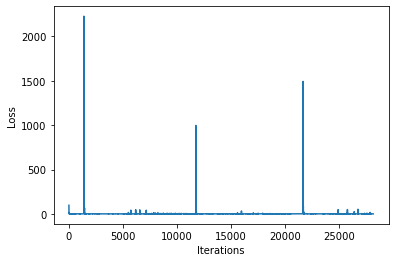

In [19]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')

In [20]:
def evaluate_model(ae, model):
    reconstructed = ae(model.fc1.weight.data.transpose(1, 0))
    new_weight = torch.transpose(reconstructed.reshape(784, 100), 1, 0)
    reconstructed_model = copy.deepcopy(model)
    reconstructed_model.fc1.weight.data = new_weight
    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            output = reconstructed_model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
        print(f'Accuracy of the network on the test images: {100 * correct/total}%')
    return 100 * correct/total

In [21]:
evaluate_model(ae, model)

Accuracy of the network on the test images: 72.2%


72.2

In [12]:
reconstructed.model.fc2.weight.data

NameError: name 'reconstructed' is not defined